# Run general analysis on phagophore membranes

When first ran need to pip install:
pyvista
pyvistaqt
mrcfile

In [1]:
#imports
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import pyvista as pv
from pyvistaqt import BackgroundPlotter
import os
import mrcfile as tf
import math
from numpy.linalg import inv, eig
from math import sqrt
from scipy.spatial import cKDTree
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
from functools import partial
from scipy.optimize import minimize


Functions

In [2]:
#if vol is a 3d numpy array representing a labelled volume where labels are e.g. 
#ER: 1 and Golgi: 2 then points["ER"] will be a 2D array of all the coordinates in vol where the value is 1.
def load_segmentation_tif(fname, tag, return_vol=False, verbose=False):
    """Load Amira segmentation saved as tif, and get all segmented points."""
    
    with tf.open(fname, permissive=True) as mrc:
        vol = np.copy(mrc.data) # load data (3d tif, or use mrcfile for mrc)
    vol = np.transpose(vol, axes=[2,1,0]) # Sort axes to xyz
    if verbose:
        print("Input volume shape is {}".format(vol.shape))

    # Extract points with labels saved in the dictionary "labels"
    # points = {name: np.vstack(np.where(vol == label)).T for name, label in labels.items()}    
    points = {tag: np.vstack(np.where(vol != 0)).T}
    if return_vol:
        return points, vol
    
    return points


Sphere functions

In [3]:
def sphere_fit_rmse(points, center, radius):
    """Calculate root mean square error of a sphere fit to points."""
    distances_to_center = np.sqrt( np.sum((points - center)**2, axis=1) )
    residuals = distances_to_center - radius
    residual_sum_squares = np.sum( np.power(residuals, 2) )
    rmse = np.sqrt(residual_sum_squares / len(residuals))
    return rmse

In [4]:
def ls_sphere_3(points):
    """
    Least squares fit of sphere to points.
    
    Modified code following approach described in:
    https://jekel.me/2015/Least-Squares-Sphere-Fit/
    
    Approach:
    Starting point: (x-x0)^2 + (y-y0)^2 + (z-z0)^2 = r^2
    Rearranged to: x^2 + y^2 + z^2 = 2x*x0 + 2y*y0 + 2z*z0 + 1*(r^2 -x0^2 -y0^2 -z0^2)
    --> Matrix:           f        =  A c
    with  f: nx1 vector with (xi^2 + yi^2 + zi^2) in i=1:n rows
          A: nx4 matrix with rows (2xi, 2yi, 2zi, 1)
          c: 4x1 target matrix [x0, y0, z0, (r^2 - x0^2 - y0^2 - z0^2)]

    
    Parameters
    ----------
    points : numpy.ndarray
        (n,3) array of point xyz coordinates.

    Returns
    -------
    center : numpy.ndarray
        xyz coordinates of sphere center.
    radius : float
        Sphere radius.
    rmse : float
        Root mean square error of fit.

    """
    # Assemble the A matrix
    A = np.append(2*points, np.ones( (points.shape[0],1) ), axis=1 ) # (2xi, 2yi, 2zi, 1)
    # Assemble f
    f = np.sum( np.power(points,2), axis=1) # x^2 + y^2 + z^2
    
    # Solve linear equation system Ac = f using least-squares algorithm
    c, residuals, rank, singval = np.linalg.lstsq(A,f)
    # Extract the center (first three values in c)
    center = c[0:3]
    # solve for the radius, c[3] = r^2 - x0^2 - y0^2 - z0^2
        # --> radius = sqrt( c[3] + x0^2 + y0^2 + z0^2 )
    radius = math.sqrt( c[3] + np.sum( np.power(center,2) ) )
    
    # determine RMSE by comparing distances of points to center to the radius
    rmse = sphere_fit_rmse(points, center, radius)
    
    return center, radius, rmse

Ellipsoid fitting Functions

In [5]:
def project_to_simplex(y):
    """
    Project an n-dim vector y to the simplex Dn.
    
    Dn = { x : x n-dim, 1 >= x >= 0, sum(x) = 1}
    (c) Xiaojing Ye, 2011
    
    Algorithm is explained as in the linked document http://arxiv.org/abs/1101.6081
    """
    bget = False; 
    s = -np.sort(-y) # Workaround to get sorting in descending order
    
    tmpsum = 0
    for i, si in enumerate(s[:-1]):
        tmpsum += si
        tmax = (tmpsum-1)/(i+1)
        if tmax >= s[i+1]:
            bget = True
            break
    
    if ~bget:
        tmax = (tmpsum + s[-1] - 1) / len(y)
    
    x = np.maximum(y-tmax, 0) # element-wise comparison, takes larger value for each element
    
    return x

In [6]:
def project_on_B(q0):
    """Project q0 on B.
    calls: project_to_simplex"""
    Q0 = np.array([[q0[0],          q0[3]/sqrt(2),  q0[4]/sqrt(2)],
                   [q0[3]/sqrt(2),  q0[1],          q0[5]/sqrt(2)],
                   [q0[4]/sqrt(2),  q0[5]/sqrt(2),  q0[2]]])
    #q0 encodes the quadratic terms of an ellipsoid in a vectorized form:
    #QO is reshaped into symmetric 3 x 3 matrix
    [s0,U]=eig(Q0)
    #This step decomposes the quadratic form into its principal axes and corresponding scales.
    s = project_to_simplex(s0)
    #A simplex projection ensures that the eigenvalues are non-negative and sum to 1 (or some other normalization), enforcing positive semidefiniteness and a normalized scale.
    S = np.diag(s)
    Q = U @ S @ U.T
    #rebuild
    
    q = np.concatenate( (np.array([Q[0,0], Q[1,1], Q[2,2], sqrt(2)* Q[1,0], sqrt(2)* Q[2,0], sqrt(2)* Q[2,1]]), 
                         q0[6:] ) )
    #convert Q back to q
    
    return q

In [7]:
def fit_ellipsoid_DR_SVD(x, n_iter=1000):
    """
    Fit an ellipsoid to points.
    
    Given a set of points x=(x1,..,xn), this function finds a fitting
    ellipsoid in 3D, by using the approach proposed in the companion paper. 
    This method is not affine invariant. DR stands for Douglas-Rachford
    (Lions-Mercier would be more accurate).
    
    The output ellipsoid E is described implicitely by a triplet (A,b,c):
    E={x in R^3, <Ax,x> + <b,x> + c=0}
    or alternatively by vector q =(a11,a22,a33,sqrt(2)a12,sqrt(2)a13,sqrt(2)a23,b1,b2,b3,c).
    
    INPUT:
    - x: set of coordinates of size 2xn.
    - n_iter: number of iterations in Douglas-Rachford algorithm.
    OUTPUT:
    - A,b,c : matrix, vector, scalar describing the ellipsoid.
    - q: (a11,a22,a33,sqrt(2)a12,sqrt(2)a13,sqrt(2)a23,b1,b2,b3,c). i.e. ellipsoid equation
    - CF: Cost function wrt to iterations.

    calls:
    Project_on_B
    """
    # Find SVD of x and change coordinates
    x_mean = x.mean(axis=0) #centroid of our object
    x_centered = x - x_mean # Center points around origin
    x_eval, x_evec = eig(x_centered.T @ x_centered) # Singular value decomposition. 
    #calculate eigen values i.e. x_eval how spreadout the data is. x_evec = eigen vector, i.e. principle axes of the points
    
    P = np.diagflat(np.power(x_eval, -0.5)) @ x_evec.T # Transformation matrix for normalization
    
    x_norm = P @ x_centered.T # normalize x

    #arranges points around the centroid, aligns the principle axes and makes the data isotropic - preprocessing. 
    #principal axes = 1. direction point cloid is most spread out. 2. direction of next more spreadout. 3. orthagonal to both. they explain variation in data
    
    # Assemble matrix D. i.e. equations to solve ellipsoid. 
    D = np.vstack( (x_norm**2, 
                    sqrt(2)*x_norm[0,:]* x_norm[1,:],
                    sqrt(2)*x_norm[0,:]* x_norm[2,:],
                    sqrt(2)*x_norm[1,:]* x_norm[2,:],
                    x_norm,
                    np.ones_like(x_norm[0,:]) ) )
    
    K = D @ D.T #solve ellipsoid
    
    # The objective is now to solve min <q,Kq>, Tr(Q)=1, Q>=0

    c = x_norm.mean(axis=1) # center after normalization
    
    r2 = x_norm.var(axis=1).sum() #varience of this

    #starting guess for ellipsoid
    u = 1/3 * np.hstack( (1, 1, 1,
                          0, 0, 0,
                          -2*c,
                          (c**2).sum()-r2 ) )
    
    
    # And now go to the Douglas-Rachford (Lions-Mercier) iterative algorithm
    gamma = 10; # parameter gamma
    
    M = gamma*K + np.eye(K.shape[0])   
    p = u
    CF = np.zeros(n_iter+1) #cost function
    
    # Iterative solution
    for k in range(n_iter):
        q = project_on_B(p)
        CF[k] = 0.5* q @ K @ q.T #cost function for each iteration
        
        (solution, res, rank, sing) = np.linalg.lstsq(M, 2*q-p, rcond=None) # solve for parameter p update
        p += solution - q
    
    q = project_on_B(q) 
    CF[-1] = 0.5* q @ K @ q.T #saves last cost function
    
    A2 = np.array([[q[0],          q[3]/sqrt(2),  q[4]/sqrt(2)],
                   [q[3]/sqrt(2),  q[1],          q[5]/sqrt(2)],
                   [q[4]/sqrt(2),  q[5]/sqrt(2),  q[2]]])
    
    b2 = q[6:9]
    c2 = q[9]    
    
    # Go back to initial basis. i.e. transform coordinates from centroid origin back to original
    A = P.T @ A2 @ P
    b = -2* A @ x_mean.T + P.T @ b2.T
    c = (A2 @ P @ x_mean.T).T @ (P @ x_mean.T) - b2.T @ P @ x_mean.T + c2

    #calculate ellipsoid surface
    q = np.hstack( (np.diag(A),
                    sqrt(2)*A[1,0], sqrt(2)*A[2,0], sqrt(2)*A[2,1],
                    b, c) )
    
    q = q / np.sum(np.diag(A)) # normalization to stay on the simplex
    
    return A, b, c, q, CF

In [8]:
def find_ellipsoid_parameters(A, b, c, verbose=False):
    """Given an ellipsoid E={x in R^3, <Ax,x> + <b,x> + c=0}, finds the center, radii and rotation matrix from A, b & c.
    calls: ellipsoid_triple_to_algebraic"""    
    # Determine the center
    # center = solution of A*x + b/2 = 0 -> -A*x = b/2
    center = np.linalg.lstsq(-1*A, 0.5*b)[0]
    if verbose:
        print('Ellipsoid center: {}'.format(center))
        
    # Determine the radii of the axes
    Amat = ellipsoid_triple_to_algebraic(A, b, c) # put ellipsoid parameters into 4x4 algebraic form
    # Transformation to center
    T = np.eye(4) # 4x4 unity matrix
    T[3,0:3] = center
    R = T @ Amat @ T.T # transform to center
    # Determine eigenvalues
    evals, evecs = eig(R[0:3,0:3] / -R[3,3])
    radii = np.power(abs(evals), -0.5) # radii = 1 / sqrt( abs(evals) )
    if verbose:
        print('Ellipsoid radii: {}'.format(radii))
        
    # Determine the rotation matrix
    rotmat = inv(evecs)
    
    return center, radii, rotmat

In [9]:
def ellipsoid_triple_to_algebraic(A,b,c):
    """Given A,b,c of an ellipsoid E={x in R^3, <Ax,x> + <b,x> + c=0}, returns the "algebraic form", i.e. a 4x4 matrix."""
    Amat = np.zeros((4,4))
    Amat[0:3,0:3] = A
    Amat[0:3,3] = b/2
    Amat[3,0:3] = b/2
    Amat[3,3] = c
    return Amat
    

In [10]:
def fit_ellipsoid_iter(x, n_iter=5000, plot_CF=True, return_CF=False):
    """
    Fit an ellipsoid using the approach by Weiss et al.
    
    This is just a wrapper to connect the two main functions.

    x = object points
    CF = cost function

    calls fit_ellipsoid_DR_SVD
    """
    # Make the fit (with SVD normalization for faster convergence, see the paper SI)
    A, b, c, q, CF = fit_ellipsoid_DR_SVD(x, n_iter)

    #abc is ellipsoid maths shape i.e. matrix vector and scalar
    #q is ellipsoid equation
    #CF cost function
    
    # Optional: plot cost function
    if plot_CF:
        plt.figure()
        plt.plot(CF[:-1] - CF.min())
        plt.yscale('log')
        plt.xlabel('Iteration number k'); plt.ylabel('Cost function f1(q(k)) - min f1(q)')
        plt.show()
        
    # Calculate ellipsoid parameters from A, b, c
    center, radii, rotmat = find_ellipsoid_parameters(A, b, c)
    # residual of Cost function
    residual = CF[-1]
    
    if return_CF:
        return center, radii, rotmat, residual, CF
    else:
        return center, radii, rotmat, residual

Check ellipsoid fit

In [11]:
def check_convergence_ellipsoid_fit(CF, n_iter, conv_frac=0.1, cutoff=1e-17):
    """Check if ellipsoid fit converged."""
    # Determine required convergence area
    conv_area_start = np.round(n_iter*(1-conv_frac)).astype(int)
    # Calculate cost function difference and check for cutoff
    CF_diff = CF - CF[-1]
    if np.max(CF_diff[conv_area_start:]) > cutoff:
        return False
    return True
    

Find minimal distance between query point and ellipsoid

In [12]:
def generate_ellipsoid_even(radii, center, rotation_matrix, n_points=1000, 
                            return_mesh=False, return_angles=False):
    """
    Generate ellipsoid points or mesh from ellipsoid parameters.
    
    Surface generation found in: https://stackoverflow.com/questions/47485235/i-want-to-make-evenly-distributed-sphere-in-vtk-python
    Initial point generation is done with a Fibonacci lattice / golden spiral 
    approach to get points that are (relatively) evenly distributed on a unit 
    sphere.
    Coordinates are then stretched by the radii, rotated by the rotation matrix 
    and shifted by the center.
    If return_mesh=True, a surface mesh is finally generated from the points 
    using delaunay triangulation implemented in pyvista.


    Parameters
    ----------
    radii : numpy.ndarray
        (3,) array of ellipsoid radii / axis lengths.
    center : numpy.ndarray
        Coordinates of ellipsoid center (3,).
    rotation_matrix : numpy.ndarray
        Ellpsoid rotation matrix.
    n_points : int, optional
        Number of points in final structure. The default is 1000.
    return_mesh : bool, optional
        If True, returns a pyvista mesh generated from the points. The default is False.

    Returns
    -------
    points : numpy.ndarray, if return_mesh = False (default)
        A (n_points,3) array of ellipsoid points.
        If return_mesh = True, a pyvista mesh of the ellipsoid surface is returned
        instead. The ellipsoid points are then accessible through mesh.points.

    """
    # Generate coordinates distributed by a Fibonacci pattern on the base ellipsoid.    
    indices = np.arange(0, n_points, dtype=float) + 0.5
    
    phi = np.arccos(1 - 2*indices/n_points)
    theta = np.pi * (1 + 5**0.5) * indices
    theta = theta % (2*np.pi) # put theta into range (0, 2*pi)
    
    x =  np.cos(theta) * np.sin(phi) * radii[0]
    y = np.sin(theta) * np.sin(phi) * radii[1]
    z = np.cos(phi) * radii[2]
    
    # combine points
    points = np.c_[x,y,z]
    # rotate points with rotation matrix
    points = np.dot(points, rotation_matrix)
    # Shift points by center
    points += center
    
    if return_angles and not return_mesh:
        return points, theta, phi
    elif return_angles and return_mesh:
        return points_to_surface(points), theta, phi
    
    if return_mesh:
        return points_to_surface(points)
    
    return points

In [13]:
def minimum_distance_ellipsoid(query_point, center, axes, rotmat, init_angles=(0,0)):
    """
    Find the closest distance and point on an ellipsoid for a query point.
    
    The closest distance and point are found by minimizing the distance function using scipy.optimize.minimize.
    
    Parameters
    ----------
    query_point : numpy.ndarray
        Coordinates of query point.
    center : numpy.ndarray
        Ellipsoid center.
    axes : numpy.ndarray
        Ellipsoid axes.
    rotmat : numpy.ndarray
        Ellipsoid rotation matrix.
    init_angles : tuple, optional
        Angles describing initial guess for closest ellipsoid point to ellipsoid point. The default is (0,0).

    Returns
    -------
    distance : float
        Distance between query point and the determined closest ellipsoid point.
    closest_ellipsoid_point : numpy.ndarray
        Coordinates of closest ellipsoid point.
    res : scipy.optimize.OptimizeResult
        Complete results of scipy.optimize.minimize. Important attributes are:
            res.x : (theta, phi) angles describing the closest ellipsoid point.
            res.fun = distance (closest distance)
            res.success : Boolean flag indicating whether optimization was successful.
        For a complete description see https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.OptimizeResult.html

    Calls:
    distance_to_ellipsoid
    ellipsoid_point_from_angles
    """
    # Minimize the distance over the pair of angles that define the ellipsoid point
    #finds the minimum distance between the query and ellipsoid surface
    minimizing_function = partial(distance_to_ellipsoid, query_point=query_point, center=center, axes=axes, rotmat=rotmat) 
    res = minimize(minimizing_function, init_angles, bounds=((0, 2*np.pi), (0, np.pi)), tol=1e-6)
    # The distance is the minimized function value
    distance = res.fun    
    # Find the closest ellipsoid point using the angles
    closest_ellipsoid_point = ellipsoid_point_from_angles(*res.x, center, axes, rotmat)
    
    return distance, closest_ellipsoid_point, res    

In [14]:
def distance_to_ellipsoid(angles, query_point, center, axes, rotmat):
    """
    Calculate the distance of a query point to a point on an ellipsoid.
    
    The ellipsoid point is defined by angles and ellipsoid parameters.
    angles: tuple of (theta, phi) with theta in [0,2pi] and phi in [0,pi].
    """  
    # Unpack angles
    theta, phi = angles
    # Generate ellipsoid point from angles
    x =  np.cos(theta) * np.sin(phi) * axes[0]
    y = np.sin(theta) * np.sin(phi) * axes[1]
    z = np.cos(phi) * axes[2]    
    point = np.array([x,y,z])
    # rotate point with rotation matrix and shift it by the center
    point = np.dot(point, rotmat) + center
    
    # Calculate distance to query point
    distance = np.linalg.norm(query_point - point)
    
    return distance

In [15]:
def ellipsoid_point_from_angles(theta, phi, center, axes, rotmat):
    """
    Generate points on an ellipsoid from the given angles.
    
    Angle ranges: theta 0->2pi, phi 0->pi
    """
    # Generate point from angles
    x =  np.cos(theta) * np.sin(phi) * axes[0]
    y = np.sin(theta) * np.sin(phi) * axes[1]
    z = np.cos(phi) * axes[2]    
    point = np.array([x,y,z])
    # rotate point with rotation matrix and shift it by the center
    point = np.dot(point, rotmat) + center
    
    return point

Ellipsoid RMSE

In [16]:
def ellipsoid_fit_rmse(image_name, query_points, axes, center, rotmat, return_full=True):
    """
    Calculate the root mean square error for an ellipsoid fit.
    
    For each of the query points, determine the closest distance and corresponding 
    point on the ellipsoid by minimizing the distance function.
    
    Parameters
    ----------
    query_points : numpy.ndarray
        Points to check against the ellipsoid fit.
    axes : numpy.ndarray
        Ellipsoid axes lengths.
    center : numpy.ndarray
        Ellipsoid center.
    rotmat : numpy.ndarray
        Ellipsoid rotation matrix.
    return_full : bool, optional
        Whether to return all distances and nearest ellipsoid points. The default is True.

    Returns
    -------
    ellipsoid_rmse : float
        Root mean square error of ellipsoid fit.
    dist_pe : numpy.ndarray, optional, if return_full=True
        Distances of all query points to ellipsoid.
    ell_points_nearest : numpy.ndarray, optional, if return_full=True
        Nearest ellipsoid points for all query points.

    Calls: 
    generate_ellipsoid_even
    minimum_distance ellipsoid
    """    
    # Find starting angles for all query points
    ellipsoid_points, ell_theta, ell_phi = generate_ellipsoid_even(axes, center, rotmat, 
                                                                   n_points=2000, return_angles=True)
    ellipsoid_angles = np.c_[ell_theta, ell_phi] # Combine ellipsoid angles into array
    
    # Find the INITIAL closest ellipsoid point for each query point and get the corresponding set of angles
    tree_ell = cKDTree(ellipsoid_points) # Make a KDTree
    _, idx_ell0 = tree_ell.query(query_points) # Find the closest points    
    init_angle_array = ellipsoid_angles[idx_ell0] # Find the corresponding angles
 
    # Prepare output arrays
    dist_pe = np.zeros(query_points.shape[0])
    ell_points_nearest = np.zeros(query_points.shape)
    
    # Run minimization. for each query point find closest point on ellipsoid
    for i, point in enumerate(tqdm(query_points)):
        #if i > 10000: break
        init_angles = tuple( init_angle_array[i] )
        dist_pe[i], ell_points_nearest[i,:], res = minimum_distance_ellipsoid(point, center, 
                                                                              axes, rotmat, 
                                                                              init_angles=init_angles)
   
    ##################################################################################################################
    # #visualising this
    # num_points_to_plot = 50
    # indices = np.random.choice(len(query_points), size=num_points_to_plot, replace=False)

    # query_subset = query_points[indices]
    # closest_subset = ellipsoid_points[idx_ell0[indices]]

    # Create the plotter
    # pv.set_jupyter_backend('static')

    # plotter = pv.Plotter()

    # plotter.add_mesh(ellipsoid_points, color='lightblue', opacity=0.5, show_edges=True)
    
    # # Add query points (as a PyVista point cloud)
    # query_points_pv = pv.PolyData(query_points[indices])
    # plotter.add_points(query_points_pv, color='red', point_size=10, render_points_as_spheres=True, label='Data')

    # # starting point
    # int_closest_points_pv = pv.PolyData(closest_subset)
    # plotter.add_points(int_closest_points_pv, color='yellow', point_size=10, render_points_as_spheres=True, label='Initial Guess of Closest Point')
    
    # # Add closest points on ellipsoid
    # closest_points_pv = pv.PolyData(ell_points_nearest[indices])
    # plotter.add_points(closest_points_pv, color='green', point_size=10, render_points_as_spheres=True, label='Closest Point on Fitted Ellipsoid')

    # # Create lines between corresponding points - query and initial
    # lines = []
    # points_combined = []
    
    # for i, (qp, cp) in enumerate(zip(query_subset, closest_subset)):
    #     # Indices for the start and end of the line segment in points_combined
    #     start_idx = 2 * i
    #     end_idx = start_idx + 1
        
    #     points_combined.append(qp)
    #     points_combined.append(cp)
        
    #     # Line format: [number_of_points_in_line, start_point_idx, end_point_idx]
    #     lines.extend([2, start_idx, end_idx])
    
    # points_combined = np.array(points_combined)
    # lines = np.array(lines)
    
    # # Create a PolyData with points and lines
    # lines_poly = pv.PolyData()
    # lines_poly.points = points_combined
    # lines_poly.lines = lines
    
    # # Add the lines to the plotter
    # plotter.add_mesh(lines_poly, color='light_gray', line_width=1)
    
    # # Create lines between corresponding points, query and final
    # f_lines = []
    # f_points_combined = []
    
    # for i, (qp, cp) in enumerate(zip(query_subset, ell_points_nearest[indices])):
    #     # Indices for the start and end of the line segment in points_combined
    #     start_idx = 2 * i
    #     end_idx = start_idx + 1
        
    #     f_points_combined.append(qp)
    #     f_points_combined.append(cp)
        
    #     # Line format: [number_of_points_in_line, start_point_idx, end_point_idx]
    #     f_lines.extend([2, start_idx, end_idx])
    
    # f_points_combined = np.array(f_points_combined)
    # f_lines = np.array(f_lines)
    
    # # Create a PolyData with points and lines
    # f_lines_poly = pv.PolyData()
    # f_lines_poly.points = f_points_combined
    # f_lines_poly.lines = f_lines
    
    # # Add the lines to the plotter
    # plotter.add_mesh(f_lines_poly, color='black', line_width=1)

    # plotter.add_legend()
    # plotter.show()

    # # Save instead of show
    # output_dir = Path("outputs")
    # output_dir.mkdir(exist_ok=True)
    # plot_path = output_dir / f"{image_name}_ellipsoid_fit_visualisation.png"
    # plotter.screenshot(str(plot_path))
    # plotter.close()
    
    # print(f"Saved plot to {plot_path.resolve()}")
    #####################################################################################################################################

    # Calculate the rmse
    residual_sum_squares = np.sum( np.power(dist_pe, 2) )
    ellipsoid_rmse = np.sqrt(residual_sum_squares / len(dist_pe))
    
    if return_full:
        return ellipsoid_rmse, dist_pe, ell_points_nearest

    return ellipsoid_rmse

Ellipsoid characteristics

In [17]:
def ellipsoid_SA_Vol(axes):
    # Surface area of ellipsoid
    """
    Approximation of ellipsoid surface area after Knud Thomsen (2004).

    Maximum error is +-1.061%    
    Source: www.numericana.com/answer/ellipsoid.htm 
    cited e.g. in https://doi.org/10.1016/j.mri.2008.07.018
    """   
    a, b, c = axes
    p = 1.6075 # constant defined by K. Thomsen
    area = 4 * np.pi* (( (a*b)**p + (a*c)**p + (b*c)**p ) / 3)**(1/p)  
    
    """Volume of an ellipsoid."""
    V = 4/3 * np.pi * axes[0] * axes[1] * axes[2] # Volume is 4/3*pi*abc
      

    return area, V 

In [18]:
def sphericity_index_ellipsoid(axes):
    """Sphericity index of an ellipsoid as defined in Cruz-Matias et al. 2019, doi: 10.1016/j.jocs.2018.11.005.""" 
    axis_c, axis_b, axis_a = np.sort(axes) 
    sphericity_index = (axis_c**2 / (axis_a*axis_b))**(1/3)
    
    return sphericity_index

In [19]:
def sphericity_of_ellipsoid(axes, ellipsoid_surface_area, V_ellipsoid, verbose=False):
    """
    Calculate the 'classical' sphericity of an ellipsoid.
    
    Sphericity is defined as surface area of sphere with same volume 
    divided by actual surface area.
    """
    # Surface area of corresponding sphere
    r_csphere = ( (3*V_ellipsoid ) / (4 * np.pi) )**(1/3) # radius of corresponding sphere
    A_csphere =  4 * np.pi * r_csphere**2 # Area of corresponding sphere, 4 pi r^2
    if verbose:
        print("Surface area of sphere with same volume: {}".format(A_csphere))
    # Sphericity    
    sphericity = A_csphere / ellipsoid_surface_area
    if verbose:
        print("The sphericity of the best-fitting ellipsoid is {}".format(sphericity))
    
    return sphericity

Generate a mesh from a point cloud for plotting

In [20]:
def generate_sphere_even(radius, center, n_points=1000, return_mesh=False):
    """
    Generate points distributed relatively evenly on a sphere.
    
    The points follow a Fibonacci / golden spiral.
    """
    indices = np.arange(0, n_points, dtype=float) + 0.5
    
    phi = np.arccos(1 - 2*indices/n_points)
    theta = np.pi * (1 + 5**0.5) * indices
    
    x =  np.cos(theta) * np.sin(phi) * radius
    y = np.sin(theta) * np.sin(phi) * radius
    z = np.cos(phi) * radius
    
    # combine points
    points = np.c_[x,y,z]
    # Shift points by center
    points += center
    
    if return_mesh:
        return points_to_surface(points)
    
    return points
    

In [21]:
def points_to_surface(points):
    """Turn point array into pyvista mesh.
    
    Code found in https://stackoverflow.com/questions/47485235/i-want-to-make-evenly-distributed-sphere-in-vtk-python
    """
    # Make points into Pyvista PolyData
    point_cloud = pv.PolyData(points)
    # Delaunay triangulation and surface extraction
    surf = point_cloud.delaunay_3d().extract_surface()
    
    return surf

## Input

In [22]:
# For visualization
window_size_0 = [1000,1000]
cpos = {'points': [(613.2361218667041, -345.6736538983374, 804.1761468432726),
                   (318.0, 625.0, 103.0),
                   (-0.18533229149002745, 0.5377558197272821, 0.8224783401892688)],
       'fits': [(134.05519106408673, 728.3388319306499, -1326.1850713469473),
                  (318.0849037026922, 633.5867890633508, 211.84321658237687),
                  (0.8856876772441696, 0.4577205594903096, -0.07777678186776335)]}


In [23]:
#folders
image_folder = Path('../vesicles_seg/')
# npy_file_path = Path('data.npy')

#parameters shared by all images
pix_size = 1 #nm

# Segmentation labels

# Parameters 
n_iter_ellipsoid_fit = 10000 # Check plot if fit converged!
n_iter_ell_run2 = 50000 # If first fit didn't converge, try once more with this number of iterations
ellipsoid_fit_samplesize = 2000

clean_points_clustering = False # Whether to find outlier points with clustering

# Results dictionary for comparison
output_dir = Path("../vesicles_seg/outputs")
output_dir.mkdir(exist_ok=True)
npy_file_path = image_folder / 'results.npy'
# Check if the file exists
if npy_file_path.exists():
    print("File exists.")
    data = np.load(npy_file_path, allow_pickle=True).item()

else:
    print("File does not exist.")
    print("Creating results.npy")
    data = {}


    

File does not exist.
Creating results.npy


High_mag_L12_P1_2_memb_7_2-COP1.mrc

COP1

Input volume shape is (896, 896, 448)


2025-06-13 08:11:57.368 (  10.223s) [    7F4B82B19400]vtkXOpenGLRenderWindow.:1416  WARN| bad X server connection. DISPLAY=
/camp/home/downesk/.local/lib/python3.12/site-packages/pyvista/core/utilities/points.py:77: UserWarning: Points is not a float type. This can cause issues when transforming or applying filters. Casting to ``np.float32``. Disable this by passing ``force_float=False``.
  warnings.warn(


Saved plot to: /nemo/lab/zanettig/home/users/downesk/Tomography/27FEB25/analysis/vesicles_seg/outputs/High_mag_L12_P1_2_memb_7_2-COP1.mrc_input.png

Fitting of refined COP1 points.
Sphere fit: COP1 membrane radius is 25.692637577441598 nm
Sphere fit error is 2.484475149587777 nm

Ellipsoid fitting


/tmp/slurm_22453446/ipykernel_2697562/3568048311.py:21: DeprecationWarning: Bitwise inversion '~' on bool is deprecated and will be removed in Python 3.16. This returns the bitwise inversion of the underlying int object and is usually not what you expect from negating a bool. Use the 'not' operator for boolean negation or ~int(x) if you really want the bitwise inversion of the underlying int.
  if ~bget:


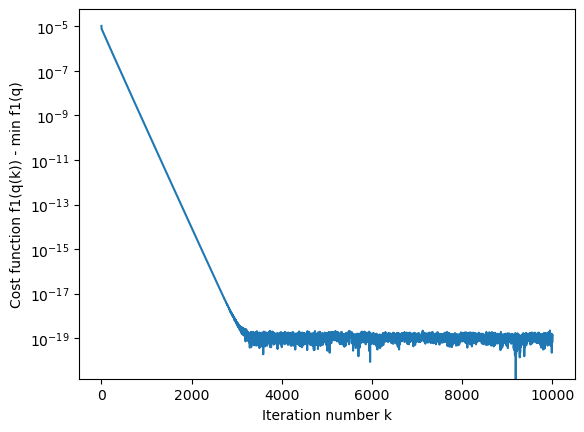

Calculating ellipsoid fit rmse...



100%|██████████| 43600/43600 [01:10<00:00, 619.58it/s]


Ellipsoid fit rmse is 2.2955993292442805 nm.
Ellipsoid fit: COP1 membrane axes is [24.12230064 27.86525703 25.29421767] nm
Ellipsoid fit: COP1 membrane Surface Area is 8332.69959883766 nm
Ellipsoid fit: COP1 membrane Volume is 71218.30613544318 nm
Sphericity index of best-fitting ellipsoid is 0.9381041320899932 for COP1 membrane.
Sphericity of best-fitting ellipsoid is 0.9971477015040077 for COP1 membrane.

{'Image_Name': 'High_mag_L12_P1_2_memb_7_2-COP1.mrc', 'Image_Tag': 'COP1', 'info': {'sphere_center': array([313.79052959, 519.26134998, 268.80920391]), 'sphere_radius': 25.692637577441598, 'sphere_rmse': 2.484475149587777, 'sphere_radius_nm': 25.692637577441598, 'ellipsoid_center': array([313.49116675, 519.57194128, 269.14558678]), 'ellipsoid_axes': array([24.12230064, 27.86525703, 25.29421767]), 'ellipsoid_rotmat': array([[ 0.99300338, -0.06643975, -0.09762192],
       [-0.06285355,  0.40248507, -0.91326623],
       [-0.09996855, -0.91301234, -0.39549306]]), 'ellipsoid_residual': 8

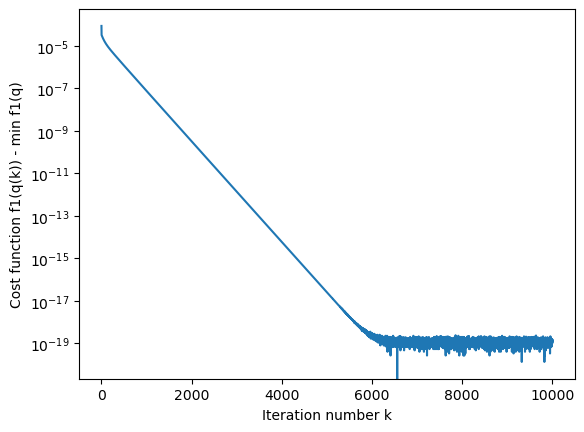

Calculating ellipsoid fit rmse...



100%|██████████| 23486/23486 [00:39<00:00, 593.58it/s]


Ellipsoid fit rmse is 2.857392460978919 nm.
Ellipsoid fit: COP2 membrane axes is [27.55721565 36.5569588  40.43056769] nm
Ellipsoid fit: COP2 membrane Surface Area is 15205.312936859824 nm
Ellipsoid fit: COP2 membrane Volume is 170609.74851239123 nm
Sphericity index of best-fitting ellipsoid is 0.8009343570513994 for COP2 membrane.
Sphericity of best-fitting ellipsoid is 0.9783434092609459 for COP2 membrane.

{'Image_Name': 'L7_LOW_1_3_HIGH_1_memb_10_1-COP2.mrc', 'Image_Tag': 'COP2', 'info': {'sphere_center': array([240.2365662 , 691.34106482, 203.40244566]), 'sphere_radius': 26.746352912307916, 'sphere_rmse': 4.036138143933656, 'sphere_radius_nm': 26.746352912307916, 'ellipsoid_center': array([234.97222864, 701.79476443, 201.82600575]), 'ellipsoid_axes': array([27.55721565, 36.5569588 , 40.43056769]), 'ellipsoid_rotmat': array([[ 0.89044216,  0.43946945,  0.11823438],
       [ 0.41680291, -0.89182562,  0.17584767],
       [-0.18272413,  0.10730175,  0.97729127]]), 'ellipsoid_residual'

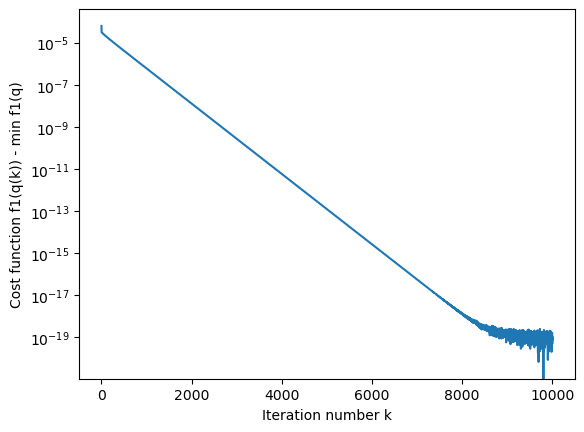

Calculating ellipsoid fit rmse...



100%|██████████| 21082/21082 [00:37<00:00, 555.04it/s]


Ellipsoid fit rmse is 2.087807876843286 nm.
Ellipsoid fit: COP2 membrane axes is [56.01279788 27.83824819 34.19420936] nm
Ellipsoid fit: COP2 membrane Surface Area is 18954.893577286628 nm
Ellipsoid fit: COP2 membrane Volume is 223341.97107402392 nm
Sphericity index of best-fitting ellipsoid is 0.7396302368844984 for COP2 membrane.
Sphericity of best-fitting ellipsoid is 0.9391673885709141 for COP2 membrane.

{'Image_Name': 'L25_LOW_2_HIGH_1_memb_1_1-COP2.mrc', 'Image_Tag': 'COP2', 'info': {'sphere_center': array([147.87288004, 101.33733387, 177.2294365 ]), 'sphere_radius': 27.963003208998913, 'sphere_rmse': 3.3823328930924483, 'sphere_radius_nm': 27.963003208998913, 'ellipsoid_center': array([131.73054674, 111.04703558, 188.41953428]), 'ellipsoid_axes': array([56.01279788, 27.83824819, 34.19420936]), 'ellipsoid_rotmat': array([[ 0.7293503 , -0.36345064, -0.57961347],
       [-0.53167007, -0.83429534, -0.14587056],
       [ 0.43055207, -0.41455387,  0.80172938]]), 'ellipsoid_residual':

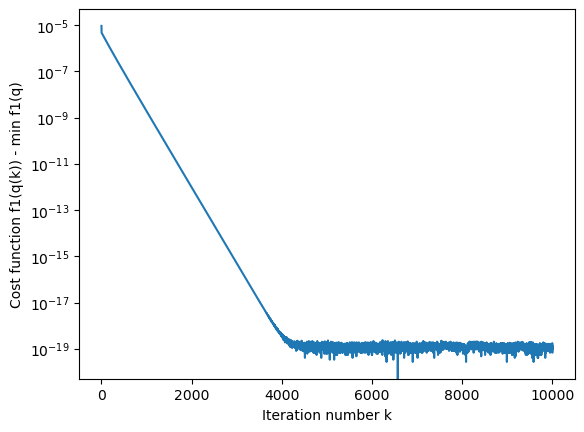

Calculating ellipsoid fit rmse...



100%|██████████| 7666/7666 [00:12<00:00, 622.97it/s]


Ellipsoid fit rmse is 2.525827900848967 nm.
Ellipsoid fit: COP1 membrane axes is [ 5.34812114 11.98174268 19.08776313] nm
Ellipsoid fit: COP1 membrane Surface Area is 1791.0901228663115 nm
Ellipsoid fit: COP1 membrane Volume is 5123.477946370936 nm
Sphericity index of best-fitting ellipsoid is 0.5000834503411503 for COP1 membrane.
Sphericity of best-fitting ellipsoid is 0.8024351290376548 for COP1 membrane.

{'Image_Name': 'L39_LOW_1_7_HIGH_1_memb_1_2-COP1.mrc', 'Image_Tag': 'COP1', 'info': {'sphere_center': array([368.06873249, 528.13583927, 154.90538845]), 'sphere_radius': 19.506501879006976, 'sphere_rmse': 3.249150079463487, 'sphere_radius_nm': 19.506501879006976, 'ellipsoid_center': array([369.46412664, 540.55126481, 154.91728998]), 'ellipsoid_axes': array([ 5.34812114, 11.98174268, 19.08776313]), 'ellipsoid_rotmat': array([[ 0.15373236,  0.98793919, -0.01850708],
       [ 0.97903071, -0.15482622, -0.13239223],
       [ 0.13366085, -0.00223397,  0.99102461]]), 'ellipsoid_residual':

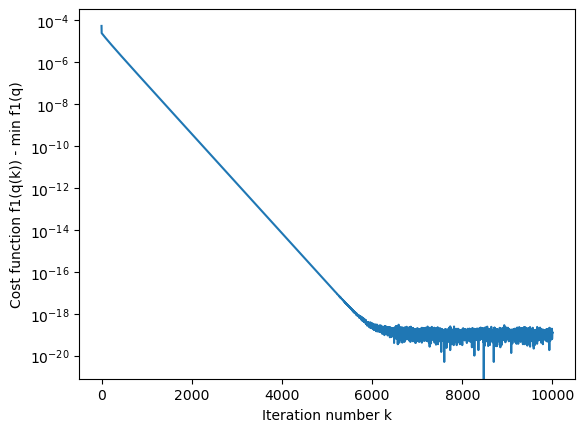

Calculating ellipsoid fit rmse...



100%|██████████| 30246/30246 [00:51<00:00, 591.89it/s]


Ellipsoid fit rmse is 2.2781919567102946 nm.
Ellipsoid fit: COP1 membrane axes is [26.75278038 31.35343876 36.29553937] nm
Ellipsoid fit: COP1 membrane Surface Area is 12405.730384476863 nm
Ellipsoid fit: COP1 membrane Volume is 127525.18675487599 nm
Sphericity index of best-fitting ellipsoid is 0.8567743798605598 for COP1 membrane.
Sphericity of best-fitting ellipsoid is 0.9876258114136759 for COP1 membrane.

{'Image_Name': 'L24_LOW_2_4_HIGH_1_3_memb_32_2-COP1.mrc', 'Image_Tag': 'COP1', 'info': {'sphere_center': array([515.71520849, 280.57308724, 224.95229169]), 'sphere_radius': 28.605367587099376, 'sphere_rmse': 2.809055010244089, 'sphere_radius_nm': 28.605367587099376, 'ellipsoid_center': array([518.81697529, 279.99587687, 222.63242505]), 'ellipsoid_axes': array([26.75278038, 31.35343876, 36.29553937]), 'ellipsoid_rotmat': array([[-0.33608595, -0.91364305, -0.22869765],
       [-0.87134781,  0.39379625, -0.2927072 ],
       [-0.35749018, -0.10090042,  0.92845026]]), 'ellipsoid_resid

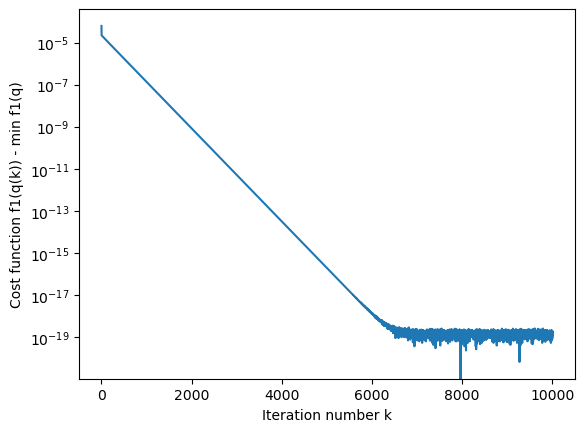

Calculating ellipsoid fit rmse...



100%|██████████| 42324/42324 [01:14<00:00, 568.34it/s]


Ellipsoid fit rmse is 2.8384087934682127 nm.
Ellipsoid fit: COP1 membrane axes is [33.39631644 38.07973095 54.59301313] nm
Ellipsoid fit: COP1 membrane Surface Area is 21925.582945979822 nm
Ellipsoid fit: COP1 membrane Volume is 290815.87690747046 nm
Sphericity index of best-fitting ellipsoid is 0.812559925493038 for COP1 membrane.
Sphericity of best-fitting ellipsoid is 0.968155352326797 for COP1 membrane.

{'Image_Name': 'L24_LOW_1_5_HIGH_1_memb_17_2-COP1.mrc', 'Image_Tag': 'COP1', 'info': {'sphere_center': array([ 83.82540164, 695.36479206, 251.39663756]), 'sphere_radius': 35.514811320466904, 'sphere_rmse': 3.622292095423016, 'sphere_radius_nm': 35.514811320466904, 'ellipsoid_center': array([ 85.69289625, 710.09667538, 245.98986789]), 'ellipsoid_axes': array([33.39631644, 38.07973095, 54.59301313]), 'ellipsoid_rotmat': array([[ 0.94379246, -0.12640886, -0.30541218],
       [-0.3296753 , -0.2932559 , -0.89739355],
       [-0.02387457, -0.94764011,  0.31844658]]), 'ellipsoid_residual'

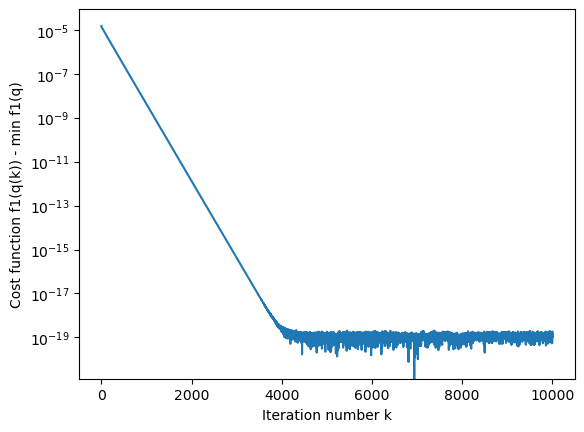

Calculating ellipsoid fit rmse...



100%|██████████| 141020/141020 [03:56<00:00, 595.36it/s]


Ellipsoid fit rmse is 3.553050086720428 nm.
Ellipsoid fit: COP2 membrane axes is [39.25513949 46.00206546 44.17411946] nm
Ellipsoid fit: COP2 membrane Surface Area is 23372.84000893667 nm
Ellipsoid fit: COP2 membrane Volume is 334141.4608932155 nm
Sphericity index of best-fitting ellipsoid is 0.9119043182893002 for COP2 membrane.
Sphericity of best-fitting ellipsoid is 0.9963063146840088 for COP2 membrane.

{'Image_Name': 'L17_LOW_3_HIGH_1_memb_64_1-COP2.mrc', 'Image_Tag': 'COP2', 'info': {'sphere_center': array([580.18180438, 258.03201092, 110.92958588]), 'sphere_radius': 42.82376553677768, 'sphere_rmse': 4.003456722784919, 'sphere_radius_nm': 42.82376553677768, 'ellipsoid_center': array([580.83613661, 258.47592816, 110.38755591]), 'ellipsoid_axes': array([39.25513949, 46.00206546, 44.17411946]), 'ellipsoid_rotmat': array([[ 0.57144449,  0.38008275,  0.72731582],
       [ 0.81142519, -0.12924626, -0.56998647],
       [ 0.12263918, -0.915878  ,  0.38226578]]), 'ellipsoid_residual': 7.4

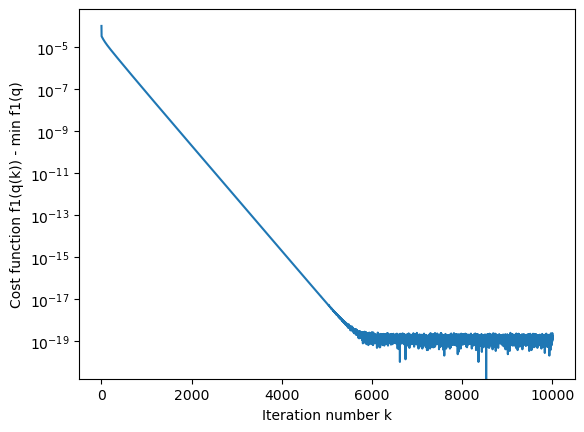

Calculating ellipsoid fit rmse...



100%|██████████| 26327/26327 [00:44<00:00, 585.91it/s]


Ellipsoid fit rmse is 2.376489988543767 nm.
Ellipsoid fit: COP1 membrane axes is [40.14691581 30.65866186 28.74882008] nm
Ellipsoid fit: COP1 membrane Surface Area is 13761.999573915862 nm
Ellipsoid fit: COP1 membrane Volume is 148222.46005741414 nm
Sphericity index of best-fitting ellipsoid is 0.8756789075768381 for COP1 membrane.
Sphericity of best-fitting ellipsoid is 0.9841892017326569 for COP1 membrane.

{'Image_Name': 'L13_LOW_7_2_HIGH_1_2_memb_40_6-COP1.mrc', 'Image_Tag': 'COP1', 'info': {'sphere_center': array([590.04930101, 549.86234797, 168.80538263]), 'sphere_radius': 30.266679074238212, 'sphere_rmse': 2.9342445110984254, 'sphere_radius_nm': 30.266679074238212, 'ellipsoid_center': array([588.89995865, 550.40970179, 169.27847958]), 'ellipsoid_axes': array([40.14691581, 30.65866186, 28.74882008]), 'ellipsoid_rotmat': array([[ 0.37413207,  0.05787908,  0.9255675 ],
       [-0.70520434,  0.66590976,  0.24341533],
       [ 0.60225578,  0.74378371, -0.28995477]]), 'ellipsoid_resid

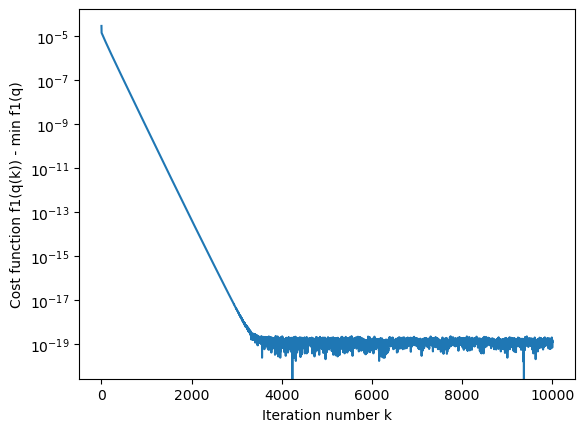

Calculating ellipsoid fit rmse...



100%|██████████| 111819/111819 [03:07<00:00, 596.49it/s]


Ellipsoid fit rmse is 3.3599541506597213 nm.
Ellipsoid fit: COP2 membrane axes is [47.21356179 36.78166867 34.6603286 ] nm
Ellipsoid fit: COP2 membrane Surface Area is 19566.854414401183 nm
Ellipsoid fit: COP2 membrane Volume is 252127.0705659518 nm
Sphericity index of best-fitting ellipsoid is 0.8844142257454662 for COP2 membrane.
Sphericity of best-fitting ellipsoid is 0.9863766041528076 for COP2 membrane.

{'Image_Name': 'L25_LOW_1_HIGH_1_memb_6_1-COP2.mrc', 'Image_Tag': 'COP2', 'info': {'sphere_center': array([408.60839325, 488.28624089, 251.61925933]), 'sphere_radius': 38.26328344861943, 'sphere_rmse': 4.325706960838922, 'sphere_radius_nm': 38.26328344861943, 'ellipsoid_center': array([408.99270888, 488.44926555, 255.88073889]), 'ellipsoid_axes': array([47.21356179, 36.78166867, 34.6603286 ]), 'ellipsoid_rotmat': array([[ 0.35063801, -0.04258078,  0.93554255],
       [ 0.86174201,  0.40580245, -0.30450792],
       [ 0.36667928, -0.91296837, -0.17898341]]), 'ellipsoid_residual': 8.

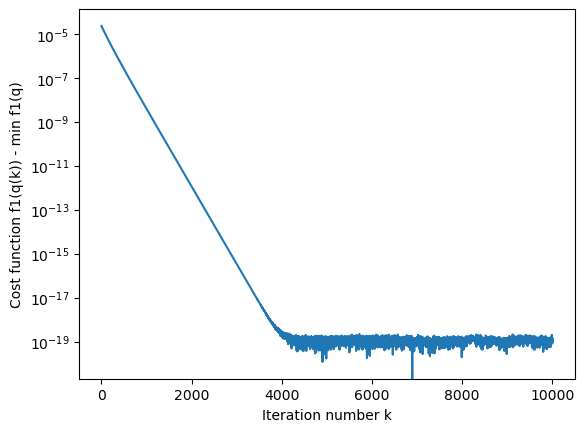

Calculating ellipsoid fit rmse...



100%|██████████| 115299/115299 [03:24<00:00, 564.58it/s]


Ellipsoid fit rmse is 2.9326169497848995 nm.
Ellipsoid fit: COP2 membrane axes is [38.96992156 45.1437556  54.91716096] nm
Ellipsoid fit: COP2 membrane Surface Area is 26873.717102031806 nm
Ellipsoid fit: COP2 membrane Volume is 404691.3339489249 nm
Sphericity index of best-fitting ellipsoid is 0.8492803971554851 for COP2 membrane.
Sphericity of best-fitting ellipsoid is 0.9845527429120062 for COP2 membrane.

{'Image_Name': 'L11_HIGH_3_7_memb_10_1-COP2.mrc', 'Image_Tag': 'COP2', 'info': {'sphere_center': array([219.29619717, 309.14485816, 279.31863956]), 'sphere_radius': 43.65942869050006, 'sphere_rmse': 4.071118003876528, 'sphere_radius_nm': 43.65942869050006, 'ellipsoid_center': array([219.31982103, 311.10709337, 286.38442192]), 'ellipsoid_axes': array([38.96992156, 45.1437556 , 54.91716096]), 'ellipsoid_rotmat': array([[ 0.8528761 ,  0.38170638, -0.3562339 ],
       [ 0.50577047, -0.77337532,  0.38221309],
       [ 0.12960934,  0.506153  ,  0.85264914]]), 'ellipsoid_residual': 4.999

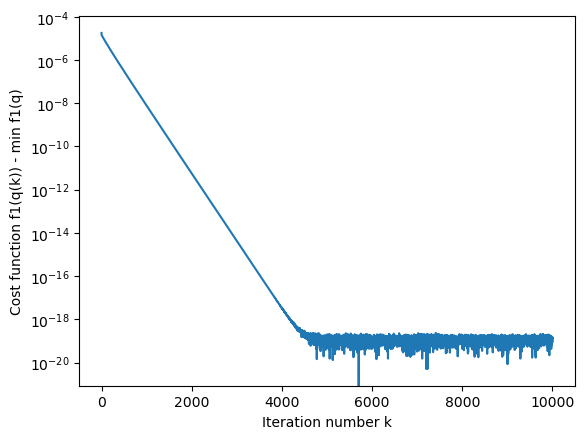

Calculating ellipsoid fit rmse...



100%|██████████| 108388/108388 [03:11<00:00, 564.58it/s]


Ellipsoid fit rmse is 2.8499888734831065 nm.
Ellipsoid fit: COP2 membrane axes is [30.67758536 38.55522313 57.36904044] nm
Ellipsoid fit: COP2 membrane Surface Area is 21986.970996032684 nm
Ellipsoid fit: COP2 membrane Volume is 284230.44114546716 nm
Sphericity index of best-fitting ellipsoid is 0.7521316191399233 for COP2 membrane.
Sphericity of best-fitting ellipsoid is 0.9508217633194302 for COP2 membrane.

{'Image_Name': 'L11_HIGH_3_7_memb_14_1-COP2.mrc', 'Image_Tag': 'COP2', 'info': {'sphere_center': array([281.92280449, 208.76062564, 263.46008395]), 'sphere_radius': 37.90218441617444, 'sphere_rmse': 5.0713983749471385, 'sphere_radius_nm': 37.90218441617444, 'ellipsoid_center': array([283.67341257, 208.48166037, 264.17090927]), 'ellipsoid_axes': array([30.67758536, 38.55522313, 57.36904044]), 'ellipsoid_rotmat': array([[ 0.20862848,  0.97796881,  0.00715272],
       [ 0.97332907, -0.20691402, -0.09908129],
       [ 0.09541841, -0.02763313,  0.99505364]]), 'ellipsoid_residual': 6.9

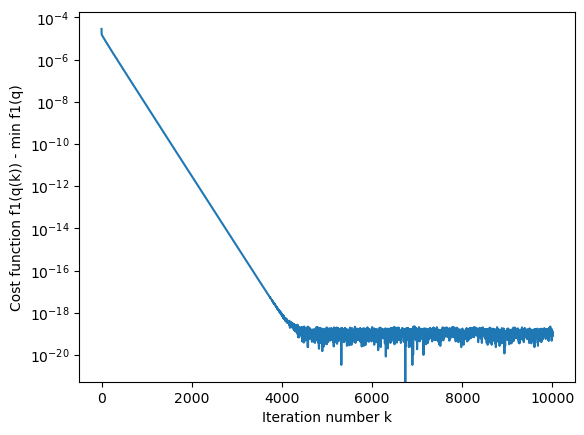

Calculating ellipsoid fit rmse...



100%|██████████| 37331/37331 [01:02<00:00, 599.14it/s]


Ellipsoid fit rmse is 2.2910768318232377 nm.
Ellipsoid fit: COP1 membrane axes is [33.72434203 23.75250964 24.94752177] nm
Ellipsoid fit: COP1 membrane Surface Area is 9423.319799385434 nm
Ellipsoid fit: COP1 membrane Volume is 83708.39363929864 nm
Sphericity index of best-fitting ellipsoid is 0.8752847668153915 for COP1 membrane.
Sphericity of best-fitting ellipsoid is 0.9820332663175192 for COP1 membrane.

{'Image_Name': 'High_mag_L12_P1_2_memb_7_9-COP1.mrc', 'Image_Tag': 'COP1', 'info': {'sphere_center': array([638.49905878, 536.88906247, 147.08495489]), 'sphere_radius': 26.105769322488474, 'sphere_rmse': 3.185739229037408, 'sphere_radius_nm': 26.105769322488474, 'ellipsoid_center': array([638.14373673, 537.54546184, 146.97879369]), 'ellipsoid_axes': array([33.72434203, 23.75250964, 24.94752177]), 'ellipsoid_rotmat': array([[-0.7286026 ,  0.02151175,  0.68459879],
       [ 0.6675234 ,  0.24624457,  0.70269205],
       [ 0.1534626 , -0.96896897,  0.19377403]]), 'ellipsoid_residual': 

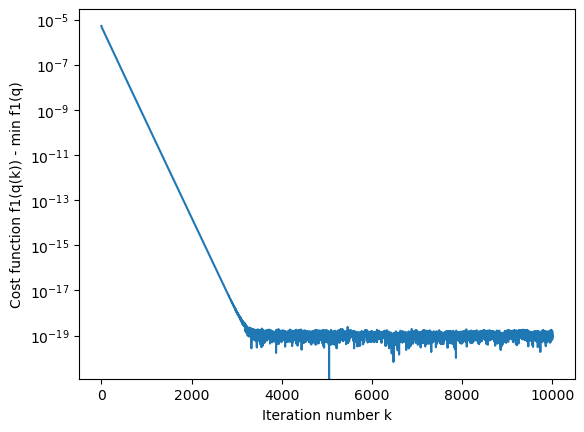

Calculating ellipsoid fit rmse...



100%|██████████| 111139/111139 [03:07<00:00, 593.21it/s]


Ellipsoid fit rmse is 2.6792664256792684 nm.
Ellipsoid fit: COP2 membrane axes is [33.9438938  35.36391273 36.69904654] nm
Ellipsoid fit: COP2 membrane Surface Area is 15687.337848027852 nm
Ellipsoid fit: COP2 membrane Volume is 184529.31120460192 nm
Sphericity index of best-fitting ellipsoid is 0.9611018418818884 for COP2 membrane.
Sphericity of best-fitting ellipsoid is 0.999183181214786 for COP2 membrane.

{'Image_Name': 'L17_LOW_3_HIGH_1_4_memb_39_1-COP2.mrc', 'Image_Tag': 'COP2', 'info': {'sphere_center': array([120.05811369, 296.2313213 , 168.86816682]), 'sphere_radius': 35.392161595604, 'sphere_rmse': 2.7790678851939252, 'sphere_radius_nm': 35.392161595604, 'ellipsoid_center': array([120.00639679, 296.32547877, 168.98241233]), 'ellipsoid_axes': array([33.9438938 , 35.36391273, 36.69904654]), 'ellipsoid_rotmat': array([[-0.54926324, -0.65420436,  0.51992937],
       [-0.75255006,  0.11675322, -0.64810269],
       [-0.36328818,  0.74725186,  0.55644978]]), 'ellipsoid_residual': 5.

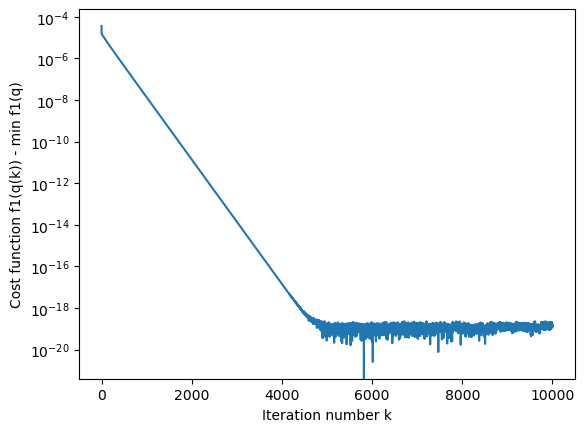

Calculating ellipsoid fit rmse...



100%|██████████| 87753/87753 [02:29<00:00, 585.12it/s]


Ellipsoid fit rmse is 2.844253980089825 nm.
Ellipsoid fit: COP2 membrane axes is [35.79572395 39.87490772 44.32067907] nm
Ellipsoid fit: COP2 membrane Surface Area is 20073.268886070648 nm
Ellipsoid fit: COP2 membrane Volume is 264987.78594397043 nm
Sphericity index of best-fitting ellipsoid is 0.898363436584509 for COP2 membrane.
Sphericity of best-fitting ellipsoid is 0.9939165602588769 for COP2 membrane.

{'Image_Name': 'L24_LOW_1_2_HIGH_1_6_memb_1_1-COP2.mrc', 'Image_Tag': 'COP2', 'info': {'sphere_center': array([214.70487946, 273.81844575, 180.08679005]), 'sphere_radius': 39.34511231965113, 'sphere_rmse': 3.320880957100725, 'sphere_radius_nm': 39.34511231965113, 'ellipsoid_center': array([214.3749383 , 272.64314335, 182.78459381]), 'ellipsoid_axes': array([35.79572395, 39.87490772, 44.32067907]), 'ellipsoid_rotmat': array([[-0.71588147, -0.31482173, -0.62321826],
       [-0.6424113 ,  0.64665983,  0.41126487],
       [-0.27353509, -0.69477935,  0.66517682]]), 'ellipsoid_residual':

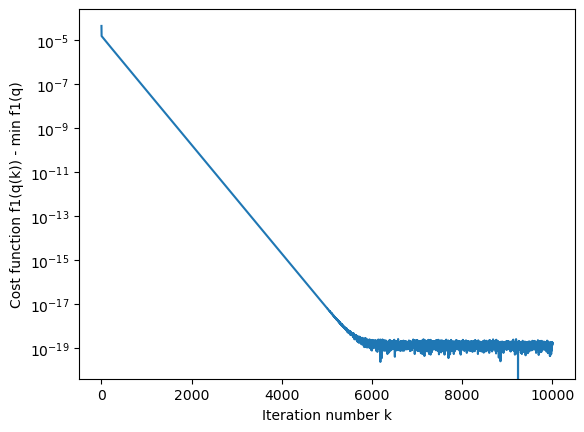

Calculating ellipsoid fit rmse...



100%|██████████| 39747/39747 [01:06<00:00, 599.15it/s]


Ellipsoid fit rmse is 2.4148051324012876 nm.
Ellipsoid fit: COP1 membrane axes is [28.7160967  30.02733197 35.4634622 ] nm
Ellipsoid fit: COP1 membrane Surface Area is 12367.511260184236 nm
Ellipsoid fit: COP1 membrane Volume is 128089.01742363804 nm
Sphericity index of best-fitting ellipsoid is 0.9182994245827819 for COP1 membrane.
Sphericity of best-fitting ellipsoid is 0.9935957827188231 for COP1 membrane.

{'Image_Name': 'L31_LOW_3_2_HIGH_1_memb_47_1-COP1.mrc', 'Image_Tag': 'COP1', 'info': {'sphere_center': array([559.45121384, 709.6775204 , 199.36088287]), 'sphere_radius': 30.85563043101053, 'sphere_rmse': 2.716373713044639, 'sphere_radius_nm': 30.85563043101053, 'ellipsoid_center': array([558.86735327, 709.6624664 , 200.89193928]), 'ellipsoid_axes': array([28.7160967 , 30.02733197, 35.4634622 ]), 'ellipsoid_rotmat': array([[ 0.91391794,  0.39074167, -0.10988602],
       [ 0.40574301, -0.87194709,  0.27400891],
       [-0.0112519 ,  0.29500714,  0.95542879]]), 'ellipsoid_residual'

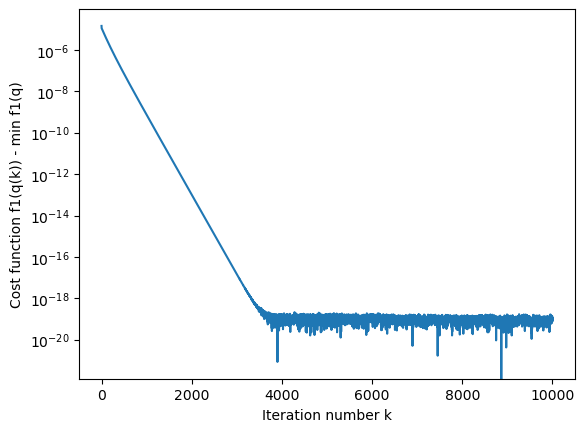

Calculating ellipsoid fit rmse...



100%|██████████| 91830/91830 [02:39<00:00, 576.41it/s]


Ellipsoid fit rmse is 2.5313373159088632 nm.
Ellipsoid fit: COP2 membrane axes is [44.86817935 33.66672872 31.87475931] nm
Ellipsoid fit: COP2 membrane Surface Area is 16917.41043299243 nm
Ellipsoid fit: COP2 membrane Volume is 201685.59938564728 nm
Sphericity index of best-fitting ellipsoid is 0.8761628211195704 for COP2 membrane.
Sphericity of best-fitting ellipsoid is 0.9831055896789956 for COP2 membrane.

{'Image_Name': 'L11_HIGH_3_7_memb_13_5-COP2.mrc', 'Image_Tag': 'COP2', 'info': {'sphere_center': array([393.05623582, 251.54823977, 262.99757678]), 'sphere_radius': 35.3782424024774, 'sphere_rmse': 3.768944996127811, 'sphere_radius_nm': 35.3782424024774, 'ellipsoid_center': array([393.71956341, 251.08664556, 260.65822009]), 'ellipsoid_axes': array([44.86817935, 33.66672872, 31.87475931]), 'ellipsoid_rotmat': array([[ 0.22918639, -0.16064233, -0.96003523],
       [ 0.81796265,  0.56642641,  0.1004899 ],
       [-0.52764638,  0.80830388, -0.26121665]]), 'ellipsoid_residual': 5.31327

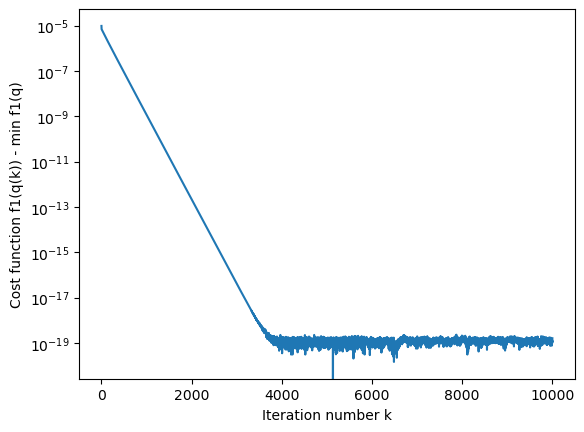

Calculating ellipsoid fit rmse...



100%|██████████| 127417/127417 [03:42<00:00, 573.60it/s]


Ellipsoid fit rmse is 2.7572708048127903 nm.
Ellipsoid fit: COP2 membrane axes is [48.38655783 35.19597854 38.90346128] nm
Ellipsoid fit: COP2 membrane Surface Area is 20859.111157174037 nm
Ellipsoid fit: COP2 membrane Volume is 277520.2155278859 nm
Sphericity index of best-fitting ellipsoid is 0.8698099524120714 for COP2 membrane.
Sphericity of best-fitting ellipsoid is 0.986396241505679 for COP2 membrane.

{'Image_Name': 'High_mag_L27_P1_2_memb_35_3-COP2.mrc', 'Image_Tag': 'COP2', 'info': {'sphere_center': array([370.91717972, 353.81843497, 265.12805393]), 'sphere_radius': 39.53567566349258, 'sphere_rmse': 3.702914556641428, 'sphere_radius_nm': 39.53567566349258, 'ellipsoid_center': array([372.01941656, 354.0074758 , 263.25390396]), 'ellipsoid_axes': array([48.38655783, 35.19597854, 38.90346128]), 'ellipsoid_rotmat': array([[-0.21153394,  0.11726271,  0.9703107 ],
       [ 0.97731524,  0.01480639,  0.21127161],
       [-0.01040748, -0.99299055,  0.11773469]]), 'ellipsoid_residual': 4

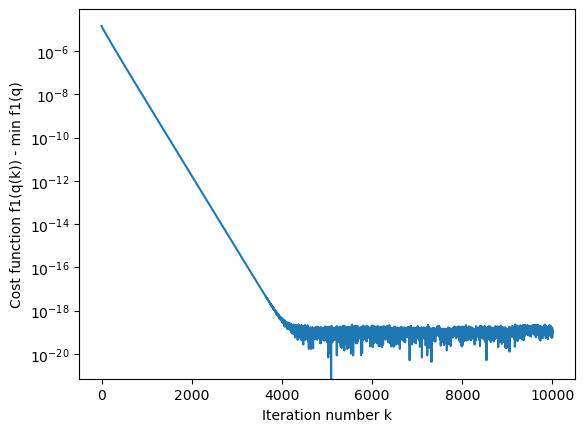

Calculating ellipsoid fit rmse...



 87%|████████▋ | 99025/113395 [02:51<00:23, 617.56it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████| 77815/77815 [02:10<00:00, 596.36it/s]


Ellipsoid fit rmse is 2.5563509608383557 nm.
Ellipsoid fit: COP2 membrane axes is [30.81326232 31.71125835 36.67181806] nm
Ellipsoid fit: COP2 membrane Surface Area is 13720.485098184625 nm
Ellipsoid fit: COP2 membrane Volume is 150097.06758795033 nm
Sphericity index of best-fitting ellipsoid is 0.9346373846258237 for COP2 membrane.
Sphericity of best-fitting ellipsoid is 0.9954729492563499 for COP2 membrane.

{'Image_Name': 'L25_LOW_1_3_HIGH_1_2_memb_3_1-COP2.mrc', 'Image_Tag': 'COP2', 'info': {'sphere_center': array([ 61.72411383, 605.54330752, 191.76185417]), 'sphere_radius': 32.312469982922664, 'sphere_rmse': 2.830083349925644, 'sphere_radius_nm': 32.312469982922664, 'ellipsoid_center': array([ 61.88247113, 605.83324208, 190.8998749 ]), 'ellipsoid_axes': array([30.81326232, 31.71125835, 36.67181806]), 'ellipsoid_rotmat': array([[ 0.829481  , -0.55843475,  0.01057863],
       [-0.55059863, -0.82072959, -0.15246011],
       [-0.09382122, -0.12063818,  0.98825301]]), 'ellipsoid_residu

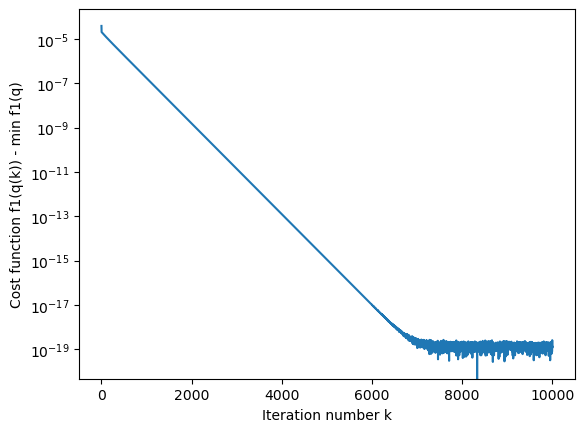

Calculating ellipsoid fit rmse...



100%|██████████| 27537/27537 [00:45<00:00, 601.57it/s]


Ellipsoid fit rmse is 2.5182038502117075 nm.
Ellipsoid fit: COP2 membrane axes is [32.18154207 27.8355554  21.37753732] nm
Ellipsoid fit: COP2 membrane Surface Area is 9208.782145385785 nm
Ellipsoid fit: COP2 membrane Volume is 80214.52654918477 nm
Sphericity index of best-fitting ellipsoid is 0.7990418659812774 for COP2 membrane.
Sphericity of best-fitting ellipsoid is 0.9767511741298793 for COP2 membrane.

{'Image_Name': 'L24_LOW_1_5_HIGH_1_5_memb_1_1-COP2.mrc', 'Image_Tag': 'COP2', 'info': {'sphere_center': array([333.32447944, 663.45352621, 104.14352007]), 'sphere_radius': 25.265649184526968, 'sphere_rmse': 3.3434089750503087, 'sphere_radius_nm': 25.265649184526968, 'ellipsoid_center': array([335.29232502, 663.37275114, 106.29069963]), 'ellipsoid_axes': array([32.18154207, 27.8355554 , 21.37753732]), 'ellipsoid_rotmat': array([[-0.5805882 ,  0.23938186, -0.77821184],
       [ 0.81341532,  0.12865248, -0.56727776],
       [ 0.03567712,  0.96236421,  0.26941098]]), 'ellipsoid_residua

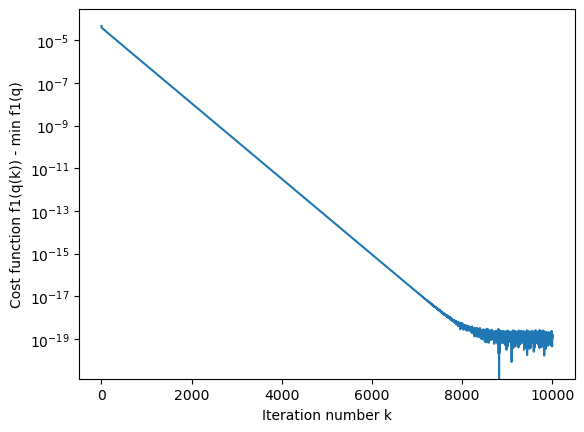

Calculating ellipsoid fit rmse...



100%|██████████| 30463/30463 [00:56<00:00, 535.59it/s]


Ellipsoid fit rmse is 2.1096971214821227 nm.
Ellipsoid fit: COP1 membrane axes is [36.71200005 43.58811624 58.09311008] nm
Ellipsoid fit: COP1 membrane Surface Area is 26510.438994675515 nm
Ellipsoid fit: COP1 membrane Volume is 389394.11406602163 nm
Sphericity index of best-fitting ellipsoid is 0.8104155911096189 for COP1 membrane.
Sphericity of best-fitting ellipsoid is 0.9727325757011883 for COP1 membrane.

{'Image_Name': 'L29_LOW_2_2_HIGH_1_3_memb_7_2-COP1.mrc', 'Image_Tag': 'COP1', 'info': {'sphere_center': array([165.47214044, 783.68414507, 149.735047  ]), 'sphere_radius': 37.819182660654036, 'sphere_rmse': 2.718530976113699, 'sphere_radius_nm': 37.819182660654036, 'ellipsoid_center': array([160.53104271, 785.75084759, 149.01555294]), 'ellipsoid_axes': array([36.71200005, 43.58811624, 58.09311008]), 'ellipsoid_rotmat': array([[ 0.35371177,  0.93534112,  0.00499661],
       [ 0.934721  , -0.3532706 , -0.03868508],
       [ 0.03441859, -0.01835381,  0.99923896]]), 'ellipsoid_residu

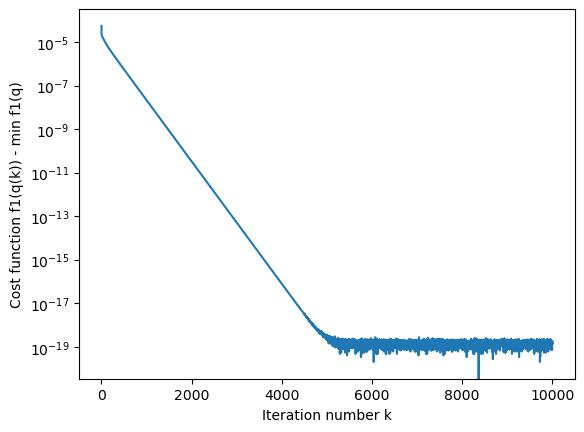

Calculating ellipsoid fit rmse...



100%|██████████| 6673/6673 [00:10<00:00, 623.54it/s]


Ellipsoid fit rmse is 2.3556672605700926 nm.
Ellipsoid fit: COP1 membrane axes is [20.89178375 15.23354151  8.23239426] nm
Ellipsoid fit: COP1 membrane Surface Area is 2700.3385743498457 nm
Ellipsoid fit: COP1 membrane Volume is 10974.662487371683 nm
Sphericity index of best-fitting ellipsoid is 0.5971617381885121 for COP1 membrane.
Sphericity of best-fitting ellipsoid is 0.884422982143236 for COP1 membrane.

{'Image_Name': 'L29_LOW_2_2_HIGH_1_3_memb_7_5-COP1.mrc', 'Image_Tag': 'COP1', 'info': {'sphere_center': array([384.32581202, 226.28788091, 110.5701799 ]), 'sphere_radius': 23.992778272555146, 'sphere_rmse': 2.394372881365725, 'sphere_radius_nm': 23.992778272555146, 'ellipsoid_center': array([384.20708585, 211.58959989, 113.86053973]), 'ellipsoid_axes': array([20.89178375, 15.23354151,  8.23239426]), 'ellipsoid_rotmat': array([[-0.7905177 ,  0.08169957,  0.60696536],
       [ 0.6121982 ,  0.07761358,  0.78688595],
       [-0.01717949, -0.99363037,  0.11137123]]), 'ellipsoid_residua

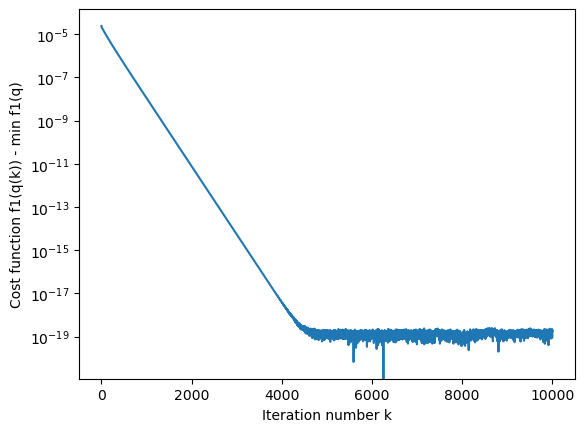

Calculating ellipsoid fit rmse...



100%|██████████| 94955/94955 [02:37<00:00, 603.52it/s]s]


Ellipsoid fit rmse is 2.518495388157763 nm.
Ellipsoid fit: COP2 membrane axes is [31.22482214 31.99267122 32.45338677] nm
Ellipsoid fit: COP2 membrane Surface Area is 12779.258916079747 nm
Ellipsoid fit: COP2 membrane Volume is 135799.79401471667 nm
Sphericity index of best-fitting ellipsoid is 0.9792565219856483 for COP2 membrane.
Sphericity of best-fitting ellipsoid is 0.9997955420614155 for COP2 membrane.

{'Image_Name': 'L31_LOW_3_2_HIGH_1_memb_39_2-COP2.mrc', 'Image_Tag': 'COP2', 'info': {'sphere_center': array([420.00745196, 291.24334918, 255.46059081]), 'sphere_radius': 31.807951903484163, 'sphere_rmse': 2.531804429512217, 'sphere_radius_nm': 31.807951903484163, 'ellipsoid_center': array([420.08318301, 291.41603947, 255.26511639]), 'ellipsoid_axes': array([31.22482214, 31.99267122, 32.45338677]), 'ellipsoid_rotmat': array([[-0.72289924,  0.30874968, -0.61813455],
       [ 0.61703587,  0.69105619, -0.37644132],
       [-0.31093957,  0.65354034,  0.69007363]]), 'ellipsoid_residual

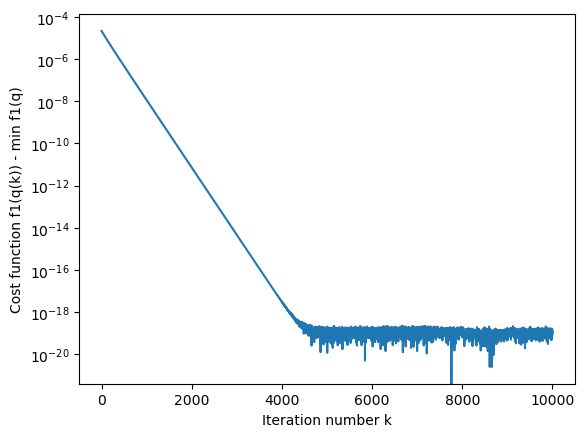

Calculating ellipsoid fit rmse...



 85%|████████▍ | 84413/99448 [02:31<00:30, 500.83it/s]

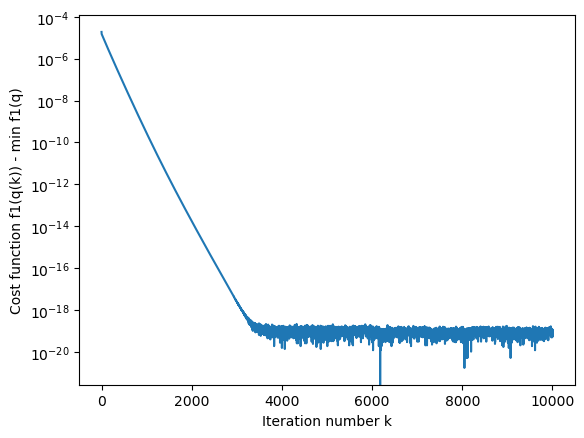

Calculating ellipsoid fit rmse...



100%|██████████| 79511/79511 [02:12<00:00, 601.65it/s]


Ellipsoid fit rmse is 2.9000622740626634 nm.
Ellipsoid fit: COP2 membrane axes is [42.46122813 30.13222525 30.7392687 ] nm
Ellipsoid fit: COP2 membrane Surface Area is 14805.282344289697 nm
Ellipsoid fit: COP2 membrane Volume is 164742.59290320432 nm
Sphericity index of best-fitting ellipsoid is 0.8860511141515485 for COP2 membrane.
Sphericity of best-fitting ellipsoid is 0.9816078629267935 for COP2 membrane.

{'Image_Name': 'L19_LOW_1_6_HIGH_1_2_memb_13_3-COP2.mrc', 'Image_Tag': 'COP2', 'info': {'sphere_center': array([344.0030928 , 474.36173116, 261.57567278]), 'sphere_radius': 32.603731817134566, 'sphere_rmse': 3.7422696800319972, 'sphere_radius_nm': 32.603731817134566, 'ellipsoid_center': array([343.01751392, 474.54995765, 264.51165497]), 'ellipsoid_axes': array([42.46122813, 30.13222525, 30.7392687 ]), 'ellipsoid_rotmat': array([[-0.31342139, -0.09226094,  0.94512166],
       [-0.89703063,  0.35535991, -0.2627839 ],
       [ 0.31161366,  0.93016517,  0.19413829]]), 'ellipsoid_resi

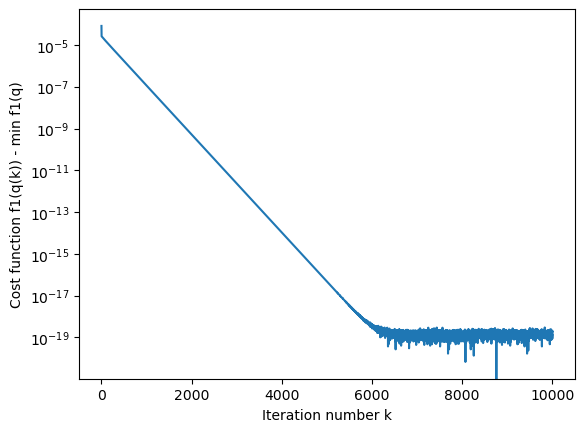

Calculating ellipsoid fit rmse...



100%|██████████| 22962/22962 [00:39<00:00, 581.33it/s]


Ellipsoid fit rmse is 2.1467410436727503 nm.
Ellipsoid fit: COP1 membrane axes is [37.03704513 26.32625498 27.9014918 ] nm
Ellipsoid fit: COP1 membrane Surface Area is 11560.340409090799 nm
Ellipsoid fit: COP1 membrane Volume is 113957.11540136274 nm
Sphericity index of best-fitting ellipsoid is 0.8753293093232558 for COP1 membrane.
Sphericity of best-fitting ellipsoid is 0.9832737989707947 for COP1 membrane.

{'Image_Name': 'L29_LOW_2_2_HIGH_1_3_memb_56_1-COP1.mrc', 'Image_Tag': 'COP1', 'info': {'sphere_center': array([230.56772981, 724.00446174,  87.44189015]), 'sphere_radius': 27.870513226245624, 'sphere_rmse': 2.528197132414147, 'sphere_radius_nm': 27.870513226245624, 'ellipsoid_center': array([230.17638974, 725.00891433,  82.49550136]), 'ellipsoid_axes': array([37.03704513, 26.32625498, 27.9014918 ]), 'ellipsoid_rotmat': array([[-0.20395117,  0.09604989, -0.97425784],
       [ 0.96324837,  0.19738426, -0.18218677],
       [-0.17480415,  0.97560949,  0.13277665]]), 'ellipsoid_resid

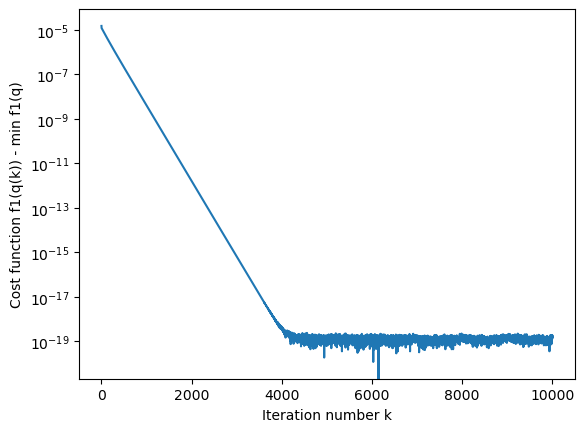

Calculating ellipsoid fit rmse...



 47%|████▋     | 20612/44050 [00:33<00:38, 616.23it/s]

Saved plot to: /nemo/lab/zanettig/home/users/downesk/Tomography/27FEB25/analysis/vesicles_seg/outputs/L11_HIGH_3_7_memb_5_3-COP2.mrc_input.png

Fitting of refined COP2 points.
Sphere fit: COP2 membrane radius is 32.45397491241937 nm
Sphere fit error is 3.3012132005836854 nm

Ellipsoid fitting


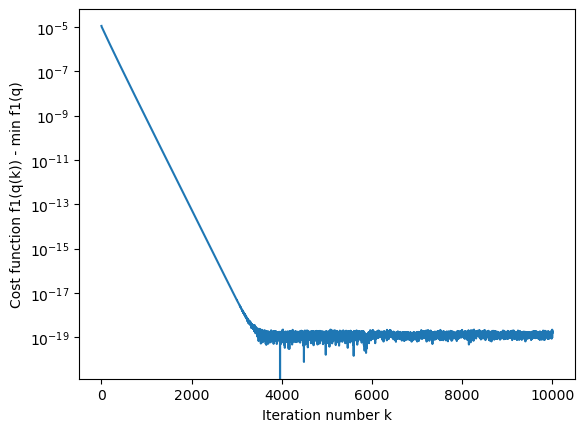

Calculating ellipsoid fit rmse...



100%|██████████| 84274/84274 [02:20<00:00, 598.14it/s]


Ellipsoid fit rmse is 2.3156948557058654 nm.
Ellipsoid fit: COP2 membrane axes is [32.9546178  34.10042619 35.13239712] nm
Ellipsoid fit: COP2 membrane Surface Area is 14578.223661776743 nm
Ellipsoid fit: COP2 membrane Volume is 165375.9981401001 nm
Sphericity index of best-fitting ellipsoid is 0.9678060279043625 for COP2 membrane.
Sphericity of best-fitting ellipsoid is 0.9994502197205895 for COP2 membrane.

{'Image_Name': 'L17_LOW_1_2_HIGH_1_memb_66_1-COP2.mrc', 'Image_Tag': 'COP2', 'info': {'sphere_center': array([570.98463541, 717.56343938, 205.95606042]), 'sphere_radius': 33.810943154218734, 'sphere_rmse': 2.3643406181381756, 'sphere_radius_nm': 33.810943154218734, 'ellipsoid_center': array([570.9197642 , 717.65196027, 205.40006115]), 'ellipsoid_axes': array([32.9546178 , 34.10042619, 35.13239712]), 'ellipsoid_rotmat': array([[ 0.18494401, -0.97676399, -0.10829504],
       [-0.98136877, -0.18939788,  0.03230756],
       [ 0.05206771, -0.10030228,  0.99359368]]), 'ellipsoid_residua

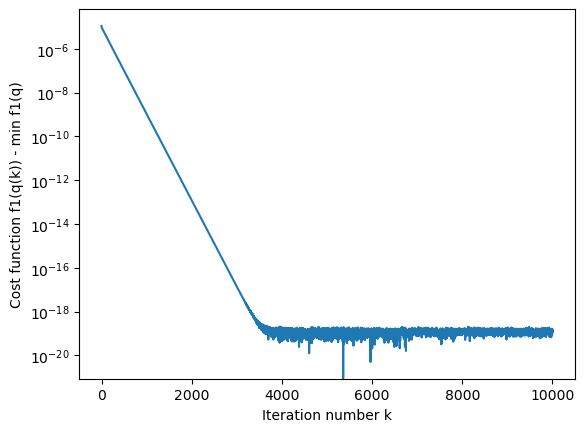

Calculating ellipsoid fit rmse...



100%|██████████| 102515/102515 [02:54<00:00, 586.66it/s]


Ellipsoid fit rmse is 2.518256138536738 nm.
Ellipsoid fit: COP1 membrane axes is [42.26212852 35.28430283 34.91604912] nm
Ellipsoid fit: COP1 membrane Surface Area is 17626.62340907807 nm
Ellipsoid fit: COP1 membrane Volume is 218095.45349576307 nm
Sphericity index of best-fitting ellipsoid is 0.9350591724073591 for COP1 membrane.
Sphericity of best-fitting ellipsoid is 0.9940603237269867 for COP1 membrane.

{'Image_Name': 'L17_LOW_3_HIGH_1_4_memb_30_1-COP1.mrc', 'Image_Tag': 'COP1', 'info': {'sphere_center': array([ 85.37923508, 209.95871038, 148.17196809]), 'sphere_radius': 36.25934501142623, 'sphere_rmse': 2.868117860062082, 'sphere_radius_nm': 36.25934501142623, 'ellipsoid_center': array([ 85.5823846 , 209.80886773, 149.73521358]), 'ellipsoid_axes': array([42.26212852, 35.28430283, 34.91604912]), 'ellipsoid_rotmat': array([[-0.12528891, -0.03014729,  0.99166216],
       [-0.99069529, -0.04975153, -0.12667924],
       [-0.05315574,  0.99830653,  0.02363346]]), 'ellipsoid_residual': 

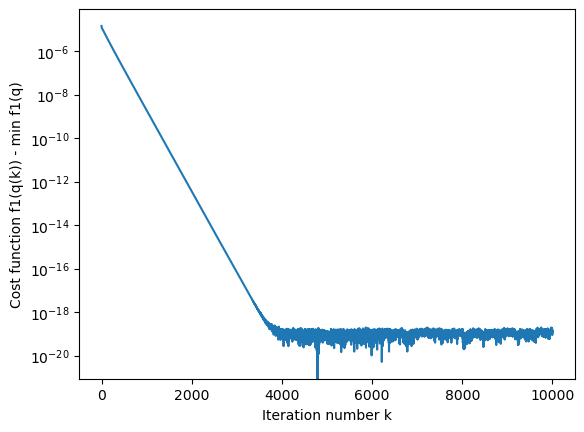

Calculating ellipsoid fit rmse...



 89%|████████▉ | 60611/68203 [01:41<00:12, 622.87it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████| 60679/60679 [01:46<00:00, 569.51it/s]


Ellipsoid fit rmse is 2.851343316750154 nm.
Ellipsoid fit: COP2 membrane axes is [31.85348183 53.03893115 47.23910797] nm
Ellipsoid fit: COP2 membrane Surface Area is 24247.274927853778 nm
Ellipsoid fit: COP2 membrane Volume is 334304.3070167608 nm
Sphericity index of best-fitting ellipsoid is 0.7398422407494519 for COP2 membrane.
Sphericity of best-fitting ellipsoid is 0.960688301692723 for COP2 membrane.

{'Image_Name': 'L17_LOW_3_HIGH_1_memb_3_2-COP2.mrc', 'Image_Tag': 'COP2', 'info': {'sphere_center': array([421.67624444, 413.67349201, 169.0400222 ]), 'sphere_radius': 40.68393702412989, 'sphere_rmse': 4.320197260916703, 'sphere_radius_nm': 40.68393702412989, 'ellipsoid_center': array([411.71304137, 416.11764575, 172.83530704]), 'ellipsoid_axes': array([31.85348183, 53.03893115, 47.23910797]), 'ellipsoid_rotmat': array([[-0.08654223,  0.93924395,  0.33216146],
       [ 0.88469845,  0.22575278, -0.40785332],
       [ 0.45806014, -0.25856619,  0.85048482]]), 'ellipsoid_residual': 1.39

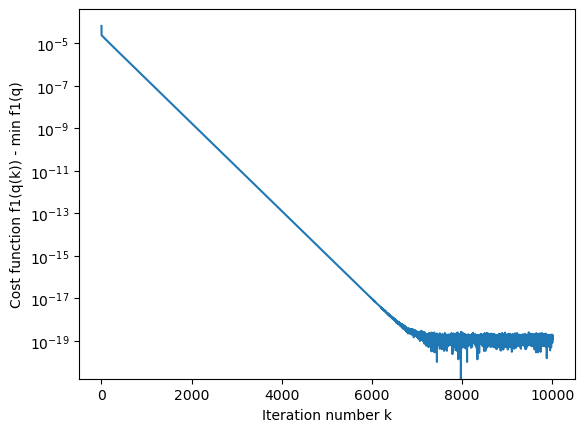

Calculating ellipsoid fit rmse...



100%|██████████| 36309/36309 [01:03<00:00, 573.48it/s]


Ellipsoid fit rmse is 2.4939276081723127 nm.
Ellipsoid fit: COP1 membrane axes is [59.99117933 34.0305769  39.79034844] nm
Ellipsoid fit: COP1 membrane Surface Area is 24591.203681159142 nm
Ellipsoid fit: COP1 membrane Volume is 340269.5310859402 nm
Sphericity index of best-fitting ellipsoid is 0.785762250059011 for COP1 membrane.
Sphericity of best-fitting ellipsoid is 0.9584873362973585 for COP1 membrane.

{'Image_Name': 'L17_LOW_3_HIGH_1_memb_8_1-COP1.mrc', 'Image_Tag': 'COP1', 'info': {'sphere_center': array([434.34482802, 467.20026536, 273.78508504]), 'sphere_radius': 30.690910340721953, 'sphere_rmse': 3.08805663325312, 'sphere_radius_nm': 30.690910340721953, 'ellipsoid_center': array([410.83176109, 481.14793587, 273.10790918]), 'ellipsoid_axes': array([59.99117933, 34.0305769 , 39.79034844]), 'ellipsoid_rotmat': array([[-0.84695836,  0.53104084, -0.02563514],
       [ 0.52429736,  0.84225532,  0.12537247],
       [-0.08816923, -0.09274483,  0.9917785 ]]), 'ellipsoid_residual': 1.

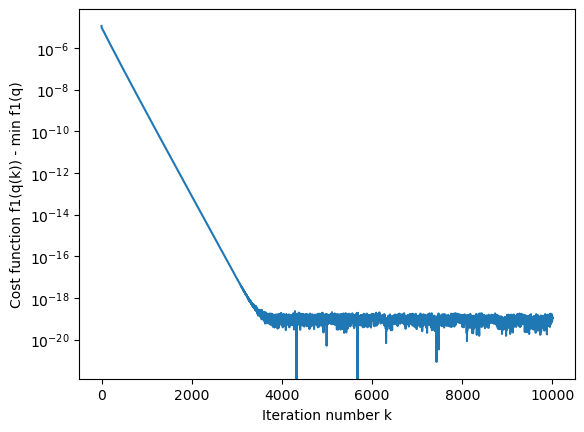

Calculating ellipsoid fit rmse...



100%|██████████| 90256/90256 [02:33<00:00, 586.22it/s]


Ellipsoid fit rmse is 2.6528262698917957 nm.
Ellipsoid fit: COP2 membrane axes is [40.06660083 32.84852156 33.05941623] nm
Ellipsoid fit: COP2 membrane Surface Area is 15648.052153695671 nm
Ellipsoid fit: COP2 membrane Volume is 182256.1184991958 nm
Sphericity index of best-fitting ellipsoid is 0.9339378829362777 for COP2 membrane.
Sphericity of best-fitting ellipsoid is 0.9934482540115019 for COP2 membrane.

{'Image_Name': 'L34_LOW_1_5_HIGH_1_4_memb_25_1-COP2.mrc', 'Image_Tag': 'COP2', 'info': {'sphere_center': array([205.665159  , 664.35312924, 308.43963105]), 'sphere_radius': 34.19494694343883, 'sphere_rmse': 3.015517497927125, 'sphere_radius_nm': 34.19494694343883, 'ellipsoid_center': array([205.1986407 , 664.52506424, 307.64101659]), 'ellipsoid_axes': array([40.06660083, 32.84852156, 33.05941623]), 'ellipsoid_rotmat': array([[-0.09593664, -0.00901574, -0.99534661],
       [ 0.94592986,  0.31045674, -0.09398568],
       [-0.30985942,  0.95054475,  0.02125592]]), 'ellipsoid_residual

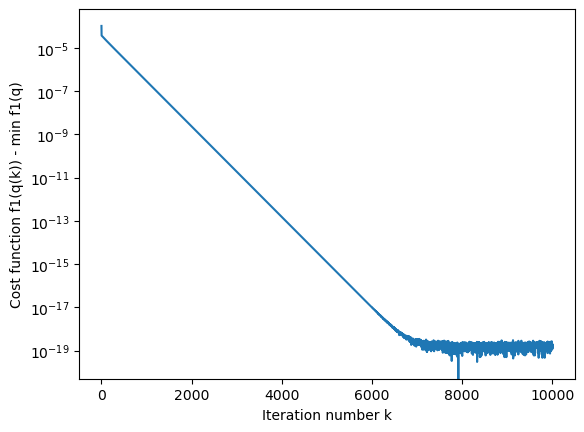

Calculating ellipsoid fit rmse...



100%|██████████| 32294/32294 [01:01<00:00, 527.82it/s]


Ellipsoid fit rmse is 2.3989449265604144 nm.
Ellipsoid fit: COP2 membrane axes is [42.24588216 55.52423201 69.38266142] nm
Ellipsoid fit: COP2 membrane Surface Area is 38718.97701914923 nm
Ellipsoid fit: COP2 membrane Volume is 681720.7412805163 nm
Sphericity index of best-fitting ellipsoid is 0.7737697557274219 for COP2 membrane.
Sphericity of best-fitting ellipsoid is 0.9674560728558079 for COP2 membrane.

{'Image_Name': 'L17_LOW_1_2_HIGH_1_4_memb_59_1-COP2.mrc', 'Image_Tag': 'COP2', 'info': {'sphere_center': array([342.98161025, 116.15270415, 159.82215794]), 'sphere_radius': 36.11221780792945, 'sphere_rmse': 2.7948051425331033, 'sphere_radius_nm': 36.11221780792945, 'ellipsoid_center': array([352.10639488,  86.8768442 , 149.05513336]), 'ellipsoid_axes': array([42.24588216, 55.52423201, 69.38266142]), 'ellipsoid_rotmat': array([[-0.89866683, -0.36448917,  0.2440196 ],
       [-0.36753406,  0.32207675, -0.87245933],
       [-0.23940894,  0.87373578,  0.42340188]]), 'ellipsoid_residual

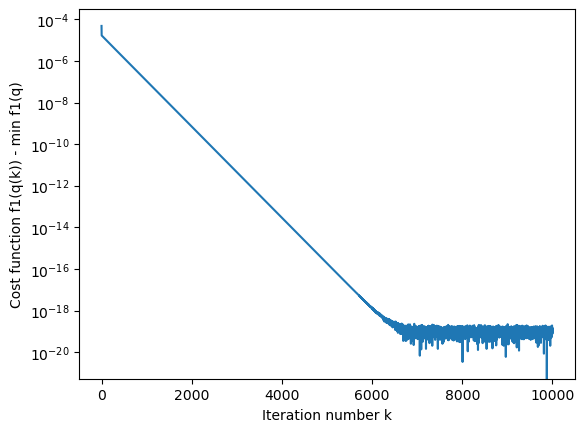

Calculating ellipsoid fit rmse...



100%|██████████| 67688/67688 [01:58<00:00, 569.84it/s]


Ellipsoid fit rmse is 2.488210221865907 nm.
Ellipsoid fit: COP1 membrane axes is [36.47650507 47.49034986 41.14433784] nm
Ellipsoid fit: COP1 membrane Surface Area is 21803.00984492974 nm
Ellipsoid fit: COP1 membrane Volume is 298550.1379318878 nm
Sphericity index of best-fitting ellipsoid is 0.8797723964389971 for COP1 membrane.
Sphericity of best-fitting ellipsoid is 0.990784470911719 for COP1 membrane.

{'Image_Name': 'L7_LOW_1_3_HIGH_1_memb_16_3-COP1.mrc', 'Image_Tag': 'COP1', 'info': {'sphere_center': array([274.08505471, 599.28933171, 150.43561336]), 'sphere_radius': 38.661842864784, 'sphere_rmse': 3.231072532310191, 'sphere_radius_nm': 38.661842864784, 'ellipsoid_center': array([277.06719831, 602.13884257, 149.71042794]), 'ellipsoid_axes': array([36.47650507, 47.49034986, 41.14433784]), 'ellipsoid_rotmat': array([[-0.66085024,  0.74963166, -0.03646015],
       [ 0.61641938,  0.56984521,  0.54341842],
       [-0.42814029, -0.33664345,  0.83866982]]), 'ellipsoid_residual': 7.28897

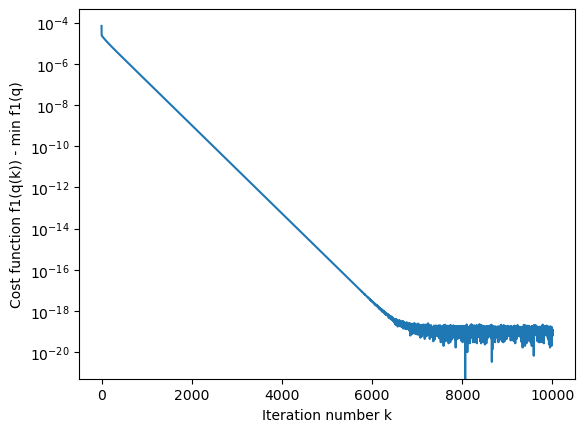

Calculating ellipsoid fit rmse...



100%|██████████| 20624/20624 [00:33<00:00, 610.60it/s]


Ellipsoid fit rmse is 2.4449946823722466 nm.
Ellipsoid fit: COP1 membrane axes is [33.37607801 23.15052093 25.66316001] nm
Ellipsoid fit: COP1 membrane Surface Area is 9375.178804405195 nm
Ellipsoid fit: COP1 membrane Volume is 83060.55158329687 nm
Sphericity index of best-fitting ellipsoid is 0.8553135797661671 for COP1 membrane.
Sphericity of best-fitting ellipsoid is 0.9819765248166494 for COP1 membrane.

{'Image_Name': 'L39_LOW_1_5_HIGH_1_5_memb_37_1-COP1.mrc', 'Image_Tag': 'COP1', 'info': {'sphere_center': array([857.18925276, 573.98868237, 180.29657724]), 'sphere_radius': 30.828546196146956, 'sphere_rmse': 2.939009188443709, 'sphere_radius_nm': 30.828546196146956, 'ellipsoid_center': array([851.3055779 , 571.53593459, 182.61260199]), 'ellipsoid_axes': array([33.37607801, 23.15052093, 25.66316001]), 'ellipsoid_rotmat': array([[-0.36677643,  0.66761874, -0.64788908],
       [ 0.92807871,  0.31077455, -0.20515624],
       [-0.06438129,  0.67653854,  0.73358752]]), 'ellipsoid_residua

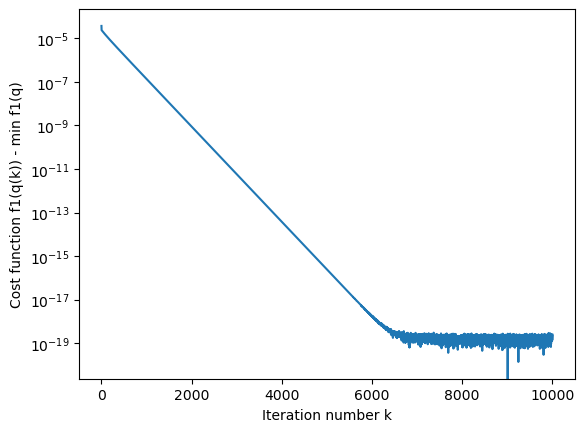

Calculating ellipsoid fit rmse...



100%|██████████| 40379/40379 [01:08<00:00, 590.32it/s]


Ellipsoid fit rmse is 2.683166936065185 nm.
Ellipsoid fit: COP1 membrane axes is [40.66530939 31.67462029 35.01034704] nm
Ellipsoid fit: COP1 membrane Surface Area is 16054.033404937492 nm
Ellipsoid fit: COP1 membrane Volume is 188895.02641833088 nm
Sphericity index of best-fitting ellipsoid is 0.8898854638546134 for COP1 membrane.
Sphericity of best-fitting ellipsoid is 0.9916999947705463 for COP1 membrane.

{'Image_Name': 'High_mag_L27_P1_2_memb_19_1-COP1.mrc', 'Image_Tag': 'COP1', 'info': {'sphere_center': array([160.4686631 , 298.21447375, 268.72145086]), 'sphere_radius': 33.4822538376961, 'sphere_rmse': 3.1013119146201324, 'sphere_radius_nm': 33.4822538376961, 'ellipsoid_center': array([158.60522565, 301.08613457, 269.9845635 ]), 'ellipsoid_axes': array([40.66530939, 31.67462029, 35.01034704]), 'ellipsoid_rotmat': array([[ 0.48782193, -0.78761704, -0.37641622],
       [-0.81567736, -0.56487276,  0.12485676],
       [ 0.31096658, -0.24612632,  0.9179987 ]]), 'ellipsoid_residual': 8

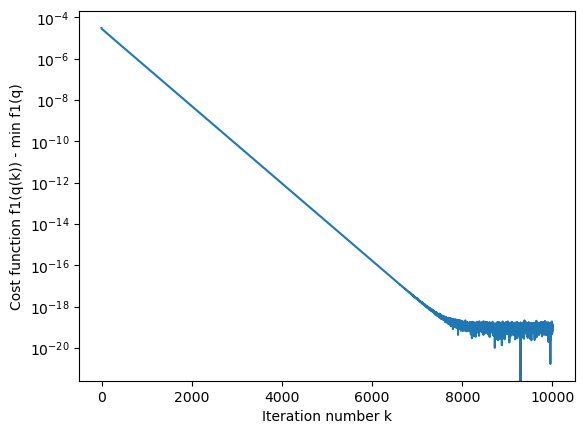

Calculating ellipsoid fit rmse...



100%|██████████| 21760/21760 [00:37<00:00, 587.03it/s]


Ellipsoid fit rmse is 1.9762056824959366 nm.
Ellipsoid fit: COP1 membrane axes is [37.51888525 26.75776475 29.97139121] nm
Ellipsoid fit: COP1 membrane Surface Area is 12344.280845340509 nm
Ellipsoid fit: COP1 membrane Volume is 126036.19089740733 nm
Sphericity index of best-fitting ellipsoid is 0.8602954206524774 for COP1 membrane.
Sphericity of best-fitting ellipsoid is 0.9848010664272314 for COP1 membrane.

{'Image_Name': 'L17_LOW_1_2_HIGH_1_4_memb_2_3-COP1.mrc', 'Image_Tag': 'COP1', 'info': {'sphere_center': array([355.51088138, 259.95749157, 267.0311609 ]), 'sphere_radius': 28.142887009989245, 'sphere_rmse': 2.4855425662081747, 'sphere_radius_nm': 28.142887009989245, 'ellipsoid_center': array([353.12258839, 264.60618563, 267.33353835]), 'ellipsoid_axes': array([37.51888525, 26.75776475, 29.97139121]), 'ellipsoid_rotmat': array([[-0.47202037,  0.87604811,  0.09867358],
       [ 0.87904302,  0.47619849, -0.02276773],
       [ 0.06693384, -0.07599149,  0.99485936]]), 'ellipsoid_resid

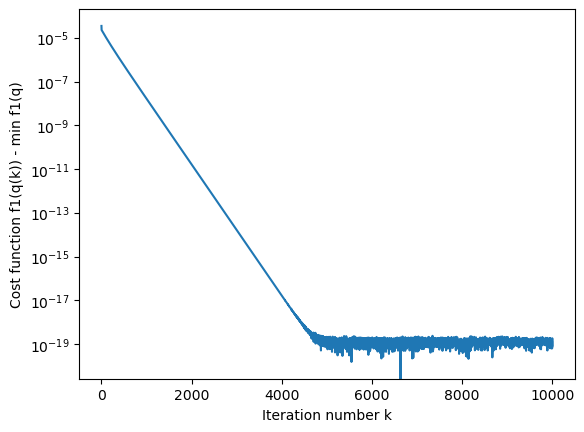

Calculating ellipsoid fit rmse...



100%|██████████| 41049/41049 [01:11<00:00, 570.57it/s]


Ellipsoid fit rmse is 2.283002959341421 nm.
Ellipsoid fit: COP1 membrane axes is [27.00676336 33.01638026 40.52056662] nm
Ellipsoid fit: COP1 membrane Surface Area is 14037.134566086981 nm
Ellipsoid fit: COP1 membrane Volume is 151344.31632823052 nm
Sphericity index of best-fitting ellipsoid is 0.816920955861554 for COP1 membrane.
Sphericity of best-fitting ellipsoid is 0.9783999123488982 for COP1 membrane.

{'Image_Name': 'L11_HIGH_3_7_memb_18_1-COP1.mrc', 'Image_Tag': 'COP1', 'info': {'sphere_center': array([314.0730444 , 667.84923016, 156.8033308 ]), 'sphere_radius': 30.67812204585429, 'sphere_rmse': 3.355467324557265, 'sphere_radius_nm': 30.67812204585429, 'ellipsoid_center': array([315.4173107 , 667.70803097, 155.61240174]), 'ellipsoid_axes': array([27.00676336, 33.01638026, 40.52056662]), 'ellipsoid_rotmat': array([[ 0.29919966,  0.95149894,  0.0716193 ],
       [ 0.94921485, -0.28914478, -0.12404218],
       [ 0.09731766, -0.10509549,  0.98968895]]), 'ellipsoid_residual': 6.3636

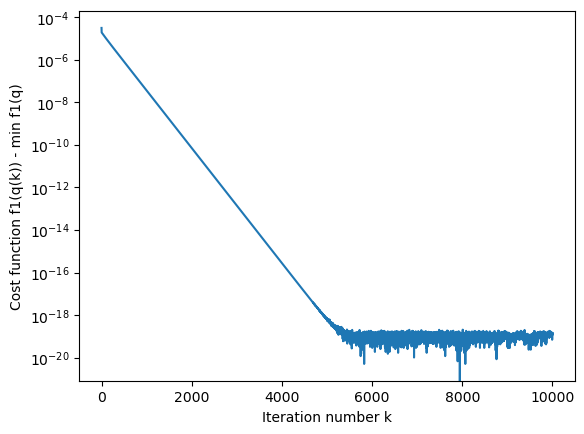

Calculating ellipsoid fit rmse...



100%|██████████| 42092/42092 [01:07<00:00, 624.28it/s]


Ellipsoid fit rmse is 2.8329766981438653 nm.
Ellipsoid fit: COP1 membrane axes is [26.15074637 33.57260739 29.279835  ] nm
Ellipsoid fit: COP1 membrane Surface Area is 11036.774187632833 nm
Ellipsoid fit: COP1 membrane Volume is 107677.85479878061 nm
Sphericity index of best-fitting ellipsoid is 0.886077060879767 for COP1 membrane.
Sphericity of best-fitting ellipsoid is 0.9917287359405254 for COP1 membrane.

{'Image_Name': 'L7_LOW_1_3_HIGH_1_memb_16_1-COP1.mrc', 'Image_Tag': 'COP1', 'info': {'sphere_center': array([399.4717238 , 491.86879198, 287.80737438]), 'sphere_radius': 27.731079630578808, 'sphere_rmse': 3.1848196120584484, 'sphere_radius_nm': 27.731079630578808, 'ellipsoid_center': array([400.35135418, 495.38612217, 287.07182669]), 'ellipsoid_axes': array([26.15074637, 33.57260739, 29.279835  ]), 'ellipsoid_rotmat': array([[-0.9145937 ,  0.05787354, -0.40021122],
       [ 0.23231144,  0.88528003, -0.40287797],
       [-0.33098302,  0.4614433 ,  0.82311623]]), 'ellipsoid_residual

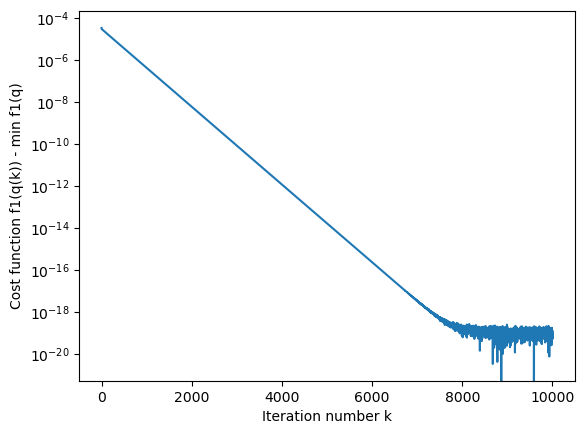

Calculating ellipsoid fit rmse...



100%|██████████| 9245/9245 [00:15<00:00, 583.37it/s]


Ellipsoid fit rmse is 1.6900717452716578 nm.
Ellipsoid fit: COP1 membrane axes is [21.82756524 23.42577778 30.46435973] nm
Ellipsoid fit: COP1 membrane Surface Area is 7962.0336570566005 nm
Ellipsoid fit: COP1 membrane Volume is 65249.919233859895 nm
Sphericity index of best-fitting ellipsoid is 0.8739934379261646 for COP1 membrane.
Sphericity of best-fitting ellipsoid is 0.9844192577401374 for COP1 membrane.

{'Image_Name': 'L39_LOW_1_7_HIGH_1_memb_58_1-COP1.mrc', 'Image_Tag': 'COP1', 'info': {'sphere_center': array([433.4300774 , 550.76915376, 213.84842352]), 'sphere_radius': 22.95644375100775, 'sphere_rmse': 1.895258758809522, 'sphere_radius_nm': 22.95644375100775, 'ellipsoid_center': array([433.31014291, 549.95395866, 213.34070043]), 'ellipsoid_axes': array([21.82756524, 23.42577778, 30.46435973]), 'ellipsoid_rotmat': array([[ 0.80777869, -0.58944251,  0.00714929],
       [-0.58286759, -0.79683861,  0.15910251],
       [ 0.08808496,  0.1326867 ,  0.98723618]]), 'ellipsoid_residual'

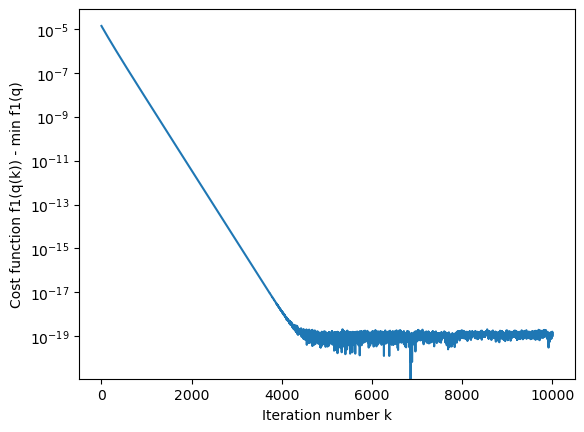

Calculating ellipsoid fit rmse...



100%|██████████| 56330/56330 [01:36<00:00, 585.17it/s]


Ellipsoid fit rmse is 2.241344122056721 nm.
Ellipsoid fit: COP2 membrane axes is [27.97149571 29.03833238 38.35094533] nm
Ellipsoid fit: COP2 membrane Surface Area is 12629.42072870208 nm
Ellipsoid fit: COP2 membrane Volume is 130482.43261336244 nm
Sphericity index of best-fitting ellipsoid is 0.8889852286118138 for COP2 membrane.
Sphericity of best-fitting ellipsoid is 0.9850736972975019 for COP2 membrane.

{'Image_Name': 'L11_HIGH_3_7_memb_33_2-COP2.mrc', 'Image_Tag': 'COP2', 'info': {'sphere_center': array([577.6757447 , 466.04685933, 272.93741131]), 'sphere_radius': 29.873476918115074, 'sphere_rmse': 2.681123175947897, 'sphere_radius_nm': 29.873476918115074, 'ellipsoid_center': array([577.77568951, 466.36630872, 273.19324154]), 'ellipsoid_axes': array([27.97149571, 29.03833238, 38.35094533]), 'ellipsoid_rotmat': array([[ 0.99894524, -0.04563282, -0.00510328],
       [-0.04574858, -0.99862745, -0.02550061],
       [ 0.00393261, -0.02570718,  0.99966178]]), 'ellipsoid_residual': 5.84

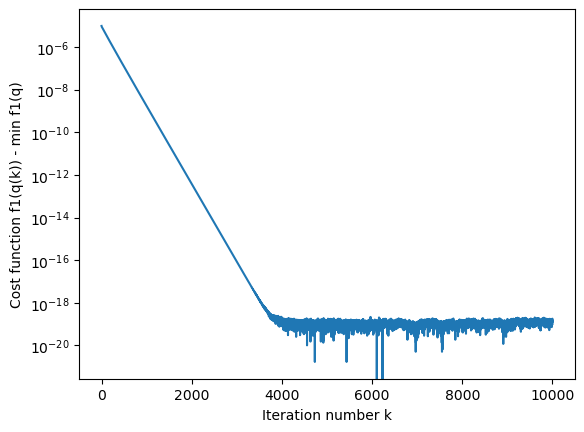

Calculating ellipsoid fit rmse...



100%|██████████| 111236/111236 [03:03<00:00, 607.01it/s]


Ellipsoid fit rmse is 3.1011336736400428 nm.
Ellipsoid fit: COP2 membrane axes is [39.19201399 33.75552325 33.19619287] nm
Ellipsoid fit: COP2 membrane Surface Area is 15710.34728370708 nm
Ellipsoid fit: COP2 membrane Volume is 183958.26902471718 nm
Sphericity index of best-fitting ellipsoid is 0.9409026914859102 for COP2 membrane.
Sphericity of best-fitting ellipsoid is 0.9956603561738402 for COP2 membrane.

{'Image_Name': 'L39_LOW_4_2_HIGH_1_memb_4_2-COP2.mrc', 'Image_Tag': 'COP2', 'info': {'sphere_center': array([256.40944194, 556.20076521, 282.99055363]), 'sphere_radius': 34.545011650495645, 'sphere_rmse': 3.3011070409130006, 'sphere_radius_nm': 34.545011650495645, 'ellipsoid_center': array([256.495019  , 556.05253883, 284.03500146]), 'ellipsoid_axes': array([39.19201399, 33.75552325, 33.19619287]), 'ellipsoid_rotmat': array([[-0.12717   ,  0.04018368,  0.99106663],
       [ 0.95915028, -0.24957982,  0.13319405],
       [-0.25270246, -0.96752012,  0.00680312]]), 'ellipsoid_residual

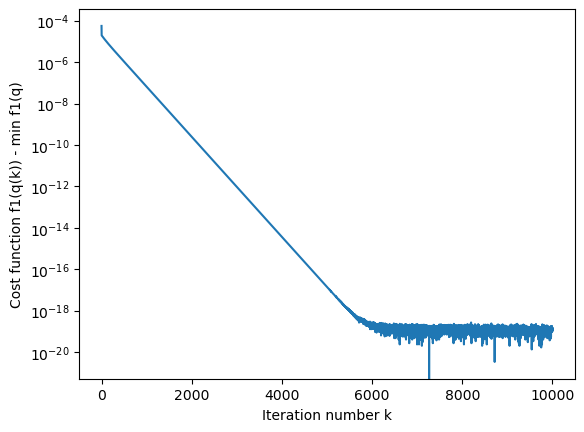

Calculating ellipsoid fit rmse...



100%|██████████| 30214/30214 [00:47<00:00, 632.68it/s]


Ellipsoid fit rmse is 3.0082704731613408 nm.
Ellipsoid fit: COP2 membrane axes is [32.4454345  22.85635569 25.80409763] nm
Ellipsoid fit: COP2 membrane Surface Area is 9138.85459685545 nm
Ellipsoid fit: COP2 membrane Volume is 80156.33763568077 nm
Sphericity index of best-fitting ellipsoid is 0.8545232828555187 for COP2 membrane.
Sphericity of best-fitting ellipsoid is 0.9837489176650563 for COP2 membrane.

{'Image_Name': 'L24_LOW_2_4_HIGH_1_memb_34_1-COP2.mrc', 'Image_Tag': 'COP2', 'info': {'sphere_center': array([689.88237542, 196.41764858, 283.33552694]), 'sphere_radius': 35.11189179513237, 'sphere_rmse': 2.9770082020442636, 'sphere_radius_nm': 35.11189179513237, 'ellipsoid_center': array([683.78648495, 206.82693509, 282.37684355]), 'ellipsoid_axes': array([32.4454345 , 22.85635569, 25.80409763]), 'ellipsoid_rotmat': array([[-0.86687611, -0.49732207,  0.03459137],
       [-0.49552358,  0.8519817 , -0.16906678],
       [-0.05460942,  0.16370079,  0.98499739]]), 'ellipsoid_residual': 

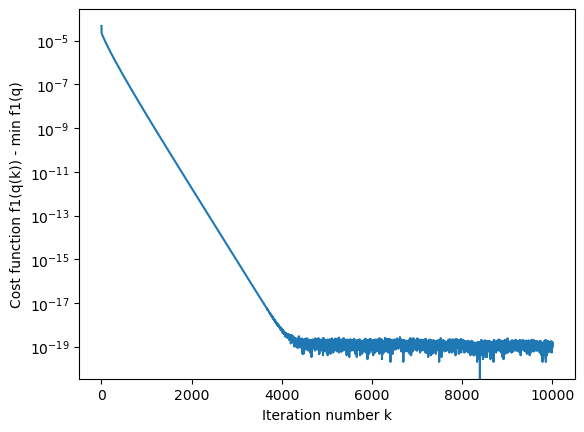

Calculating ellipsoid fit rmse...



100%|██████████| 24865/24865 [00:39<00:00, 623.09it/s]


Ellipsoid fit rmse is 3.3448523806842867 nm.
Ellipsoid fit: COP2 membrane axes is [14.49453694 30.90679319 20.580374  ] nm
Ellipsoid fit: COP2 membrane Surface Area is 5947.421504076171 nm
Ellipsoid fit: COP2 membrane Volume is 38618.92350452194 nm
Sphericity index of best-fitting ellipsoid is 0.6912479038396949 for COP2 membrane.
Sphericity of best-fitting ellipsoid is 0.9290138347891784 for COP2 membrane.

{'Image_Name': 'L17_LOW_3_HIGH_1_3_memb_95_1-COP2.mrc', 'Image_Tag': 'COP2', 'info': {'sphere_center': array([785.20970969, 749.59959666, 296.87657969]), 'sphere_radius': 35.379197302508274, 'sphere_rmse': 3.664278301424816, 'sphere_radius_nm': 35.379197302508274, 'ellipsoid_center': array([772.34260975, 734.47180509, 295.60639202]), 'ellipsoid_axes': array([14.49453694, 30.90679319, 20.580374  ]), 'ellipsoid_rotmat': array([[ 0.61683636,  0.75971735, -0.20577282],
       [ 0.77113537, -0.63568783, -0.03537271],
       [ 0.15768053,  0.13685953,  0.97796029]]), 'ellipsoid_residual'

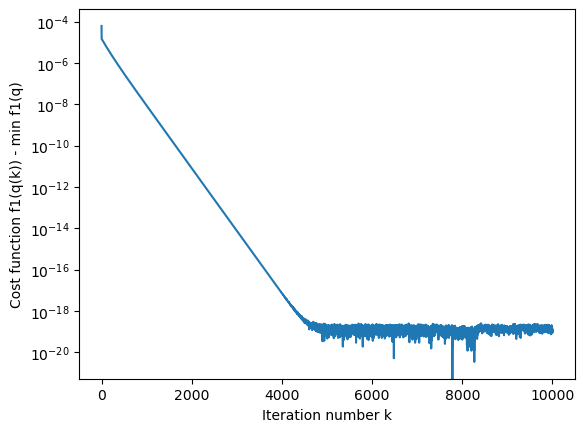

Calculating ellipsoid fit rmse...



100%|██████████| 67558/67558 [01:53<00:00, 597.07it/s]


Ellipsoid fit rmse is 2.996940077296902 nm.
Ellipsoid fit: COP1 membrane axes is [33.49154252 43.05314442 36.6285222 ] nm
Ellipsoid fit: COP1 membrane Surface Area is 17840.36403568354 nm
Ellipsoid fit: COP1 membrane Volume is 221232.04444945182 nm
Sphericity index of best-fitting ellipsoid is 0.8926516440466067 for COP1 membrane.
Sphericity of best-fitting ellipsoid is 0.9915450124527346 for COP1 membrane.

{'Image_Name': 'L7_LOW_1_3_HIGH_1_memb_16_2-COP1.mrc', 'Image_Tag': 'COP1', 'info': {'sphere_center': array([504.89101113, 572.80499365, 302.82488572]), 'sphere_radius': 40.27517306219538, 'sphere_rmse': 3.7249109587076976, 'sphere_radius_nm': 40.27517306219538, 'ellipsoid_center': array([509.44723562, 572.1291921 , 303.20409736]), 'ellipsoid_axes': array([33.49154252, 43.05314442, 36.6285222 ]), 'ellipsoid_rotmat': array([[ 0.97518406, -0.20717647, -0.07806377],
       [-0.1966672 , -0.97255762,  0.1243129 ],
       [ 0.10167622,  0.10587537,  0.9891675 ]]), 'ellipsoid_residual': 

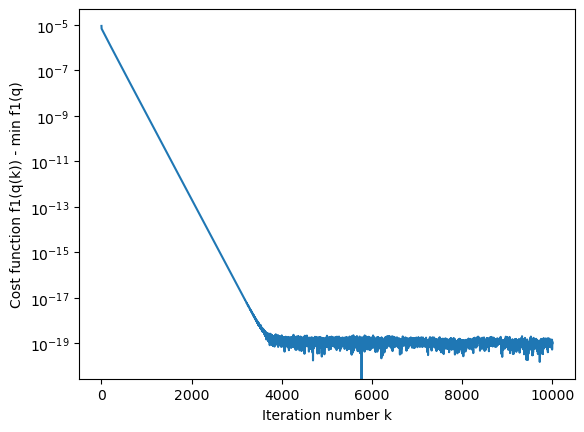

Calculating ellipsoid fit rmse...



100%|██████████| 95223/95223 [02:43<00:00, 581.22it/s]


Ellipsoid fit rmse is 2.443383765674714 nm.
Ellipsoid fit: COP2 membrane axes is [38.41898222 34.33567039 35.89143696] nm
Ellipsoid fit: COP2 membrane Surface Area is 16474.226309935075 nm
Ellipsoid fit: COP2 membrane Volume is 198321.976677293 nm
Sphericity index of best-fitting ellipsoid is 0.949113433340427 for COP2 membrane.
Sphericity of best-fitting ellipsoid is 0.9982967526492188 for COP2 membrane.

{'Image_Name': 'L24_LOW_2_4_HIGH_1_memb_40_1-COP2.mrc', 'Image_Tag': 'COP2', 'info': {'sphere_center': array([582.87809729, 231.11604346, 320.24598253]), 'sphere_radius': 35.840783397848696, 'sphere_rmse': 2.604475557000521, 'sphere_radius_nm': 35.840783397848696, 'ellipsoid_center': array([583.07118638, 231.18290154, 319.92353467]), 'ellipsoid_axes': array([38.41898222, 34.33567039, 35.89143696]), 'ellipsoid_rotmat': array([[ 0.28595349, -0.28259887, -0.91562464],
       [-0.92787896, -0.32029415, -0.19092481],
       [ 0.23931408, -0.90418446,  0.35380678]]), 'ellipsoid_residual': 

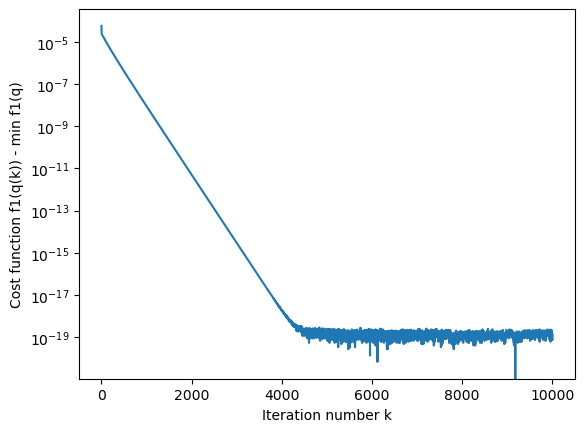

Calculating ellipsoid fit rmse...



100%|██████████| 35379/35379 [00:59<00:00, 595.64it/s]


Ellipsoid fit rmse is 2.994388796608926 nm.
Ellipsoid fit: COP1 membrane axes is [26.70498587 32.11365781 39.41421929] nm
Ellipsoid fit: COP1 membrane Surface Area is 13403.118384066647 nm
Ellipsoid fit: COP1 membrane Volume is 141587.0932191275 nm
Sphericity index of best-fitting ellipsoid is 0.8259377831808041 for COP1 membrane.
Sphericity of best-fitting ellipsoid is 0.98015339408593 for COP1 membrane.

{'Image_Name': 'L39_LOW_1_7_HIGH_1_memb_1_6-COP1.mrc', 'Image_Tag': 'COP1', 'info': {'sphere_center': array([455.57421092, 427.45906833, 163.75228018]), 'sphere_radius': 42.77727662451941, 'sphere_rmse': 3.079299154948518, 'sphere_radius_nm': 42.77727662451941, 'ellipsoid_center': array([442.54036201, 419.27558905, 164.38912497]), 'ellipsoid_axes': array([26.70498587, 32.11365781, 39.41421929]), 'ellipsoid_rotmat': array([[-0.73804913, -0.65804752,  0.14918757],
       [-0.55223806,  0.46205321, -0.6939308 ],
       [-0.38770685,  0.59454208,  0.70441686]]), 'ellipsoid_residual': 3.0

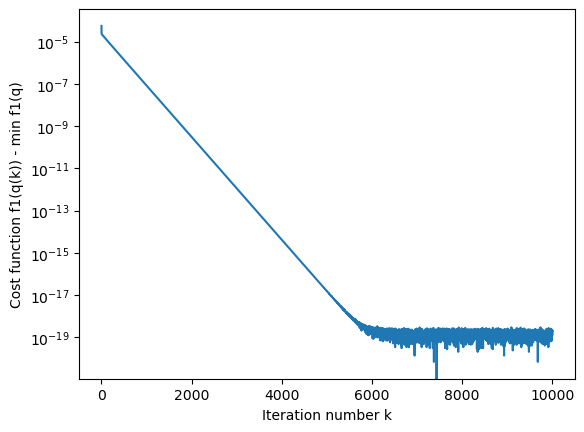

Calculating ellipsoid fit rmse...



100%|██████████| 46869/46869 [01:16<00:00, 609.51it/s]


Ellipsoid fit rmse is 3.0008701661664827 nm.
Ellipsoid fit: COP1 membrane axes is [28.55147669 39.08059548 32.8190792 ] nm
Ellipsoid fit: COP1 membrane Surface Area is 14039.79622288431 nm
Ellipsoid fit: COP1 membrane Volume is 153392.7200948413 nm
Sphericity index of best-fitting ellipsoid is 0.8597849954464055 for COP1 membrane.
Sphericity of best-fitting ellipsoid is 0.987021211584169 for COP1 membrane.

{'Image_Name': 'High_mag_L27_3__2_memb_24_3-COP1.mrc', 'Image_Tag': 'COP1', 'info': {'sphere_center': array([614.06049592, 509.75187796, 206.53876224]), 'sphere_radius': 30.834297549642862, 'sphere_rmse': 3.572092910307959, 'sphere_radius_nm': 30.834297549642862, 'ellipsoid_center': array([614.06020781, 512.54197069, 209.17974424]), 'ellipsoid_axes': array([28.55147669, 39.08059548, 32.8190792 ]), 'ellipsoid_rotmat': array([[ 0.99894195, -0.02687268, -0.03732068],
       [-0.04481366, -0.38651255, -0.92119476],
       [-0.01033006, -0.92189257,  0.38730786]]), 'ellipsoid_residual': 

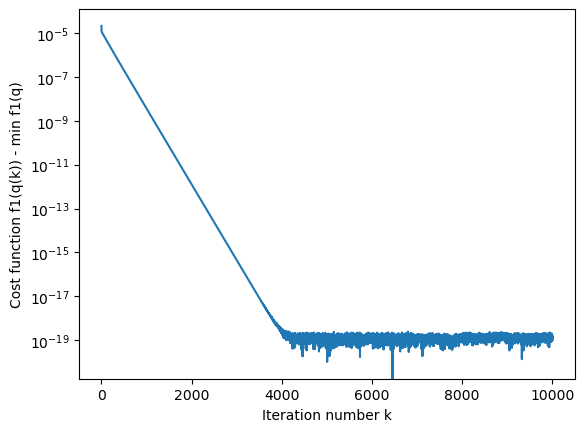

Calculating ellipsoid fit rmse...



100%|██████████| 110901/110901 [03:11<00:00, 578.95it/s]


Ellipsoid fit rmse is 3.0931497707803137 nm.
Ellipsoid fit: COP2 membrane axes is [53.36821183 31.09440116 36.17854381] nm
Ellipsoid fit: COP2 membrane Surface Area is 20025.7135004626 nm
Ellipsoid fit: COP2 membrane Volume is 251480.63051605714 nm
Sphericity index of best-fitting ellipsoid is 0.7941030916658096 for COP2 membrane.
Sphericity of best-fitting ellipsoid is 0.9621271858730769 for COP2 membrane.

{'Image_Name': 'L7_LOW_1_3_HIGH_1_memb_35_1-COP2.mrc', 'Image_Tag': 'COP2', 'info': {'sphere_center': array([450.99722105, 752.95998796, 244.07105299]), 'sphere_radius': 37.2248104329877, 'sphere_rmse': 5.365586917916787, 'sphere_radius_nm': 37.2248104329877, 'ellipsoid_center': array([448.16438698, 756.6649763 , 238.07408786]), 'ellipsoid_axes': array([53.36821183, 31.09440116, 36.17854381]), 'ellipsoid_rotmat': array([[-0.48946406,  0.49786867, -0.71592718],
       [ 0.86330472,  0.39246394, -0.31729642],
       [-0.12300365,  0.7733685 ,  0.62190937]]), 'ellipsoid_residual': 8.8

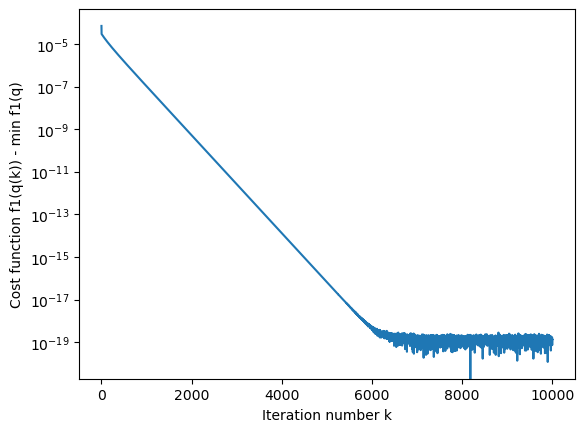

Calculating ellipsoid fit rmse...



100%|██████████| 68089/68089 [01:57<00:00, 581.18it/s]


Ellipsoid fit rmse is 3.0246224336635152 nm.
Ellipsoid fit: COP1 membrane axes is [51.70017833 38.76186443 42.85222839] nm
Ellipsoid fit: COP1 membrane Surface Area is 24734.202595684328 nm
Ellipsoid fit: COP1 membrane Volume is 359715.141954341 nm
Sphericity index of best-fitting ellipsoid is 0.8785799502252027 for COP1 membrane.
Sphericity of best-fitting ellipsoid is 0.9889143762068006 for COP1 membrane.

{'Image_Name': 'L13_LOW_7_2_HIGH_1_2_memb_40_5-COP1.mrc', 'Image_Tag': 'COP1', 'info': {'sphere_center': array([536.4696639 , 599.21333565, 210.9534984 ]), 'sphere_radius': 40.97330938026003, 'sphere_rmse': 3.7113197252663657, 'sphere_radius_nm': 40.97330938026003, 'ellipsoid_center': array([538.44869192, 596.52587504, 209.78644977]), 'ellipsoid_axes': array([51.70017833, 38.76186443, 42.85222839]), 'ellipsoid_rotmat': array([[ 0.51358946, -0.14091258, -0.84638615],
       [-0.76781096, -0.51578849, -0.38003757],
       [ 0.38300416, -0.84504785,  0.37309776]]), 'ellipsoid_residual

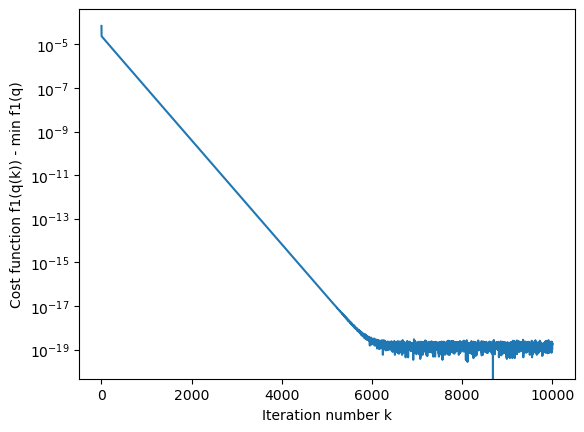

Calculating ellipsoid fit rmse...



100%|██████████| 18788/18788 [00:31<00:00, 596.82it/s]


Ellipsoid fit rmse is 2.608911781625771 nm.
Ellipsoid fit: COP1 membrane axes is [32.80003323 21.92162454 25.10038144] nm
Ellipsoid fit: COP1 membrane Surface Area is 8834.949494850885 nm
Ellipsoid fit: COP1 membrane Volume is 75598.98236860591 nm
Sphericity index of best-fitting ellipsoid is 0.8357254385544549 for COP1 membrane.
Sphericity of best-fitting ellipsoid is 0.9786423816761933 for COP1 membrane.

{'Image_Name': 'L24_LOW_1_5_HIGH_1_memb_36_1-COP1.mrc', 'Image_Tag': 'COP1', 'info': {'sphere_center': array([311.29427186, 511.5157736 , 100.85508657]), 'sphere_radius': 27.023969479404986, 'sphere_rmse': 3.0204639666254485, 'sphere_radius_nm': 27.023969479404986, 'ellipsoid_center': array([315.39903436, 510.2350672 , 101.41060372]), 'ellipsoid_axes': array([32.80003323, 21.92162454, 25.10038144]), 'ellipsoid_rotmat': array([[ 0.63668271, -0.37781483, -0.67222845],
       [-0.59653913,  0.311092  , -0.73983974],
       [-0.48864731, -0.87205374,  0.02731444]]), 'ellipsoid_residual'

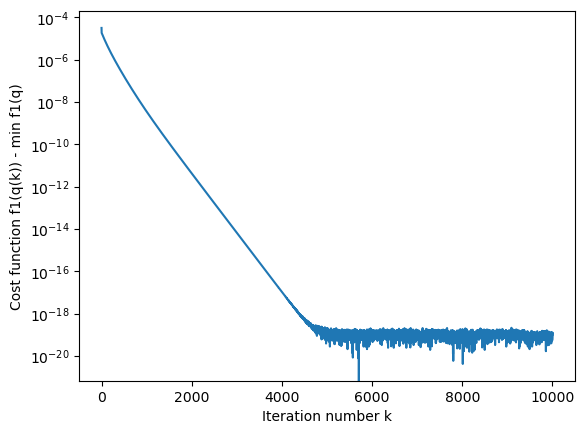

Calculating ellipsoid fit rmse...



100%|██████████| 76998/76998 [02:16<00:00, 563.73it/s]


Ellipsoid fit rmse is 2.727197263270384 nm.
Ellipsoid fit: COP1 membrane axes is [30.28228013 39.45895818 53.48472173] nm
Ellipsoid fit: COP1 membrane Surface Area is 20953.93328996044 nm
Ellipsoid fit: COP1 membrane Volume is 267702.5678959612 nm
Sphericity index of best-fitting ellipsoid is 0.7574150493356555 for COP1 membrane.
Sphericity of best-fitting ellipsoid is 0.9586356868121007 for COP1 membrane.

{'Image_Name': 'Position_14_memb_77_1-COP1.mrc', 'Image_Tag': 'COP1', 'info': {'sphere_center': array([554.72686991, 248.62908256, 172.605199  ]), 'sphere_radius': 37.79389537310326, 'sphere_rmse': 5.644721325619278, 'sphere_radius_nm': 37.79389537310326, 'ellipsoid_center': array([555.71779525, 248.48849725, 168.51507063]), 'ellipsoid_axes': array([30.28228013, 39.45895818, 53.48472173]), 'ellipsoid_rotmat': array([[ 0.91848293, -0.39221301, -0.05057732],
       [-0.39140027, -0.9198673 ,  0.02549472],
       [ 0.05652379,  0.00362049,  0.99839469]]), 'ellipsoid_residual': 6.983357

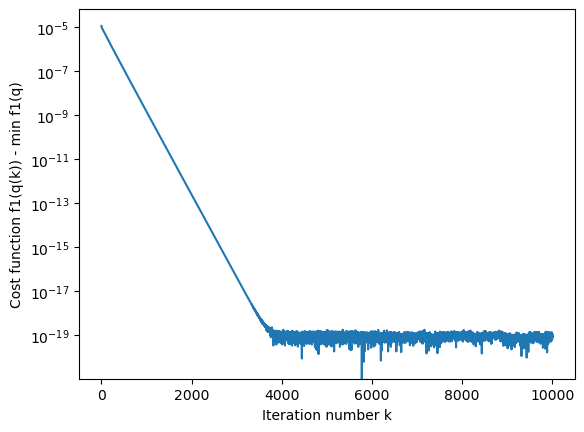

Calculating ellipsoid fit rmse...



100%|██████████| 41586/41586 [01:12<00:00, 577.40it/s]


Ellipsoid fit rmse is 1.7608445263024535 nm.
Ellipsoid fit: COP1 membrane axes is [28.36720631 27.09217726 32.53526321] nm
Ellipsoid fit: COP1 membrane Surface Area is 10796.439267956493 nm
Ellipsoid fit: COP1 membrane Volume is 104737.79088448873 nm
Sphericity index of best-fitting ellipsoid is 0.9264862431144315 for COP1 membrane.
Sphericity of best-fitting ellipsoid is 0.9952660382422986 for COP1 membrane.

{'Image_Name': 'L50_Position_8_memb_47_1-COP1.mrc', 'Image_Tag': 'COP1', 'info': {'sphere_center': array([468.79494292, 778.35297803, 250.35121085]), 'sphere_radius': 29.227325886547984, 'sphere_rmse': 2.137765179564021, 'sphere_radius_nm': 29.227325886547984, 'ellipsoid_center': array([468.76885001, 778.48413266, 249.40043946]), 'ellipsoid_axes': array([28.36720631, 27.09217726, 32.53526321]), 'ellipsoid_rotmat': array([[-0.99831721, -0.02915943, -0.05012451],
       [-0.05447372,  0.76794508,  0.63819508],
       [-0.01988347, -0.63985161,  0.76824122]]), 'ellipsoid_residual': 

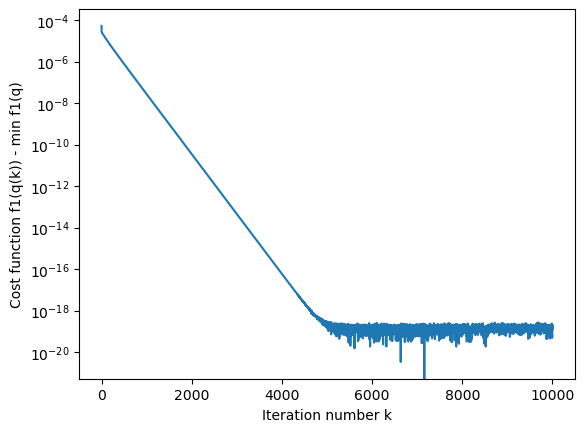

Calculating ellipsoid fit rmse...



100%|██████████| 49164/49164 [01:26<00:00, 571.33it/s]


Ellipsoid fit rmse is 2.764799351809841 nm.
Ellipsoid fit: COP2 membrane axes is [46.17401015 41.99212391 33.51664369] nm
Ellipsoid fit: COP2 membrane Surface Area is 20617.07628330063 nm
Ellipsoid fit: COP2 membrane Volume is 272216.5760628734 nm
Sphericity index of best-fitting ellipsoid is 0.833652780934544 for COP2 membrane.
Sphericity of best-fitting ellipsoid is 0.9852204657443965 for COP2 membrane.

{'Image_Name': 'High_mag_L12_P1_2_memb_6_2-COP2.mrc', 'Image_Tag': 'COP2', 'info': {'sphere_center': array([328.38044717, 414.79419683,  94.21809256]), 'sphere_radius': 39.65466227479352, 'sphere_rmse': 4.0124177400560335, 'sphere_radius_nm': 39.65466227479352, 'ellipsoid_center': array([330.05260819, 416.49272347,  90.17663302]), 'ellipsoid_axes': array([46.17401015, 41.99212391, 33.51664369]), 'ellipsoid_rotmat': array([[-0.77690826,  0.16503593,  0.60759913],
       [ 0.62713021,  0.11721031,  0.77004509],
       [-0.05586823, -0.97929816,  0.19456068]]), 'ellipsoid_residual': 9.3

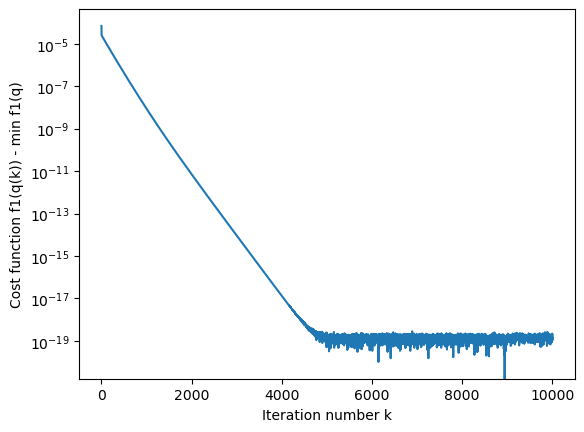

Calculating ellipsoid fit rmse...



100%|██████████| 38276/38276 [01:05<00:00, 583.64it/s]


Ellipsoid fit rmse is 2.8876816741074656 nm.
Ellipsoid fit: COP1 membrane axes is [49.23459212 30.27214781 28.69038375] nm
Ellipsoid fit: COP1 membrane Surface Area is 16034.725294218355 nm
Ellipsoid fit: COP1 membrane Volume is 179117.71744444274 nm
Sphericity index of best-fitting ellipsoid is 0.8204517485362322 for COP1 membrane.
Sphericity of best-fitting ellipsoid is 0.9583297372206702 for COP1 membrane.

{'Image_Name': 'L24_LOW_1_2_HIGH_1_5_memb_13_3-COP1.mrc', 'Image_Tag': 'COP1', 'info': {'sphere_center': array([174.81543737, 582.69603751, 137.51098157]), 'sphere_radius': 43.298779720097116, 'sphere_rmse': 5.5667271013099136, 'sphere_radius_nm': 43.298779720097116, 'ellipsoid_center': array([167.19548422, 586.35378185, 131.72218938]), 'ellipsoid_axes': array([49.23459212, 30.27214781, 28.69038375]), 'ellipsoid_rotmat': array([[ 0.25516324,  0.95506641,  0.15079744],
       [ 0.8117186 , -0.12684989, -0.57010703],
       [ 0.52536143, -0.26787545,  0.8076126 ]]), 'ellipsoid_resi

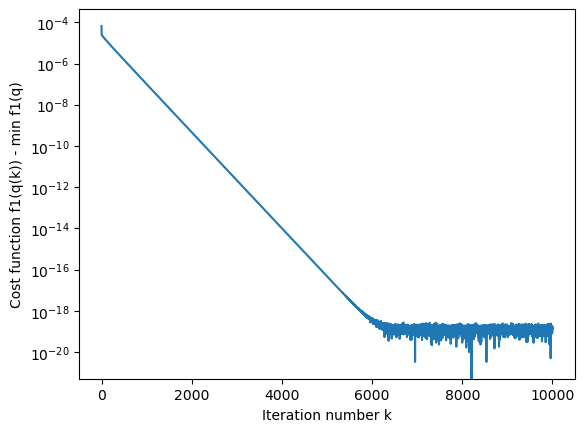

Calculating ellipsoid fit rmse...



100%|██████████| 27452/27452 [00:47<00:00, 577.09it/s]


Ellipsoid fit rmse is 2.1448371069453382 nm.
Ellipsoid fit: COP1 membrane axes is [50.09678631 29.92413606 35.27540539] nm
Ellipsoid fit: COP1 membrane Surface Area is 18333.13858864163 nm
Ellipsoid fit: COP1 membrane Volume is 221509.3744097606 nm
Sphericity index of best-fitting ellipsoid is 0.7972364018377418 for COP1 membrane.
Sphericity of best-fitting ellipsoid is 0.965699581885199 for COP1 membrane.

{'Image_Name': 'L24_LOW_1_2_HIGH_1_memb_31_2-COP1.mrc', 'Image_Tag': 'COP1', 'info': {'sphere_center': array([281.49055155, 501.40260491, 237.04402928]), 'sphere_radius': 28.410853744838814, 'sphere_rmse': 2.781244826611957, 'sphere_radius_nm': 28.410853744838814, 'ellipsoid_center': array([290.1612762 , 485.04232292, 232.20970867]), 'ellipsoid_axes': array([50.09678631, 29.92413606, 35.27540539]), 'ellipsoid_rotmat': array([[ 0.46644917, -0.80905004, -0.35757965],
       [-0.82052095, -0.24475314, -0.51656681],
       [-0.33040965, -0.53435376,  0.77800741]]), 'ellipsoid_residual':

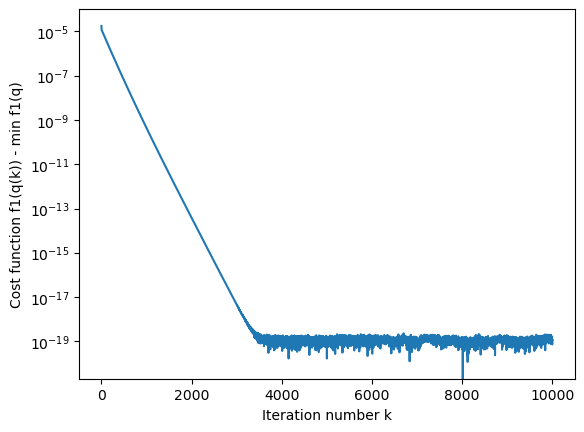

Calculating ellipsoid fit rmse...



100%|██████████| 141564/141564 [04:02<00:00, 583.30it/s]


Ellipsoid fit rmse is 3.236687205561878 nm.
Ellipsoid fit: COP2 membrane axes is [51.62701403 38.27619999 38.96806173] nm
Ellipsoid fit: COP2 membrane Surface Area is 23071.235211425515 nm
Ellipsoid fit: COP2 membrane Volume is 322554.5973389815 nm
Sphericity index of best-fitting ellipsoid is 0.8996852616321072 for COP2 membrane.
Sphericity of best-fitting ellipsoid is 0.985860429252564 for COP2 membrane.

{'Image_Name': 'L25_LOW_1_HIGH_1_memb_21_1-COP2.mrc', 'Image_Tag': 'COP2', 'info': {'sphere_center': array([311.9980449 , 448.62128998, 206.39066041]), 'sphere_radius': 40.823560820471535, 'sphere_rmse': 4.114909558980829, 'sphere_radius_nm': 40.823560820471535, 'ellipsoid_center': array([313.0955701 , 448.587377  , 208.49664486]), 'ellipsoid_axes': array([51.62701403, 38.27619999, 38.96806173]), 'ellipsoid_rotmat': array([[ 0.05367943, -0.11689542, -0.99169248],
       [ 0.932739  , -0.34872408,  0.09159406],
       [ 0.35653398,  0.92990697, -0.09031361]]), 'ellipsoid_residual': 6

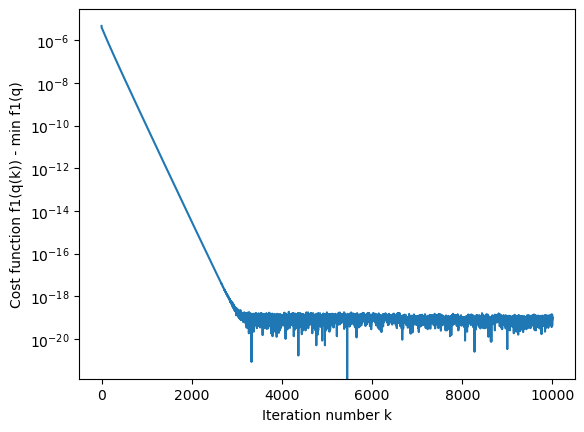

Calculating ellipsoid fit rmse...



100%|██████████| 118291/118291 [03:23<00:00, 581.70it/s]


Ellipsoid fit rmse is 2.6005602834095463 nm.
Ellipsoid fit: COP1 membrane axes is [43.58240484 36.0356374  35.45900653] nm
Ellipsoid fit: COP1 membrane Surface Area is 18450.371903998588 nm
Ellipsoid fit: COP1 membrane Volume is 233269.82943661732 nm
Sphericity index of best-fitting ellipsoid is 0.9285456137997761 for COP1 membrane.
Sphericity of best-fitting ellipsoid is 0.9932335501589102 for COP1 membrane.

{'Image_Name': 'L31_LOW_1_3_HIGH_1_memb_34_1-COP1.mrc', 'Image_Tag': 'COP1', 'info': {'sphere_center': array([385.10465921, 669.85964951, 236.10658535]), 'sphere_radius': 38.37922128316629, 'sphere_rmse': 3.5319588753813, 'sphere_radius_nm': 38.37922128316629, 'ellipsoid_center': array([385.45783413, 670.20130261, 235.72453238]), 'ellipsoid_axes': array([43.58240484, 36.0356374 , 35.45900653]), 'ellipsoid_rotmat': array([[-0.56095147,  0.27976954, -0.77914212],
       [ 0.75304941, -0.21850107, -0.62062377],
       [ 0.34387502,  0.93487234,  0.08811179]]), 'ellipsoid_residual': 

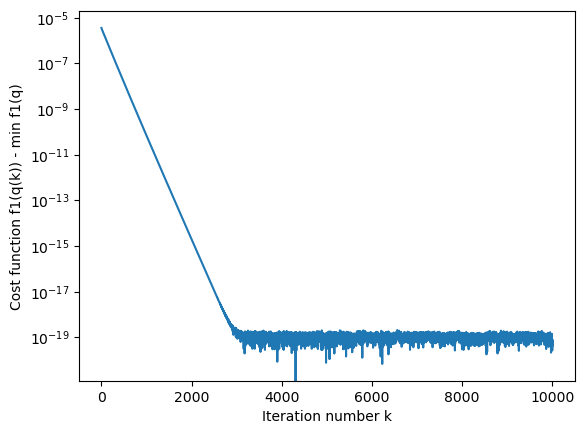

Calculating ellipsoid fit rmse...



100%|██████████| 118663/118663 [03:23<00:00, 582.36it/s]


Ellipsoid fit rmse is 2.6444983931323995 nm.
Ellipsoid fit: COP2 membrane axes is [41.19470388 33.36219655 35.31979249] nm
Ellipsoid fit: COP2 membrane Surface Area is 16826.083973304856 nm
Ellipsoid fit: COP2 membrane Volume is 203330.6151849942 nm
Sphericity index of best-fitting ellipsoid is 0.9145692210806399 for COP2 membrane.
Sphericity of best-fitting ellipsoid is 0.9938089927014033 for COP2 membrane.

{'Image_Name': 'L39_LOW_1_5_HIGH_1_5_memb_25_1-COP2.mrc', 'Image_Tag': 'COP2', 'info': {'sphere_center': array([706.28863207, 572.08448698, 222.68772689]), 'sphere_radius': 36.116723152356336, 'sphere_rmse': 3.2088602393801198, 'sphere_radius_nm': 36.116723152356336, 'ellipsoid_center': array([706.51322621, 572.12541259, 223.46436069]), 'ellipsoid_axes': array([41.19470388, 33.36219655, 35.31979249]), 'ellipsoid_rotmat': array([[-0.18236933, -0.07410268, -0.98043369],
       [ 0.96500201,  0.17762705, -0.19292422],
       [-0.18844775,  0.98130394, -0.03911551]]), 'ellipsoid_resid

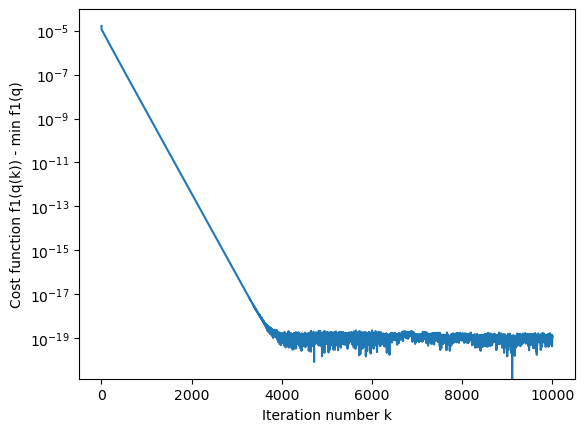

Calculating ellipsoid fit rmse...



100%|██████████| 69444/69444 [01:58<00:00, 587.60it/s]


Ellipsoid fit rmse is 2.3789527188405923 nm.
Ellipsoid fit: COP2 membrane axes is [37.51272697 33.56302904 30.69316099] nm
Ellipsoid fit: COP2 membrane Surface Area is 14440.981642862951 nm
Ellipsoid fit: COP2 membrane Volume is 161871.35844444926 nm
Sphericity index of best-fitting ellipsoid is 0.9078508056580692 for COP2 membrane.
Sphericity of best-fitting ellipsoid is 0.9946434251017204 for COP2 membrane.

{'Image_Name': 'High_mag_L12_P1_2_memb_10_1-COP2.mrc', 'Image_Tag': 'COP2', 'info': {'sphere_center': array([272.07969497, 557.49184268,  63.74918292]), 'sphere_radius': 35.233487712036506, 'sphere_rmse': 2.742227854092362, 'sphere_radius_nm': 35.233487712036506, 'ellipsoid_center': array([271.50235715, 558.36206296,  66.14672419]), 'ellipsoid_axes': array([37.51272697, 33.56302904, 30.69316099]), 'ellipsoid_rotmat': array([[ 0.54977219,  0.81563776, -0.18023757],
       [ 0.76470394, -0.40461847,  0.5015095 ],
       [-0.33612264,  0.41354435,  0.84616939]]), 'ellipsoid_residual

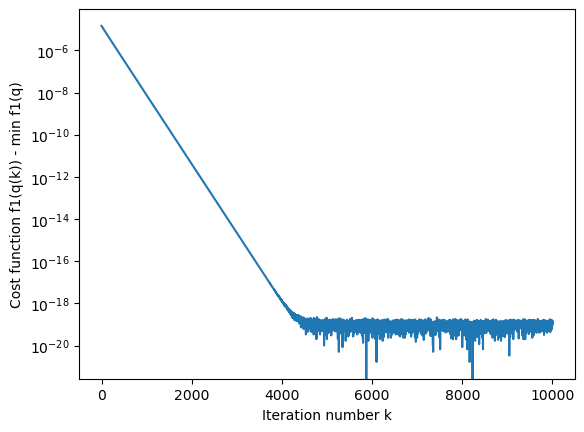

Calculating ellipsoid fit rmse...



100%|██████████| 97817/97817 [02:50<00:00, 573.75it/s]


Ellipsoid fit rmse is 2.950119374697518 nm.
Ellipsoid fit: COP2 membrane axes is [50.66631377 33.1353174  30.49646379] nm
Ellipsoid fit: COP2 membrane Surface Area is 17966.308345150523 nm
Ellipsoid fit: COP2 membrane Volume is 214461.10353777916 nm
Sphericity index of best-fitting ellipsoid is 0.8212893189028101 for COP2 membrane.
Sphericity of best-fitting ellipsoid is 0.9644009580126011 for COP2 membrane.

{'Image_Name': 'L24_LOW_1_2_HIGH_1_5_memb_2_2-COP2.mrc', 'Image_Tag': 'COP2', 'info': {'sphere_center': array([312.42733191, 459.41797243, 218.56690805]), 'sphere_radius': 34.53725080730172, 'sphere_rmse': 4.262742554089858, 'sphere_radius_nm': 34.53725080730172, 'ellipsoid_center': array([312.02634729, 460.56579912, 222.50909947]), 'ellipsoid_axes': array([50.66631377, 33.1353174 , 30.49646379]), 'ellipsoid_rotmat': array([[ 0.26042764, -0.24959748, -0.93267279],
       [ 0.76824302,  0.63867211,  0.04359597],
       [-0.58479066,  0.72787295, -0.35807939]]), 'ellipsoid_residual'

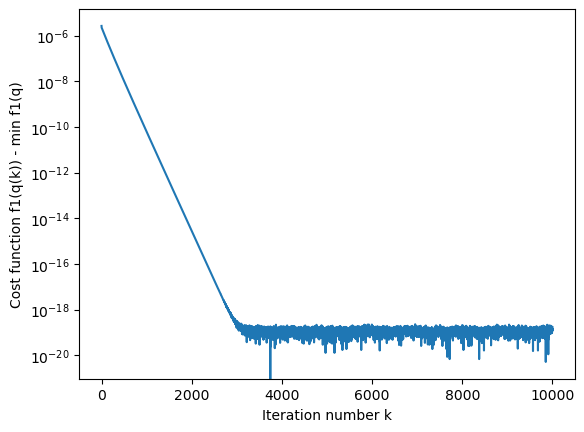

Calculating ellipsoid fit rmse...



100%|██████████| 123196/123196 [03:26<00:00, 597.05it/s]


Ellipsoid fit rmse is 2.9237584123914577 nm.
Ellipsoid fit: COP2 membrane axes is [31.76768439 33.2309783  40.53529947] nm
Ellipsoid fit: COP2 membrane Surface Area is 15507.779501605955 nm
Ellipsoid fit: COP2 membrane Volume is 179246.49880827163 nm
Sphericity index of best-fitting ellipsoid is 0.908234933175994 for COP2 membrane.
Sphericity of best-fitting ellipsoid is 0.9913681485341357 for COP2 membrane.

{'Image_Name': 'L34_LOW_1_5_HIGH_1_4_memb_18_1-COP2.mrc', 'Image_Tag': 'COP2', 'info': {'sphere_center': array([168.41134218, 635.74463962, 207.46138119]), 'sphere_radius': 34.78368148924625, 'sphere_rmse': 3.63734438139387, 'sphere_radius_nm': 34.78368148924625, 'ellipsoid_center': array([168.06427603, 636.02594925, 208.29302631]), 'ellipsoid_axes': array([31.76768439, 33.2309783 , 40.53529947]), 'ellipsoid_rotmat': array([[ 0.92417799,  0.37985683,  0.04004778],
       [ 0.37841649, -0.92480544,  0.03919009],
       [-0.05192303,  0.02106388,  0.99842892]]), 'ellipsoid_residual'

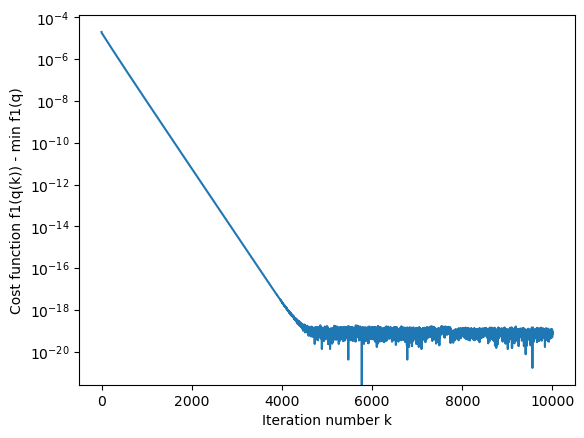

Calculating ellipsoid fit rmse...



100%|██████████| 19611/19611 [00:33<00:00, 584.52it/s]


Ellipsoid fit rmse is 1.9623352045266234 nm.
Ellipsoid fit: COP1 membrane axes is [29.02618645 20.48374359 22.19016451] nm
Ellipsoid fit: COP1 membrane Surface Area is 7136.427476409655 nm
Ellipsoid fit: COP1 membrane Volume is 55264.77963935303 nm
Sphericity index of best-fitting ellipsoid is 0.8668741507543923 for COP1 membrane.
Sphericity of best-fitting ellipsoid is 0.9831857218329113 for COP1 membrane.

{'Image_Name': 'L17_LOW_3_HIGH_1_3_memb_2_2-COP1.mrc', 'Image_Tag': 'COP1', 'info': {'sphere_center': array([369.98909897, 271.53711142, 192.85149207]), 'sphere_radius': 22.698533772091746, 'sphere_rmse': 2.5896091908167307, 'sphere_radius_nm': 22.698533772091746, 'ellipsoid_center': array([369.52340113, 271.87866727, 193.4922025 ]), 'ellipsoid_axes': array([29.02618645, 20.48374359, 22.19016451]), 'ellipsoid_rotmat': array([[ 0.39555641, -0.32415558, -0.85933596],
       [-0.76333786, -0.63633353, -0.11133261],
       [ 0.5107352 , -0.700002  ,  0.49914603]]), 'ellipsoid_residual'

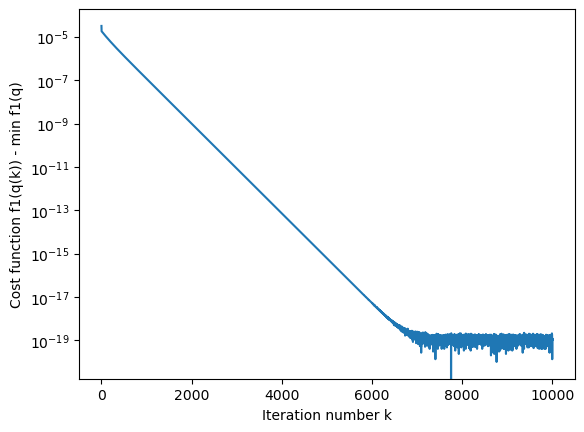

Calculating ellipsoid fit rmse...



100%|██████████| 57259/57259 [01:34<00:00, 608.48it/s]


Ellipsoid fit rmse is 3.7124185599918516 nm.
Ellipsoid fit: COP2 membrane axes is [22.75663759 44.43747019 38.07724383] nm
Ellipsoid fit: COP2 membrane Surface Area is 15357.532470426444 nm
Ellipsoid fit: COP2 membrane Volume is 161291.51984734283 nm
Sphericity index of best-fitting ellipsoid is 0.6739077511348793 for COP2 membrane.
Sphericity of best-fitting ellipsoid is 0.9330473959145174 for COP2 membrane.

{'Image_Name': 'L39_LOW_4_2_HIGH_1_memb_32_2-COP2.mrc', 'Image_Tag': 'COP2', 'info': {'sphere_center': array([480.08165894, 489.4162805 , 388.7285719 ]), 'sphere_radius': 32.44456761983733, 'sphere_rmse': 7.1792077195633235, 'sphere_radius_nm': 32.44456761983733, 'ellipsoid_center': array([483.03056046, 490.10860977, 387.21066405]), 'ellipsoid_axes': array([22.75663759, 44.43747019, 38.07724383]), 'ellipsoid_rotmat': array([[-0.08470775,  0.99578404,  0.0351959 ],
       [ 0.91985992,  0.06457439,  0.38689517],
       [-0.38299128, -0.06514832,  0.92145178]]), 'ellipsoid_residual

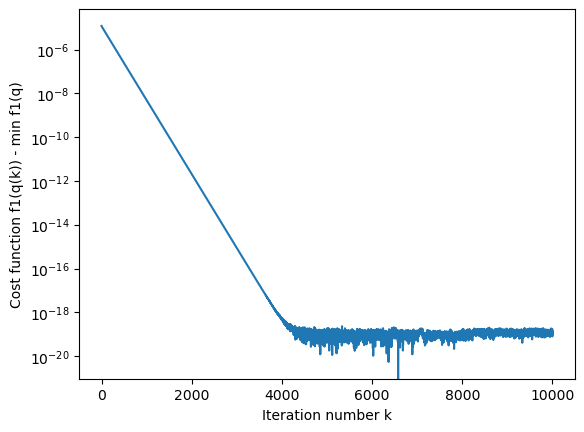

Calculating ellipsoid fit rmse...



100%|██████████| 78956/78956 [02:19<00:00, 565.76it/s]


Ellipsoid fit rmse is 2.111780816034218 nm.
Ellipsoid fit: COP2 membrane axes is [38.0166213  38.31863365 36.97528328] nm
Ellipsoid fit: COP2 membrane Surface Area is 17926.21798255496 nm
Ellipsoid fit: COP2 membrane Volume is 225623.14607344006 nm
Sphericity index of best-fitting ellipsoid is 0.9790686910803779 for COP2 membrane.
Sphericity of best-fitting ellipsoid is 0.9998109414563496 for COP2 membrane.

{'Image_Name': 'L24_LOW_1_2_HIGH_1_memb_48_1-COP2.mrc', 'Image_Tag': 'COP2', 'info': {'sphere_center': array([400.10534142, 427.5263419 , 231.98932304]), 'sphere_radius': 37.63583098346855, 'sphere_rmse': 2.1413065752215172, 'sphere_radius_nm': 37.63583098346855, 'ellipsoid_center': array([400.20030827, 427.42776324, 231.93352533]), 'ellipsoid_axes': array([38.0166213 , 38.31863365, 36.97528328]), 'ellipsoid_rotmat': array([[ 0.98549088,  0.06608022,  0.15633657],
       [-0.16725276,  0.22133862,  0.96074749],
       [-0.02888308,  0.97295561, -0.22917929]]), 'ellipsoid_residual':

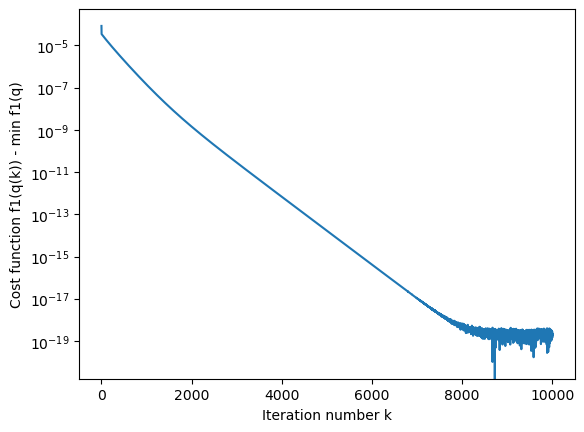

Calculating ellipsoid fit rmse...



100%|██████████| 20225/20225 [00:36<00:00, 557.83it/s]


Ellipsoid fit rmse is 2.387958760570518 nm.
Ellipsoid fit: COP2 membrane axes is [30.72958038 33.96340697 46.9120504 ] nm
Ellipsoid fit: COP2 membrane Surface Area is 17236.595335836682 nm
Ellipsoid fit: COP2 membrane Volume is 205088.3086918577 nm
Sphericity index of best-fitting ellipsoid is 0.8399869362515535 for COP2 membrane.
Sphericity of best-fitting ellipsoid is 0.9757230718924124 for COP2 membrane.

{'Image_Name': 'L30_LOW_2_HIGH_1_memb_57_1-COP2.mrc', 'Image_Tag': 'COP2', 'info': {'sphere_center': array([449.48597151, 718.21494173, 156.30303942]), 'sphere_radius': 31.25866891099375, 'sphere_rmse': 2.9370398042794754, 'sphere_radius_nm': 31.25866891099375, 'ellipsoid_center': array([448.72800573, 714.31191347, 157.51654887]), 'ellipsoid_axes': array([30.72958038, 33.96340697, 46.9120504 ]), 'ellipsoid_rotmat': array([[ 0.96228497, -0.26790126, -0.04729217],
       [-0.26838115, -0.96330455, -0.00398886],
       [ 0.04448815, -0.01653075,  0.99887313]]), 'ellipsoid_residual': 1

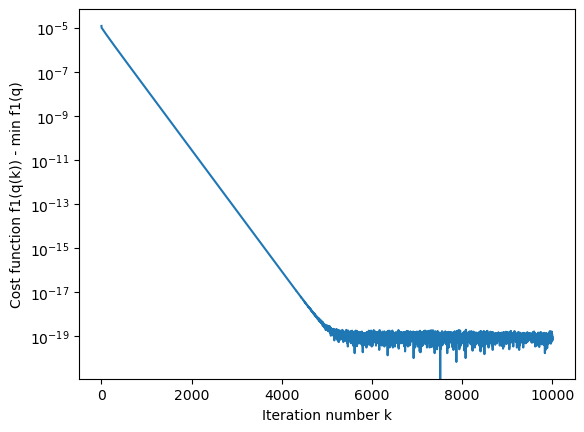

Calculating ellipsoid fit rmse...



100%|██████████| 92367/92367 [02:53<00:00, 531.20it/s]


Ellipsoid fit rmse is 3.1145362083873143 nm.
Ellipsoid fit: COP1 membrane axes is [72.48625438 28.01058569 25.78713302] nm
Ellipsoid fit: COP1 membrane Surface Area is 20227.169450277925 nm
Ellipsoid fit: COP1 membrane Volume is 219315.59708884012 nm
Sphericity index of best-fitting ellipsoid is 0.6893018184131118 for COP1 membrane.
Sphericity of best-fitting ellipsoid is 0.8694848598444663 for COP1 membrane.

{'Image_Name': 'High_mag_L12_P1_2_memb_32_1-COP1.mrc', 'Image_Tag': 'COP1', 'info': {'sphere_center': array([591.00508491, 765.94726719, 129.0027437 ]), 'sphere_radius': 36.96203668091547, 'sphere_rmse': 9.197278651295935, 'sphere_radius_nm': 36.96203668091547, 'ellipsoid_center': array([589.70747323, 765.71781362, 122.5463011 ]), 'ellipsoid_axes': array([72.48625438, 28.01058569, 25.78713302]), 'ellipsoid_rotmat': array([[ 0.41188221, -0.0586791 ,  0.90934581],
       [-0.66767094,  0.65969668,  0.34498668],
       [ 0.62013592,  0.74923765, -0.23253899]]), 'ellipsoid_residual':

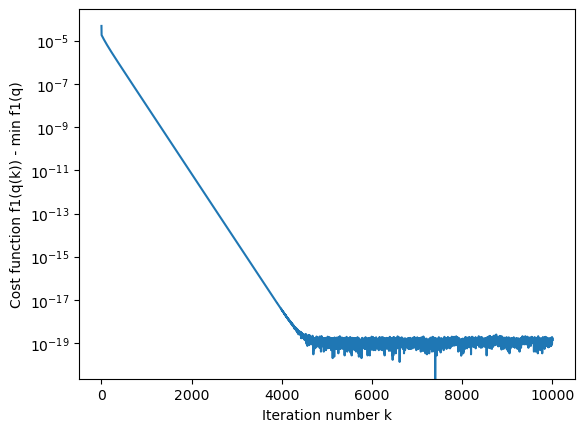

Calculating ellipsoid fit rmse...



100%|██████████| 15369/15369 [00:23<00:00, 648.70it/s]


Ellipsoid fit rmse is 2.4126031536724266 nm.
Ellipsoid fit: COP2 membrane axes is [23.11858942 17.47743496 19.04268293] nm
Ellipsoid fit: COP2 membrane Surface Area is 4950.14677607821 nm
Ellipsoid fit: COP2 membrane Volume is 32229.663579507083 nm
Sphericity index of best-fitting ellipsoid is 0.8852962818323189 for COP2 membrane.
Sphericity of best-fitting ellipsoid is 0.9893954215884488 for COP2 membrane.

{'Image_Name': 'L25_LOW_4_HIGH_1_5_memb_3_1-COP2.mrc', 'Image_Tag': 'COP2', 'info': {'sphere_center': array([126.15130932, 370.99674593, 240.50976563]), 'sphere_radius': 18.56635106733937, 'sphere_rmse': 2.6228726714620616, 'sphere_radius_nm': 18.56635106733937, 'ellipsoid_center': array([124.43524897, 368.43233469, 239.71821433]), 'ellipsoid_axes': array([23.11858942, 17.47743496, 19.04268293]), 'ellipsoid_rotmat': array([[-0.59568092, -0.72892353, -0.33739403],
       [-0.79560796,  0.47776007,  0.37249602],
       [ 0.11032772, -0.49032215,  0.86452992]]), 'ellipsoid_residual': 

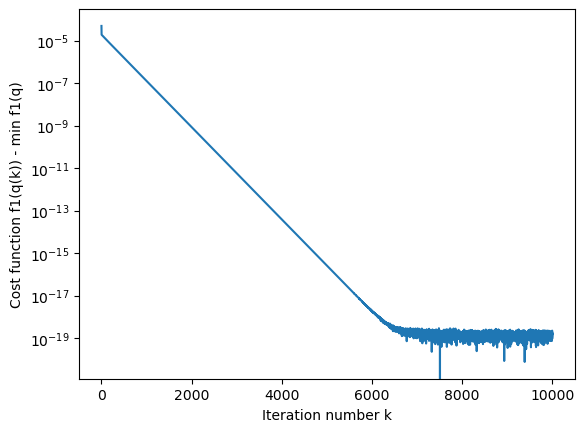

Calculating ellipsoid fit rmse...



100%|██████████| 75514/75514 [02:15<00:00, 557.24it/s]


Ellipsoid fit rmse is 2.5958191312804635 nm.
Ellipsoid fit: COP1 membrane axes is [41.14873074 45.50681053 53.182673  ] nm
Ellipsoid fit: COP1 membrane Surface Area is 27237.26240092942 nm
Ellipsoid fit: COP1 membrane Volume is 417149.38949969964 nm
Sphericity index of best-fitting ellipsoid is 0.8877461059542726 for COP1 membrane.
Sphericity of best-fitting ellipsoid is 0.9912466773728204 for COP1 membrane.

{'Image_Name': 'L24_LOW_2_4_HIGH_1_memb_35_1-COP1.mrc', 'Image_Tag': 'COP1', 'info': {'sphere_center': array([581.02824564, 214.88895442, 217.58812368]), 'sphere_radius': 42.786917908470585, 'sphere_rmse': 3.2019272400360372, 'sphere_radius_nm': 42.786917908470585, 'ellipsoid_center': array([580.67223725, 211.42387097, 213.01571502]), 'ellipsoid_axes': array([41.14873074, 45.50681053, 53.182673  ]), 'ellipsoid_rotmat': array([[ 0.9924968 , -0.12202536,  0.00774029],
       [-0.12193239, -0.98306089,  0.13683483],
       [ 0.00908814,  0.13675193,  0.99056364]]), 'ellipsoid_residua

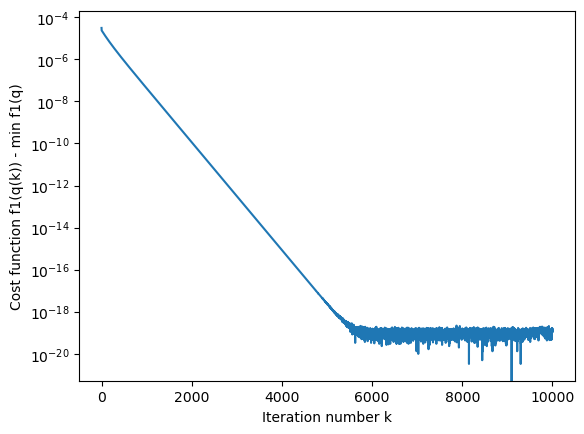

Calculating ellipsoid fit rmse...



100%|██████████| 55984/55984 [01:41<00:00, 550.33it/s]


Ellipsoid fit rmse is 3.1747724973874454 nm.
Ellipsoid fit: COP1 membrane axes is [55.83127754 30.79375361 25.29390504] nm
Ellipsoid fit: COP1 membrane Surface Area is 16834.80433350598 nm
Ellipsoid fit: COP1 membrane Volume is 182156.50672760222 nm
Sphericity index of best-fitting ellipsoid is 0.7192786846747278 for COP1 membrane.
Sphericity of best-fitting ellipsoid is 0.923079651623647 for COP1 membrane.

{'Image_Name': 'Position_2_2_memb_54_2-COP1.mrc', 'Image_Tag': 'COP1', 'info': {'sphere_center': array([308.48809675, 414.98041566, 169.29821598]), 'sphere_radius': 30.856440190181438, 'sphere_rmse': 5.068176257473003, 'sphere_radius_nm': 30.856440190181438, 'ellipsoid_center': array([308.22846055, 415.57978541, 166.98300108]), 'ellipsoid_axes': array([55.83127754, 30.79375361, 25.29390504]), 'ellipsoid_rotmat': array([[ 0.31835231,  0.00473962, -0.94796062],
       [-0.87036098,  0.39773814, -0.29030351],
       [-0.37566416, -0.91748674, -0.13074604]]), 'ellipsoid_residual': 1.43

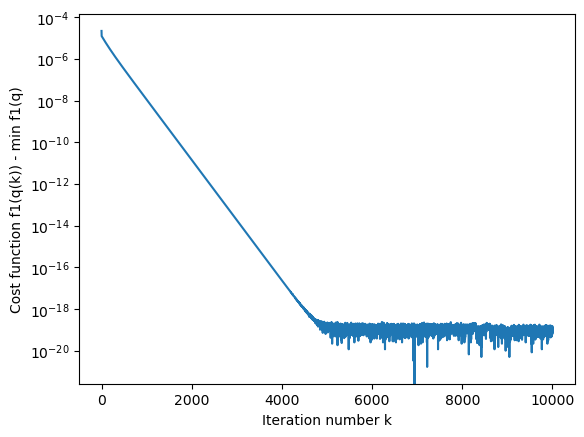

Calculating ellipsoid fit rmse...



100%|██████████| 49982/49982 [01:22<00:00, 608.67it/s]


Ellipsoid fit rmse is 2.5879864795279857 nm.
Ellipsoid fit: COP1 membrane axes is [25.56403049 28.57548967 33.9402592 ] nm
Ellipsoid fit: COP1 membrane Surface Area is 10799.85273762622 nm
Ellipsoid fit: COP1 membrane Volume is 103854.84744612912 nm
Sphericity index of best-fitting ellipsoid is 0.8766978456258497 for COP1 membrane.
Sphericity of best-fitting ellipsoid is 0.989351930582352 for COP1 membrane.

{'Image_Name': 'L31_LOW_3_2_HIGH_1_memb_27_1-COP1.mrc', 'Image_Tag': 'COP1', 'info': {'sphere_center': array([388.44749481, 375.05363384, 271.22664221]), 'sphere_radius': 27.682518606846706, 'sphere_rmse': 3.005520898257747, 'sphere_radius_nm': 27.682518606846706, 'ellipsoid_center': array([388.31001489, 373.00868494, 274.46214222]), 'ellipsoid_axes': array([25.56403049, 28.57548967, 33.9402592 ]), 'ellipsoid_rotmat': array([[ 0.87796265, -0.41440351, -0.23969003],
       [-0.46948674, -0.64741301, -0.60036539],
       [-0.09361508, -0.63962968,  0.7629614 ]]), 'ellipsoid_residual'

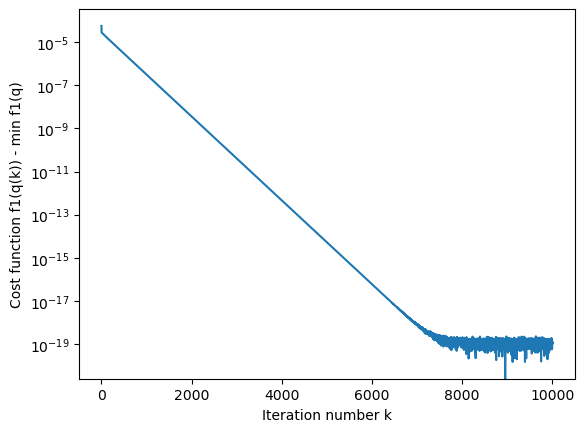

Calculating ellipsoid fit rmse...



100%|██████████| 25529/25529 [00:45<00:00, 555.74it/s]


Ellipsoid fit rmse is 1.9167652362728824 nm.
Ellipsoid fit: COP1 membrane axes is [41.13520534 35.68489576 36.21601827] nm
Ellipsoid fit: COP1 membrane Surface Area is 17823.603826974166 nm
Ellipsoid fit: COP1 membrane Volume is 222683.1786212373 nm
Sphericity index of best-fitting ellipsoid is 0.9490406867470326 for COP1 membrane.
Sphericity of best-fitting ellipsoid is 0.9968126606738184 for COP1 membrane.

{'Image_Name': 'L24_LOW_1_2_HIGH_1_memb_35_2-COP1.mrc', 'Image_Tag': 'COP1', 'info': {'sphere_center': array([343.74815116, 603.46236122, 196.34021113]), 'sphere_radius': 37.69072265051154, 'sphere_rmse': 2.1373232674220044, 'sphere_radius_nm': 37.69072265051154, 'ellipsoid_center': array([345.63468247, 603.22973806, 195.10807369]), 'ellipsoid_axes': array([41.13520534, 35.68489576, 36.21601827]), 'ellipsoid_rotmat': array([[-0.688232  ,  0.5748025 ,  0.44264976],
       [ 0.71495703,  0.43377146,  0.54834183],
       [-0.12317942, -0.69386195,  0.70949449]]), 'ellipsoid_residual'

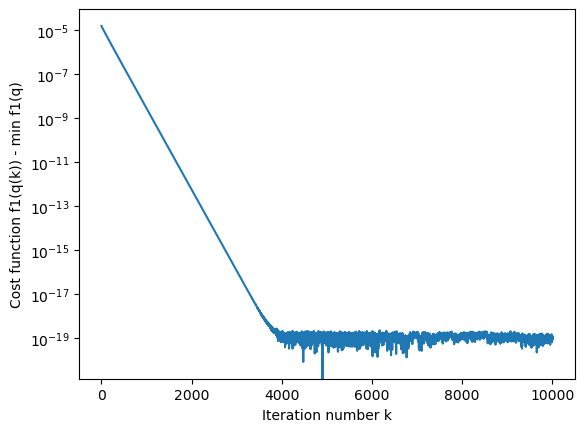

Calculating ellipsoid fit rmse...



100%|██████████| 67146/67146 [01:55<00:00, 581.09it/s]


Ellipsoid fit rmse is 2.597191038764126 nm.
Ellipsoid fit: COP2 membrane axes is [41.2764494  30.60459828 31.06711992] nm
Ellipsoid fit: COP2 membrane Surface Area is 14722.164219820266 nm
Ellipsoid fit: COP2 membrane Volume is 164391.2200171572 nm
Sphericity index of best-fitting ellipsoid is 0.9005821749860956 for COP2 membrane.
Sphericity of best-fitting ellipsoid is 0.985745672256671 for COP2 membrane.

{'Image_Name': 'L11_HIGH_3_7_memb_13_6-COP2.mrc', 'Image_Tag': 'COP2', 'info': {'sphere_center': array([286.73898605, 371.5773523 , 228.1117472 ]), 'sphere_radius': 32.20624702355964, 'sphere_rmse': 3.000436030975428, 'sphere_radius_nm': 32.20624702355964, 'ellipsoid_center': array([287.29069672, 371.5099935 , 226.71565603]), 'ellipsoid_axes': array([41.2764494 , 30.60459828, 31.06711992]), 'ellipsoid_rotmat': array([[ 0.03194065,  0.02093606, -0.99927047],
       [-0.91270085, -0.40688573, -0.03769834],
       [ 0.40737815, -0.91323912, -0.00611217]]), 'ellipsoid_residual': 6.66347

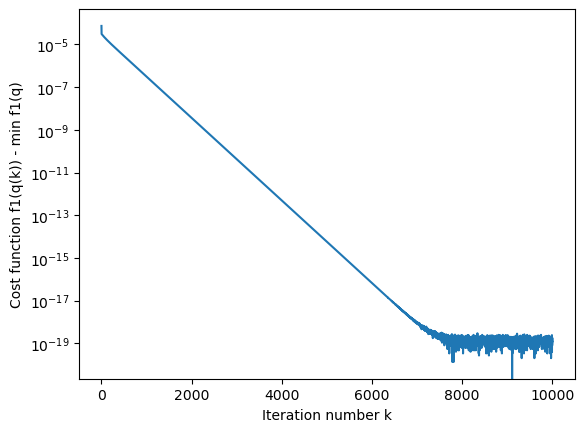

Calculating ellipsoid fit rmse...



100%|██████████| 10335/10335 [00:18<00:00, 561.23it/s]


Ellipsoid fit rmse is 2.2637642176669472 nm.
Ellipsoid fit: COP1 membrane axes is [26.71319692 63.27711726 37.65867286] nm
Ellipsoid fit: COP1 membrane Surface Area is 21986.54128957674 nm
Ellipsoid fit: COP1 membrane Volume is 266640.53459755564 nm
Sphericity index of best-fitting ellipsoid is 0.6690316726570253 for COP1 membrane.
Sphericity of best-fitting ellipsoid is 0.9111949896199936 for COP1 membrane.

{'Image_Name': 'L31_LOW_1_3_HIGH_1_memb_45_1-COP1.mrc', 'Image_Tag': 'COP1', 'info': {'sphere_center': array([508.3214089 , 739.22592691, 320.92089023]), 'sphere_radius': 30.313971555914108, 'sphere_rmse': 2.3919540383470976, 'sphere_radius_nm': 30.313971555914108, 'ellipsoid_center': array([483.18519748, 737.01634461, 298.61746627]), 'ellipsoid_axes': array([26.71319692, 63.27711726, 37.65867286]), 'ellipsoid_rotmat': array([[ 0.49773197, -0.10636041, -0.86078473],
       [-0.86727148, -0.04941539, -0.49537693],
       [-0.01015248, -0.99309898,  0.11683897]]), 'ellipsoid_residua

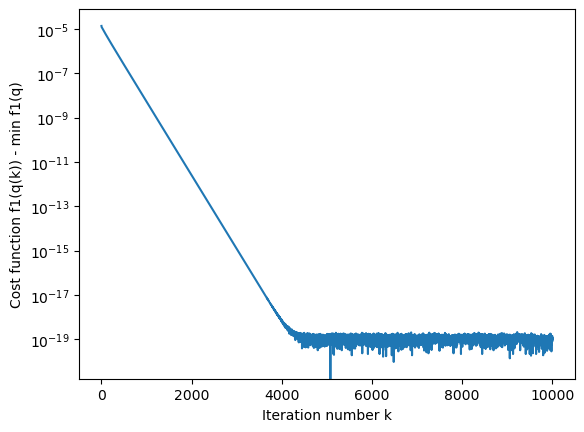

Calculating ellipsoid fit rmse...



100%|██████████| 80153/80153 [02:17<00:00, 582.61it/s]


Ellipsoid fit rmse is 2.565133624721231 nm.
Ellipsoid fit: COP1 membrane axes is [40.29949925 33.58645862 32.75198071] nm
Ellipsoid fit: COP1 membrane Surface Area is 15844.739854410896 nm
Ellipsoid fit: COP1 membrane Volume is 185690.6526412735 nm
Sphericity index of best-fitting ellipsoid is 0.9254161871818916 for COP1 membrane.
Sphericity of best-fitting ellipsoid is 0.9934035471902201 for COP1 membrane.

{'Image_Name': 'L24_LOW_1_2_HIGH_1_6_memb_74_1-COP1.mrc', 'Image_Tag': 'COP1', 'info': {'sphere_center': array([434.63419964, 332.5508179 , 179.92129518]), 'sphere_radius': 35.0976467938968, 'sphere_rmse': 3.14414766068006, 'sphere_radius_nm': 35.0976467938968, 'ellipsoid_center': array([434.48340633, 332.33990073, 179.40030782]), 'ellipsoid_axes': array([40.29949925, 33.58645862, 32.75198071]), 'ellipsoid_rotmat': array([[ 0.51329647,  0.31442401,  0.79853884],
       [ 0.67498616, -0.72255195, -0.14937325],
       [-0.53001926, -0.61567543,  0.58311522]]), 'ellipsoid_residual': 5

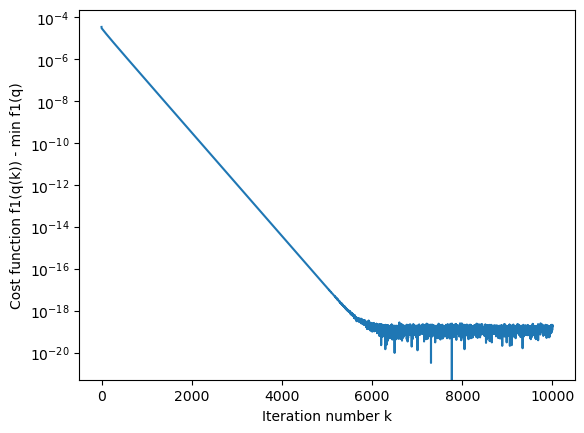

Calculating ellipsoid fit rmse...



100%|██████████| 34292/34292 [00:58<00:00, 585.38it/s]


Ellipsoid fit rmse is 2.651004241016609 nm.
Ellipsoid fit: COP1 membrane axes is [24.67167197 31.69382882 40.23661682] nm
Ellipsoid fit: COP1 membrane Surface Area is 12927.892287426315 nm
Ellipsoid fit: COP1 membrane Volume is 131790.27270823406 nm
Sphericity index of best-fitting ellipsoid is 0.7815084288339321 for COP1 membrane.
Sphericity of best-fitting ellipsoid is 0.9687505689961019 for COP1 membrane.

{'Image_Name': 'L25_LOW_2_HIGH_1_memb_15_2-COP1.mrc', 'Image_Tag': 'COP1', 'info': {'sphere_center': array([268.14995491, 162.49966838, 141.72435737]), 'sphere_radius': 28.471611568390784, 'sphere_rmse': 3.913941536048233, 'sphere_radius_nm': 28.471611568390784, 'ellipsoid_center': array([270.45876118, 161.32553229, 138.08305056]), 'ellipsoid_axes': array([24.67167197, 31.69382882, 40.23661682]), 'ellipsoid_rotmat': array([[-0.80178466, -0.5193141 , -0.2957266 ],
       [-0.42071259,  0.84193903, -0.33784551],
       [-0.4244317 ,  0.14646344,  0.89353578]]), 'ellipsoid_residual':

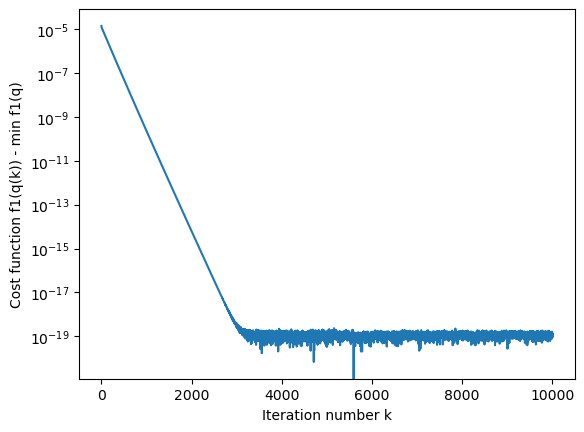

Calculating ellipsoid fit rmse...



100%|██████████| 117839/117839 [03:20<00:00, 587.03it/s]


Ellipsoid fit rmse is 3.182012420901425 nm.
Ellipsoid fit: COP2 membrane axes is [31.94176508 35.51709124 48.62881882] nm
Ellipsoid fit: COP2 membrane Surface Area is 18655.20792816676 nm
Ellipsoid fit: COP2 membrane Volume is 231088.65896409666 nm
Sphericity index of best-fitting ellipsoid is 0.8390649314403569 for COP2 membrane.
Sphericity of best-fitting ellipsoid is 0.976194714869407 for COP2 membrane.

{'Image_Name': 'L19_LOW_1_6_HIGH_1_2_memb_5_1-COP2.mrc', 'Image_Tag': 'COP2', 'info': {'sphere_center': array([ 52.15139454, 246.64889638, 203.11302451]), 'sphere_radius': 36.46816514608364, 'sphere_rmse': 4.43920897620307, 'sphere_radius_nm': 36.46816514608364, 'ellipsoid_center': array([ 50.92160935, 246.79029199, 204.30529917]), 'ellipsoid_axes': array([31.94176508, 35.51709124, 48.62881882]), 'ellipsoid_rotmat': array([[ 0.9199639 ,  0.37793054,  0.10409093],
       [ 0.39061687, -0.90611293, -0.16241249],
       [-0.0329375 , -0.1900733 ,  0.98121723]]), 'ellipsoid_residual': 8

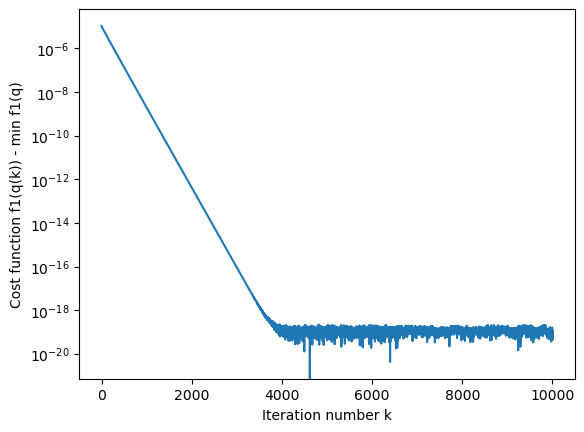

Calculating ellipsoid fit rmse...



100%|██████████| 66491/66491 [01:50<00:00, 599.77it/s]


Ellipsoid fit rmse is 2.5868768044753607 nm.
Ellipsoid fit: COP1 membrane axes is [33.22896374 28.63814066 30.00520739] nm
Ellipsoid fit: COP1 membrane Surface Area is 11775.35339668942 nm
Ellipsoid fit: COP1 membrane Volume is 119604.31766991527 nm
Sphericity index of best-fitting ellipsoid is 0.936969386843097 for COP1 membrane.
Sphericity of best-fitting ellipsoid is 0.996953142175171 for COP1 membrane.

{'Image_Name': 'L25_LOW_1_3_HIGH_1_2_memb_27_1-COP1.mrc', 'Image_Tag': 'COP1', 'info': {'sphere_center': array([347.482155  , 623.82075432, 127.84276096]), 'sphere_radius': 30.093094583565975, 'sphere_rmse': 2.730507178487455, 'sphere_radius_nm': 30.093094583565975, 'ellipsoid_center': array([347.53358584, 623.76705702, 127.51483358]), 'ellipsoid_axes': array([33.22896374, 28.63814066, 30.00520739]), 'ellipsoid_rotmat': array([[-0.20831747, -0.14701426,  0.96694914],
       [ 0.96131933,  0.15136358,  0.23011781],
       [ 0.18019149, -0.97748446, -0.10979597]]), 'ellipsoid_residual

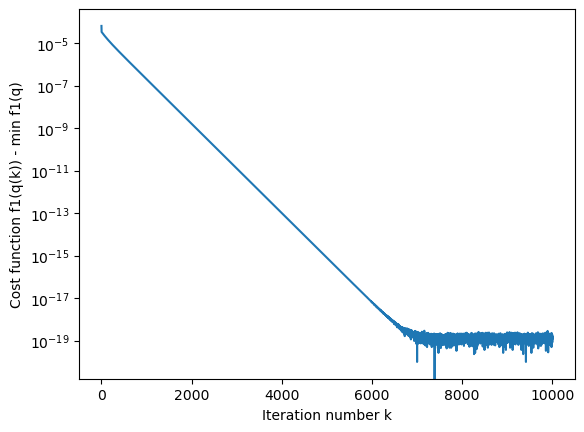

Calculating ellipsoid fit rmse...



100%|██████████| 51515/51515 [01:43<00:00, 500.08it/s]


Ellipsoid fit rmse is 2.8881659867583283 nm.
Ellipsoid fit: COP1 membrane axes is [130.2390575   29.78839634  38.48537695] nm
Ellipsoid fit: COP1 membrane Surface Area is 45136.07968834386 nm
Ellipsoid fit: COP1 membrane Volume is 625421.3782386162 nm
Sphericity index of best-fitting ellipsoid is 0.5615034374804789 for COP1 membrane.
Sphericity of best-fitting ellipsoid is 0.7835657365914745 for COP1 membrane.

{'Image_Name': 'Position_6_2_memb_24_1-COP1.mrc', 'Image_Tag': 'COP1', 'info': {'sphere_center': array([251.9526266 , 473.47026016, 158.79940682]), 'sphere_radius': 33.12258882085119, 'sphere_rmse': 6.655866300953878, 'sphere_radius_nm': 33.12258882085119, 'ellipsoid_center': array([207.04748347, 496.31302645,  93.51784035]), 'ellipsoid_axes': array([130.2390575 ,  29.78839634,  38.48537695]), 'ellipsoid_rotmat': array([[ 0.51986893, -0.33844168,  0.78434274],
       [-0.61337634, -0.78694491,  0.06698646],
       [-0.59456351,  0.51592145,  0.61670032]]), 'ellipsoid_residual': 

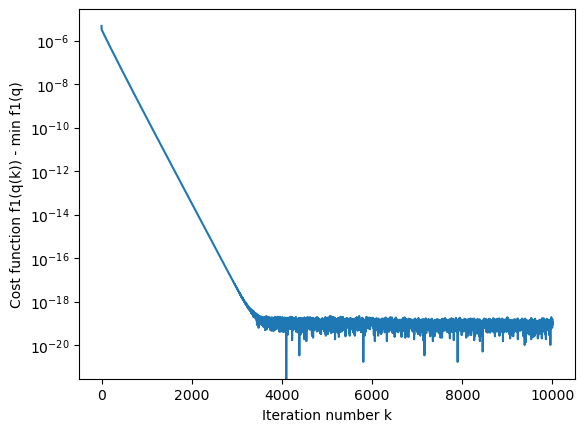

Calculating ellipsoid fit rmse...



100%|██████████| 99625/99625 [02:42<00:00, 613.51it/s]


Ellipsoid fit rmse is 3.1581112224926304 nm.
Ellipsoid fit: COP2 membrane axes is [27.66776354 31.05181462 34.94924122] nm
Ellipsoid fit: COP2 membrane Surface Area is 12228.49438988669 nm
Ellipsoid fit: COP2 membrane Volume is 125772.99438437796 nm
Sphericity index of best-fitting ellipsoid is 0.8901730835196456 for COP2 membrane.
Sphericity of best-fitting ellipsoid is 0.9927412539365348 for COP2 membrane.

{'Image_Name': 'L24_LOW_1_5_HIGH_1_memb_45_1-COP2.mrc', 'Image_Tag': 'COP2', 'info': {'sphere_center': array([264.75683077, 403.0559665 , 144.52198281]), 'sphere_radius': 30.7863644975597, 'sphere_rmse': 3.615930102562723, 'sphere_radius_nm': 30.7863644975597, 'ellipsoid_center': array([264.87807809, 402.80909949, 143.94968802]), 'ellipsoid_axes': array([27.66776354, 31.05181462, 34.94924122]), 'ellipsoid_rotmat': array([[ 0.12859547,  0.99109031,  0.0346872 ],
       [ 0.98262171, -0.13206189,  0.13043863],
       [-0.13385732, -0.01731058,  0.99084941]]), 'ellipsoid_residual': 1

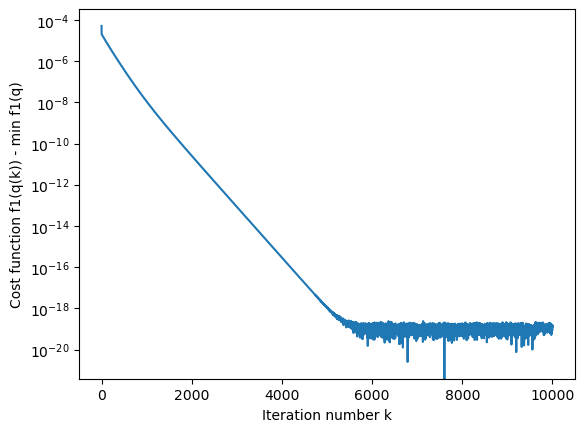

Calculating ellipsoid fit rmse...



100%|██████████| 18454/18454 [00:31<00:00, 577.96it/s]


Ellipsoid fit rmse is 1.8268685975714387 nm.
Ellipsoid fit: COP1 membrane axes is [31.60521176 23.51125394 25.39072866] nm
Ellipsoid fit: COP1 membrane Surface Area is 9014.724105696032 nm
Ellipsoid fit: COP1 membrane Volume is 79031.14437761274 nm
Sphericity index of best-fitting ellipsoid is 0.8831596903104817 for COP1 membrane.
Sphericity of best-fitting ellipsoid is 0.987939913980799 for COP1 membrane.

{'Image_Name': 'High_mag_L12_P1_2_memb_15_3-COP1.mrc', 'Image_Tag': 'COP1', 'info': {'sphere_center': array([411.15443698, 317.99439554, 197.01799456]), 'sphere_radius': 26.636734616372138, 'sphere_rmse': 2.3846735969584145, 'sphere_radius_nm': 26.636734616372138, 'ellipsoid_center': array([410.74374953, 317.7081518 , 199.72502745]), 'ellipsoid_axes': array([31.60521176, 23.51125394, 25.39072866]), 'ellipsoid_rotmat': array([[-0.52375949, -0.13261991, -0.84147963],
       [-0.84728089,  0.1834537 ,  0.49845745],
       [-0.08826717, -0.97404143,  0.20845193]]), 'ellipsoid_residual':

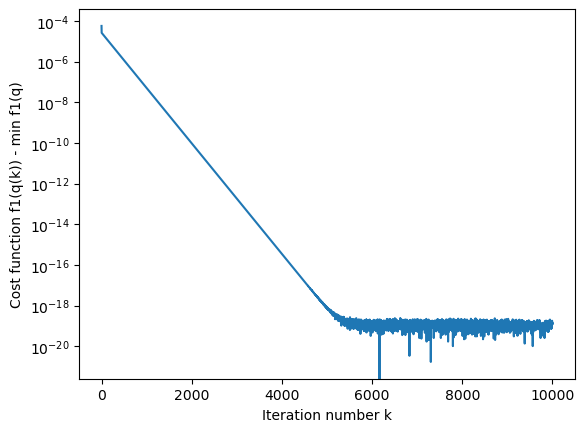

Calculating ellipsoid fit rmse...



100%|██████████| 26208/26208 [00:43<00:00, 604.59it/s]


Ellipsoid fit rmse is 2.7251675575333505 nm.
Ellipsoid fit: COP2 membrane axes is [36.67528718 28.87456484 24.4539043 ] nm
Ellipsoid fit: COP2 membrane Surface Area is 11239.89232714453 nm
Ellipsoid fit: COP2 membrane Volume is 108474.0333626441 nm
Sphericity index of best-fitting ellipsoid is 0.8265500348557544 for COP2 membrane.
Sphericity of best-fitting ellipsoid is 0.978601399965003 for COP2 membrane.

{'Image_Name': 'High_mag_L12_P1_2_memb_6_1-COP2.mrc', 'Image_Tag': 'COP2', 'info': {'sphere_center': array([240.93810223, 412.01888957,  88.74459539]), 'sphere_radius': 35.917783447646, 'sphere_rmse': 3.3279274963496634, 'sphere_radius_nm': 35.917783447646, 'ellipsoid_center': array([239.75647912, 421.4924989 ,  88.29786112]), 'ellipsoid_axes': array([36.67528718, 28.87456484, 24.4539043 ]), 'ellipsoid_rotmat': array([[-0.91725816, -0.10000692, -0.3855335 ],
       [-0.39828932,  0.22604415,  0.88897112],
       [ 0.00175567, -0.9689699 ,  0.24717253]]), 'ellipsoid_residual': 1.4832

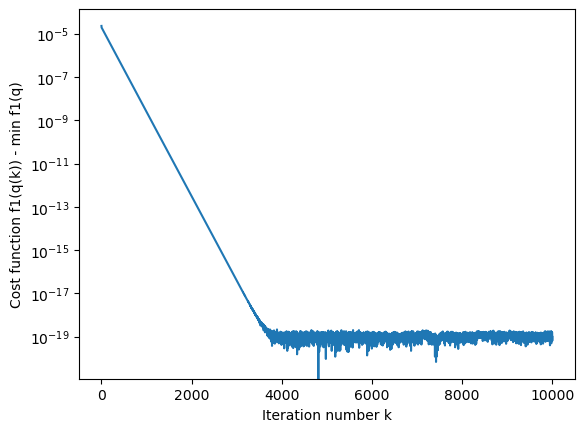

Calculating ellipsoid fit rmse...



100%|██████████| 24739/24739 [00:43<00:00, 574.10it/s]


Ellipsoid fit rmse is 1.8180921663779788 nm.
Ellipsoid fit: COP2 membrane axes is [34.11669808 25.62960135 24.52428405] nm
Ellipsoid fit: COP2 membrane Surface Area is 9858.077593553078 nm
Ellipsoid fit: COP2 membrane Volume is 89824.2894145481 nm
Sphericity index of best-fitting ellipsoid is 0.882730116818219 for COP2 membrane.
Sphericity of best-fitting ellipsoid is 0.9839078354522568 for COP2 membrane.

{'Image_Name': 'L11_HIGH_3_7_memb_23_1-COP2.mrc', 'Image_Tag': 'COP2', 'info': {'sphere_center': array([403.11356073,  87.13297464, 205.17917477]), 'sphere_radius': 27.21660249700266, 'sphere_rmse': 2.740846085148141, 'sphere_radius_nm': 27.21660249700266, 'ellipsoid_center': array([403.31286775,  87.07756154, 204.57623235]), 'ellipsoid_axes': array([34.11669808, 25.62960135, 24.52428405]), 'ellipsoid_rotmat': array([[ 0.16471079,  0.56544369, -0.80817312],
       [ 0.7640846 ,  0.44499549,  0.46706932],
       [-0.62373479,  0.69444399,  0.35875126]]), 'ellipsoid_residual': 4.823343

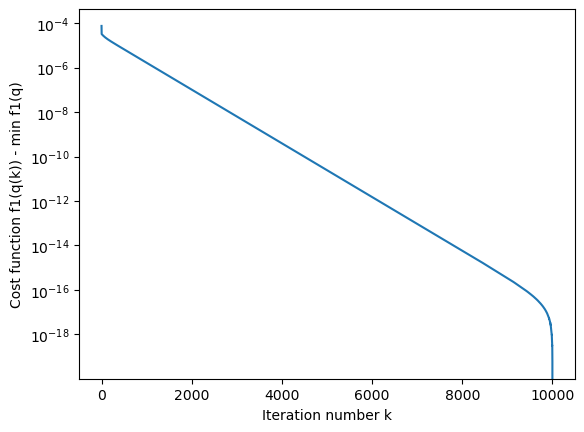

Ellipsoid fit did not converge in first run, re-try with 50000 iterations.


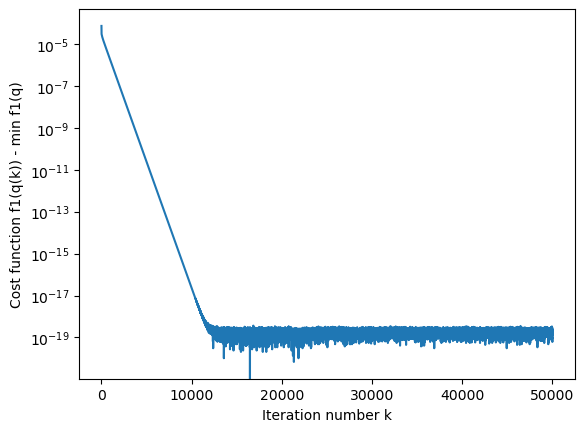

Ellipsoid still not converged in run 2.

{'Image_Name': 'High_mag_L27_P1_2_memb_50_2-COP2.mrc', 'Image_Tag': 'COP2', 'info': {'sphere_center': array([455.74867791, 350.17033497, 370.37027161]), 'sphere_radius': 37.252129251327574, 'sphere_rmse': 3.7306521196235556, 'sphere_radius_nm': 37.252129251327574, 'ellipsoid_center': array([540.76441281, 352.52222404, 476.95336852]), 'ellipsoid_axes': array([179.1049416 ,  66.28050677,  57.82431781]), 'ellipsoid_rotmat': array([[-0.61756347, -0.01707471, -0.78633569],
       [ 0.75639472, -0.2869443 , -0.58781799],
       [ 0.21559772,  0.95779508, -0.19012154]]), 'ellipsoid_residual': 1.7761732529117834e-05, 'ellipsoid_CF': array([9.27067189e-05, 5.07098882e-05, 5.01643040e-05, ...,
       1.77617325e-05, 1.77617325e-05, 1.77617325e-05]), 'ellipsoid_fit_converged': False, 'ellipsoid_fit_n_iter': 50000}}

L50_Position_8_memb_41_1-COP1.mrc

COP1

Input volume shape is (896, 896, 448)
Saved plot to: /nemo/lab/zanettig/home/users/downesk/Tomography

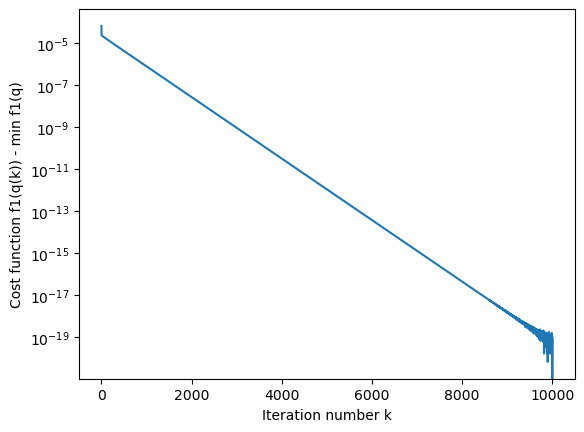

Calculating ellipsoid fit rmse...



100%|██████████| 5840/5840 [00:10<00:00, 582.70it/s]


Ellipsoid fit rmse is 1.401697084695549 nm.
Ellipsoid fit: COP1 membrane axes is [27.09051667 22.21048651 21.5479428 ] nm
Ellipsoid fit: COP1 membrane Surface Area is 6990.720326634149 nm
Ellipsoid fit: COP1 membrane Volume is 54308.74701176314 nm
Sphericity index of best-fitting ellipsoid is 0.9172310671316508 for COP1 membrane.
Sphericity of best-fitting ellipsoid is 0.9920693948189083 for COP1 membrane.

{'Image_Name': 'L50_Position_8_memb_41_1-COP1.mrc', 'Image_Tag': 'COP1', 'info': {'sphere_center': array([409.30515544, 822.41968355, 216.43304324]), 'sphere_radius': 24.060049708230242, 'sphere_rmse': 1.533108460335124, 'sphere_radius_nm': 24.060049708230242, 'ellipsoid_center': array([407.65725316, 824.14701779, 214.71954472]), 'ellipsoid_axes': array([27.09051667, 22.21048651, 21.5479428 ]), 'ellipsoid_rotmat': array([[-0.0786347 ,  0.95405226, -0.28913814],
       [ 0.98197769,  0.024127  , -0.18745055],
       [ 0.17186159,  0.29866732,  0.93875525]]), 'ellipsoid_residual': 9.5

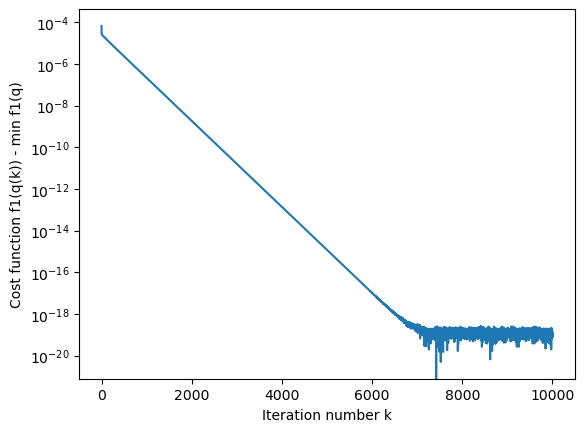

Calculating ellipsoid fit rmse...



100%|██████████| 21073/21073 [00:37<00:00, 567.65it/s]


Ellipsoid fit rmse is 1.9719413859968682 nm.
Ellipsoid fit: COP1 membrane axes is [25.35487846 29.86947859 36.42908639] nm
Ellipsoid fit: COP1 membrane Surface Area is 11674.60499754362 nm
Ellipsoid fit: COP1 membrane Volume is 115564.9308353795 nm
Sphericity index of best-fitting ellipsoid is 0.8391038524847718 for COP1 membrane.
Sphericity of best-fitting ellipsoid is 0.9827867776341018 for COP1 membrane.

{'Image_Name': 'L17_LOW_3_HIGH_1_4_memb_40_1-COP1.mrc', 'Image_Tag': 'COP1', 'info': {'sphere_center': array([ 98.19256252, 247.31186309,  80.78682287]), 'sphere_radius': 30.999827928578785, 'sphere_rmse': 2.1839203514825924, 'sphere_radius_nm': 30.999827928578785, 'ellipsoid_center': array([102.13971255, 248.89179954,  78.49456095]), 'ellipsoid_axes': array([25.35487846, 29.86947859, 36.42908639]), 'ellipsoid_rotmat': array([[ 0.95010418,  0.28161311, -0.13414955],
       [ 0.26709112, -0.95660395, -0.11649554],
       [ 0.16113466, -0.07485275,  0.98408978]]), 'ellipsoid_residual

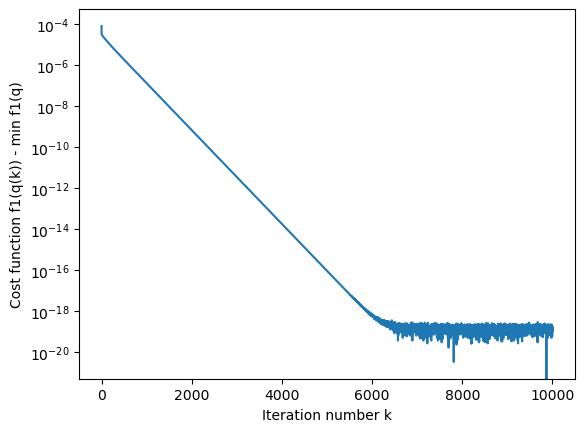

Calculating ellipsoid fit rmse...



100%|██████████| 36484/36484 [01:04<00:00, 569.79it/s]


Ellipsoid fit rmse is 2.7378036155486347 nm.
Ellipsoid fit: COP1 membrane axes is [45.35117039 34.47889906 30.84107811] nm
Ellipsoid fit: COP1 membrane Surface Area is 16986.982800593767 nm
Ellipsoid fit: COP1 membrane Volume is 202004.03755632334 nm
Sphericity index of best-fitting ellipsoid is 0.8473036377107392 for COP1 membrane.
Sphericity of best-fitting ellipsoid is 0.9801094518864586 for COP1 membrane.

{'Image_Name': 'L24_LOW_1_5_HIGH_1_memb_17_4-COP1.mrc', 'Image_Tag': 'COP1', 'info': {'sphere_center': array([316.56998867, 666.03825553, 185.8726834 ]), 'sphere_radius': 35.031294355951715, 'sphere_rmse': 3.505273451025508, 'sphere_radius_nm': 35.031294355951715, 'ellipsoid_center': array([315.31784293, 665.31701781, 190.17095859]), 'ellipsoid_axes': array([45.35117039, 34.47889906, 30.84107811]), 'ellipsoid_rotmat': array([[ 0.6145731 , -0.16810129, -0.77074111],
       [ 0.69833197,  0.57038022,  0.43243365],
       [-0.36692283,  0.80399525, -0.46793085]]), 'ellipsoid_residua

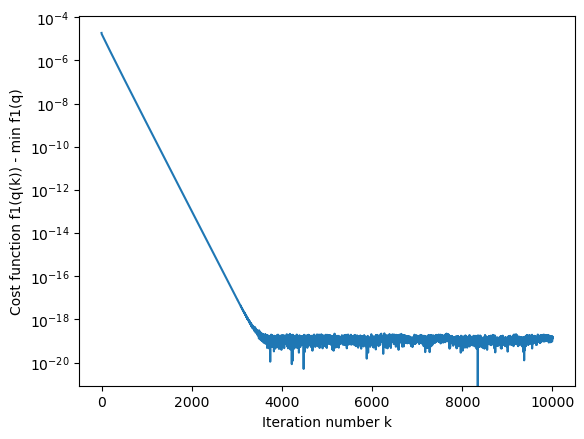

Calculating ellipsoid fit rmse...



100%|██████████| 96034/96034 [02:46<00:00, 576.86it/s]


Ellipsoid fit rmse is 2.8166868452069687 nm.
Ellipsoid fit: COP2 membrane axes is [42.8583984  34.89643867 36.16503866] nm
Ellipsoid fit: COP2 membrane Surface Area is 18085.441292891544 nm
Ellipsoid fit: COP2 membrane Volume is 226565.92223242807 nm
Sphericity index of best-fitting ellipsoid is 0.9227395056189067 for COP2 membrane.
Sphericity of best-fitting ellipsoid is 0.9937673860842319 for COP2 membrane.

{'Image_Name': 'L24_LOW_2_4_HIGH_1_memb_20_1-COP2.mrc', 'Image_Tag': 'COP2', 'info': {'sphere_center': array([247.44240417, 833.61625749,  77.8021125 ]), 'sphere_radius': 36.34171612081446, 'sphere_rmse': 3.0840753365002316, 'sphere_radius_nm': 36.34171612081446, 'ellipsoid_center': array([247.47214683, 833.15120084,  75.17832698]), 'ellipsoid_axes': array([42.8583984 , 34.89643867, 36.16503866]), 'ellipsoid_rotmat': array([[-0.05436793, -0.03226226,  0.99799964],
       [-0.99659715,  0.06376624, -0.05223016],
       [ 0.06195362,  0.99744324,  0.03561932]]), 'ellipsoid_residual

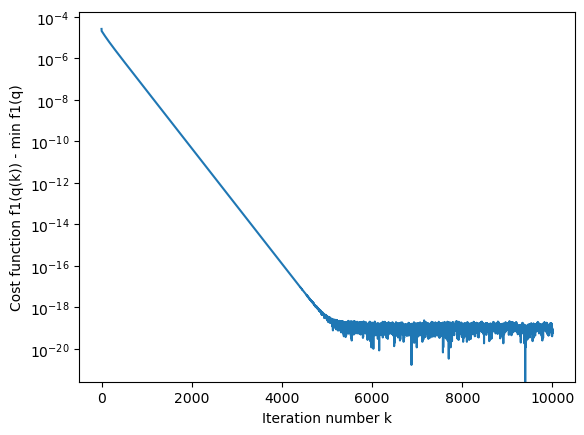

Calculating ellipsoid fit rmse...



100%|██████████| 59245/59245 [01:39<00:00, 597.88it/s]


Ellipsoid fit rmse is 2.829978851147128 nm.
Ellipsoid fit: COP2 membrane axes is [40.02177465 34.27288651 34.67151555] nm
Ellipsoid fit: COP2 membrane Surface Area is 16559.413107870692 nm
Ellipsoid fit: COP2 membrane Volume is 199208.77285939516 nm
Sphericity index of best-fitting ellipsoid is 0.9459700775299248 for COP2 membrane.
Sphericity of best-fitting ellipsoid is 0.9961196117904333 for COP2 membrane.

{'Image_Name': 'L24_LOW_2_4_HIGH_1_memb_18_1-COP2.mrc', 'Image_Tag': 'COP2', 'info': {'sphere_center': array([215.0219464 , 743.00359103,  61.74997955]), 'sphere_radius': 37.292763029008256, 'sphere_rmse': 3.2438123607486125, 'sphere_radius_nm': 37.292763029008256, 'ellipsoid_center': array([215.3824966 , 743.82100842,  62.98848215]), 'ellipsoid_axes': array([40.02177465, 34.27288651, 34.67151555]), 'ellipsoid_rotmat': array([[-0.89750733, -0.42193035,  0.12827849],
       [-0.40291681,  0.90279237,  0.1504127 ],
       [ 0.17927253, -0.08331094,  0.9802656 ]]), 'ellipsoid_residua

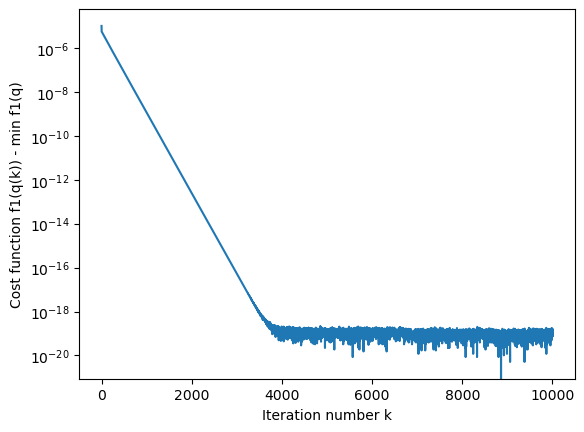

Calculating ellipsoid fit rmse...



100%|██████████| 126355/126355 [03:29<00:00, 603.78it/s]


Ellipsoid fit rmse is 3.476146433801515 nm.
Ellipsoid fit: COP2 membrane axes is [29.61487063 44.07275673 35.08437404] nm
Ellipsoid fit: COP2 membrane Surface Area is 16422.87024263721 nm
Ellipsoid fit: COP2 membrane Volume is 191814.92564572286 nm
Sphericity index of best-fitting ellipsoid is 0.8277742457866947 for COP2 membrane.
Sphericity of best-fitting ellipsoid is 0.9793922463806393 for COP2 membrane.

{'Image_Name': 'L13_LOW_2_3_HIGH_1_memb_44_1-COP2.mrc', 'Image_Tag': 'COP2', 'info': {'sphere_center': array([576.4148889 , 597.41402767, 270.15678226]), 'sphere_radius': 35.230781429726434, 'sphere_rmse': 4.979528791344558, 'sphere_radius_nm': 35.230781429726434, 'ellipsoid_center': array([576.02494445, 596.27425292, 271.54166594]), 'ellipsoid_axes': array([29.61487063, 44.07275673, 35.08437404]), 'ellipsoid_rotmat': array([[ 0.99620818, -0.05720779,  0.06554794],
       [-0.08201816, -0.86885977,  0.48821689],
       [-0.02902216,  0.49174178,  0.87025728]]), 'ellipsoid_residual'

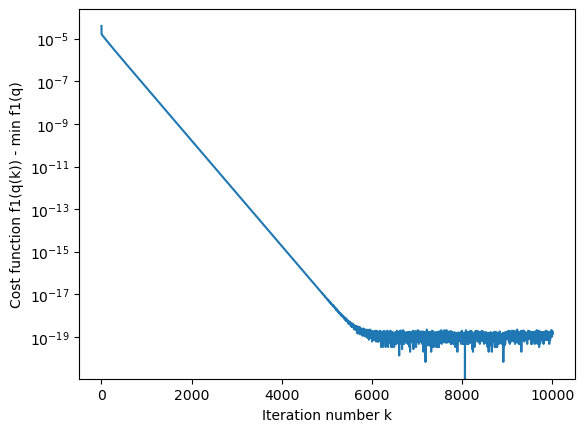

Calculating ellipsoid fit rmse...



100%|██████████| 18605/18605 [00:30<00:00, 616.43it/s]


Ellipsoid fit rmse is 2.8115218954341517 nm.
Ellipsoid fit: COP1 membrane axes is [14.54074209 18.08278906 28.24089008] nm
Ellipsoid fit: COP1 membrane Surface Area is 5061.372223639844 nm
Ellipsoid fit: COP1 membrane Volume is 31104.195823570535 nm
Sphericity index of best-fitting ellipsoid is 0.7453205837305932 for COP1 membrane.
Sphericity of best-fitting ellipsoid is 0.9449927981545646 for COP1 membrane.

{'Image_Name': 'L24_LOW_1_HIGH_1_memb_67_5-COP1.mrc', 'Image_Tag': 'COP1', 'info': {'sphere_center': array([611.39293527, 349.79406236, 255.97309966]), 'sphere_radius': 22.801373796505228, 'sphere_rmse': 3.695869869834975, 'sphere_radius_nm': 22.801373796505228, 'ellipsoid_center': array([617.54709151, 348.222898  , 256.8222177 ]), 'ellipsoid_axes': array([14.54074209, 18.08278906, 28.24089008]), 'ellipsoid_rotmat': array([[ 0.91057039, -0.39432494,  0.12397344],
       [-0.41307299, -0.87911917,  0.23773976],
       [-0.01524071,  0.26768887,  0.96338486]]), 'ellipsoid_residual':

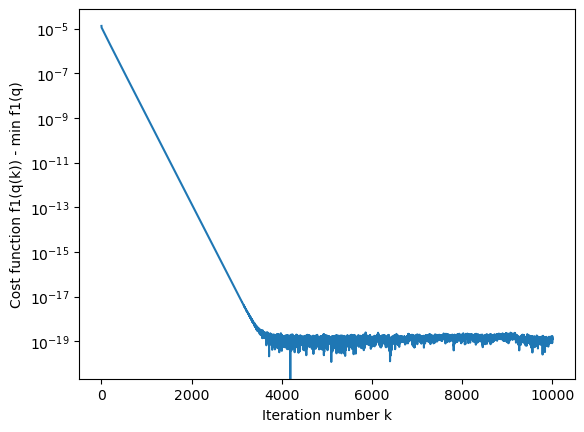

Calculating ellipsoid fit rmse...



100%|██████████| 104045/104045 [02:59<00:00, 579.65it/s]


Ellipsoid fit rmse is 2.697526596963759 nm.
Ellipsoid fit: COP2 membrane axes is [33.61996749 33.03293442 45.59030063] nm
Ellipsoid fit: COP2 membrane Surface Area is 17484.599906802316 nm
Ellipsoid fit: COP2 membrane Volume is 212082.82987348034 nm
Sphericity index of best-fitting ellipsoid is 0.8929110312346916 for COP2 membrane.
Sphericity of best-fitting ellipsoid is 0.9836307535087315 for COP2 membrane.

{'Image_Name': 'L24_LOW_2_6_HIGH_1_memb_43_1-COP2.mrc', 'Image_Tag': 'COP2', 'info': {'sphere_center': array([471.32390561, 459.91694817, 280.88653342]), 'sphere_radius': 35.12389939844749, 'sphere_rmse': 3.4366074859087954, 'sphere_radius_nm': 35.12389939844749, 'ellipsoid_center': array([471.81244519, 460.12347529, 285.26306425]), 'ellipsoid_axes': array([33.61996749, 33.03293442, 45.59030063]), 'ellipsoid_rotmat': array([[-0.90444902, -0.42583102, -0.02529647],
       [-0.42562597,  0.90480186, -0.013271  ],
       [-0.0285395 ,  0.00123611,  0.9995919 ]]), 'ellipsoid_residual'

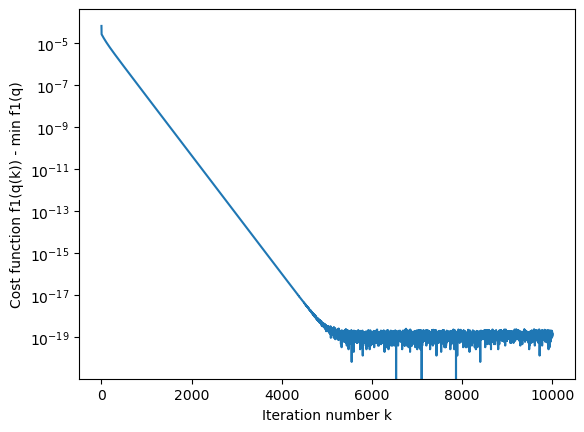

Calculating ellipsoid fit rmse...



100%|██████████| 31301/31301 [00:51<00:00, 611.99it/s]


Ellipsoid fit rmse is 3.352312637888867 nm.
Ellipsoid fit: COP2 membrane axes is [24.53282819 34.75314067 35.47867941] nm
Ellipsoid fit: COP2 membrane Surface Area is 12498.955377465098 nm
Ellipsoid fit: COP2 membrane Volume is 126706.16052046114 nm
Sphericity index of best-fitting ellipsoid is 0.7873682715796532 for COP2 membrane.
Sphericity of best-fitting ellipsoid is 0.9760578551119546 for COP2 membrane.

{'Image_Name': 'L55_Position_2_3_memb_55_1-COP2.mrc', 'Image_Tag': 'COP2', 'info': {'sphere_center': array([486.6231745 , 207.26936572,  45.94978349]), 'sphere_radius': 32.954039133654014, 'sphere_rmse': 3.839647660721438, 'sphere_radius_nm': 32.954039133654014, 'ellipsoid_center': array([480.78521778, 209.95356483,  49.5397516 ]), 'ellipsoid_axes': array([24.53282819, 34.75314067, 35.47867941]), 'ellipsoid_rotmat': array([[ 0.6870411 , -0.7080483 , -0.16322418],
       [-0.72446935, -0.68476677, -0.07898505],
       [ 0.05584526, -0.17251689,  0.9834222 ]]), 'ellipsoid_residual':

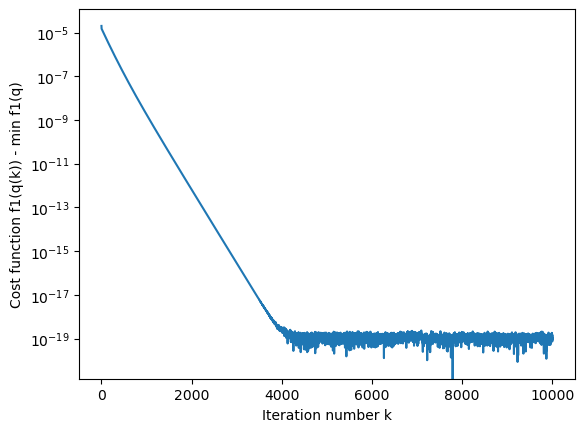

Calculating ellipsoid fit rmse...



100%|██████████| 73347/73347 [02:07<00:00, 573.79it/s]


Ellipsoid fit rmse is 2.6839715172329237 nm.
Ellipsoid fit: COP1 membrane axes is [29.516771   45.12728229 37.4778306 ] nm
Ellipsoid fit: COP1 membrane Surface Area is 17457.463962007987 nm
Ellipsoid fit: COP1 membrane Volume is 209108.2072318093 nm
Sphericity index of best-fitting ellipsoid is 0.8016313430901701 for COP1 membrane.
Sphericity of best-fitting ellipsoid is 0.9759263019893158 for COP1 membrane.

{'Image_Name': 'L25_LOW_1_3_HIGH_1_2_memb_3_5-COP1.mrc', 'Image_Tag': 'COP1', 'info': {'sphere_center': array([217.06217997, 580.78680501, 216.2517592 ]), 'sphere_radius': 35.85203313392618, 'sphere_rmse': 3.9431198531621408, 'sphere_radius_nm': 35.85203313392618, 'ellipsoid_center': array([216.13887811, 580.4754454 , 214.98700095]), 'ellipsoid_axes': array([29.516771  , 45.12728229, 37.4778306 ]), 'ellipsoid_rotmat': array([[ 0.92448197, -0.00277789,  0.38121566],
       [-0.37173216, -0.22834112,  0.89981972],
       [-0.08454761,  0.97357723,  0.21212988]]), 'ellipsoid_residual

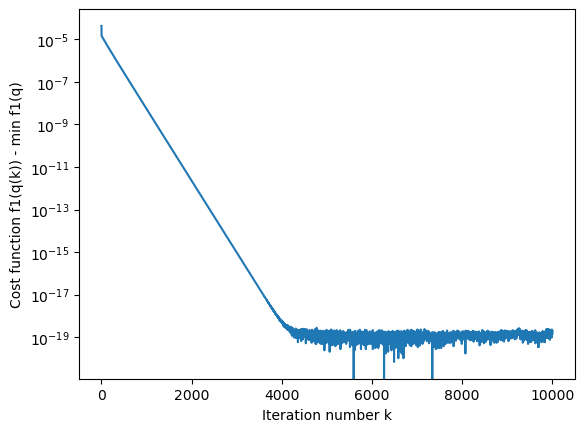

Calculating ellipsoid fit rmse...



100%|██████████| 22892/22892 [00:36<00:00, 623.17it/s]


Ellipsoid fit rmse is 2.2544915428529877 nm.
Ellipsoid fit: COP1 membrane axes is [27.20693393 22.59494059 21.75460036] nm
Ellipsoid fit: COP1 membrane Surface Area is 7132.679125946644 nm
Ellipsoid fit: COP1 membrane Volume is 56018.377319002546 nm
Sphericity index of best-fitting ellipsoid is 0.9165098521135819 for COP1 membrane.
Sphericity of best-fitting ellipsoid is 0.9926247974157278 for COP1 membrane.

{'Image_Name': 'High_mag_L12_P1_2_memb_7_14-COP1.mrc', 'Image_Tag': 'COP1', 'info': {'sphere_center': array([350.72122258, 489.07783294, 233.50557688]), 'sphere_radius': 25.226779901283855, 'sphere_rmse': 2.5753463660499976, 'sphere_radius_nm': 25.226779901283855, 'ellipsoid_center': array([352.53521547, 490.71540655, 232.84273511]), 'ellipsoid_axes': array([27.20693393, 22.59494059, 21.75460036]), 'ellipsoid_rotmat': array([[ 0.36691136,  0.04948579,  0.92893876],
       [ 0.77191351,  0.54109532, -0.33371453],
       [ 0.51915854, -0.83950403, -0.16033527]]), 'ellipsoid_residual

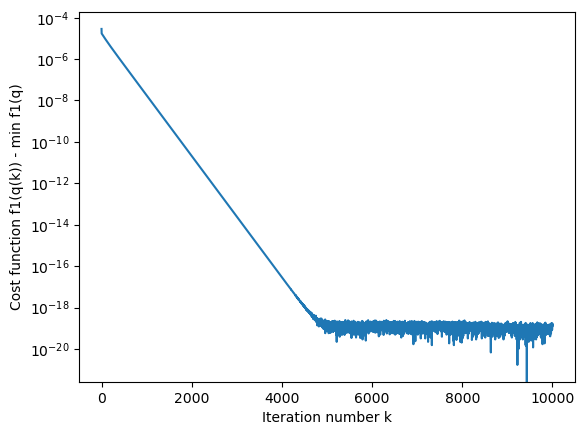

Calculating ellipsoid fit rmse...



100%|██████████| 56689/56689 [01:36<00:00, 588.34it/s]


Ellipsoid fit rmse is 2.6866385786085747 nm.
Ellipsoid fit: COP1 membrane axes is [39.7906635  30.04102159 33.43188611] nm
Ellipsoid fit: COP1 membrane Surface Area is 14844.420030572222 nm
Ellipsoid fit: COP1 membrane Volume is 167396.11185507677 nm
Sphericity index of best-fitting ellipsoid is 0.878676702910997 for COP1 membrane.
Sphericity of best-fitting ellipsoid is 0.9895045622701791 for COP1 membrane.

{'Image_Name': 'L24_LOW_1_2_HIGH_1_5_memb_13_1-COP1.mrc', 'Image_Tag': 'COP1', 'info': {'sphere_center': array([314.40693452, 537.99988853, 170.64856393]), 'sphere_radius': 32.73120075567882, 'sphere_rmse': 3.378668656538839, 'sphere_radius_nm': 32.73120075567882, 'ellipsoid_center': array([313.01652543, 536.47434276, 172.038525  ]), 'ellipsoid_axes': array([39.7906635 , 30.04102159, 33.43188611]), 'ellipsoid_rotmat': array([[ 0.66675655,  0.32990714, -0.66827911],
       [ 0.71405916, -0.53958587,  0.44605672],
       [ 0.21343667,  0.77460207,  0.59534563]]), 'ellipsoid_residual

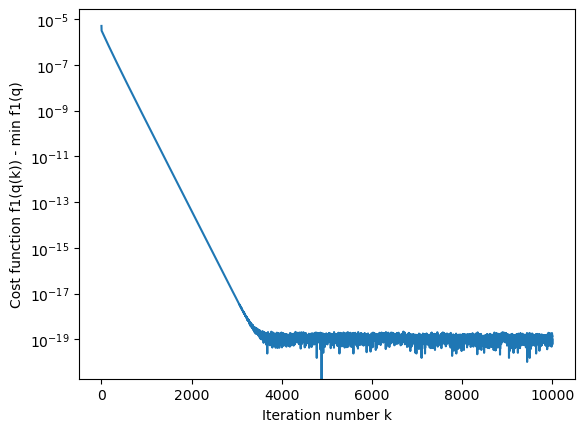

Calculating ellipsoid fit rmse...



100%|██████████| 40227/40227 [01:10<00:00, 571.40it/s]


Ellipsoid fit rmse is 2.547169179284841 nm.
Ellipsoid fit: COP2 membrane axes is [47.99239269 36.06267508 36.77262616] nm
Ellipsoid fit: COP2 membrane Surface Area is 20292.238642527846 nm
Ellipsoid fit: COP2 membrane Volume is 266589.8421027338 nm
Sphericity index of best-fitting ellipsoid is 0.9032464768639715 for COP2 membrane.
Sphericity of best-fitting ellipsoid is 0.9871501783904361 for COP2 membrane.

{'Image_Name': 'High_mag_L27_3__2_memb_72_1-COP2.mrc', 'Image_Tag': 'COP2', 'info': {'sphere_center': array([560.3807422 ,  76.51364145, 226.88511669]), 'sphere_radius': 42.223127586917755, 'sphere_rmse': 4.755857323127754, 'sphere_radius_nm': 42.223127586917755, 'ellipsoid_center': array([559.65854522,  76.39336211, 226.91625726]), 'ellipsoid_axes': array([47.99239269, 36.06267508, 36.77262616]), 'ellipsoid_rotmat': array([[-0.73369067, -0.67147629,  0.10400767],
       [-0.65535517,  0.6588698 , -0.36932396],
       [-0.17946477,  0.33913151,  0.92346208]]), 'ellipsoid_residual':

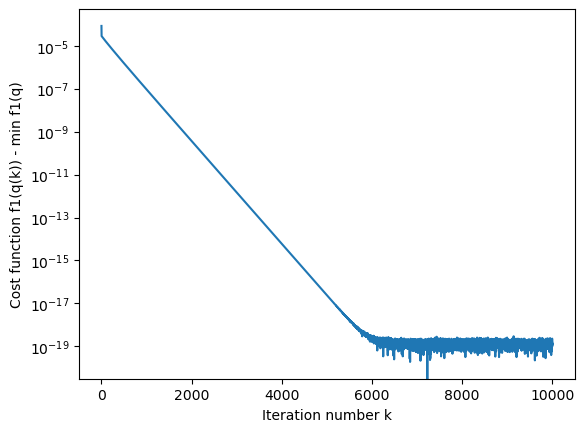

Calculating ellipsoid fit rmse...



100%|██████████| 46719/46719 [01:28<00:00, 525.83it/s]


Ellipsoid fit rmse is 1.8843273036859494 nm.
Ellipsoid fit: COP1 membrane axes is [50.3775678  41.24983492 60.35035448] nm
Ellipsoid fit: COP1 membrane Surface Area is 32100.463101619553 nm
Ellipsoid fit: COP1 membrane Volume is 525324.729651726 nm
Sphericity index of best-fitting ellipsoid is 0.8240921983211742 for COP1 membrane.
Sphericity of best-fitting ellipsoid is 0.9808246916896532 for COP1 membrane.

{'Image_Name': 'L29_LOW_2_2_HIGH_1_3_memb_7_3-COP1.mrc', 'Image_Tag': 'COP1', 'info': {'sphere_center': array([572.11454608, 735.0278932 , 139.2677812 ]), 'sphere_radius': 55.742622282892434, 'sphere_rmse': 2.409394217410081, 'sphere_radius_nm': 55.742622282892434, 'ellipsoid_center': array([571.2813244 , 747.72584897, 137.64834417]), 'ellipsoid_axes': array([50.3775678 , 41.24983492, 60.35035448]), 'ellipsoid_rotmat': array([[-0.9994952 , -0.02383337, -0.02100775],
       [-0.01970002,  0.98370006, -0.1787347 ],
       [-0.02492517,  0.17823062,  0.98367301]]), 'ellipsoid_residual

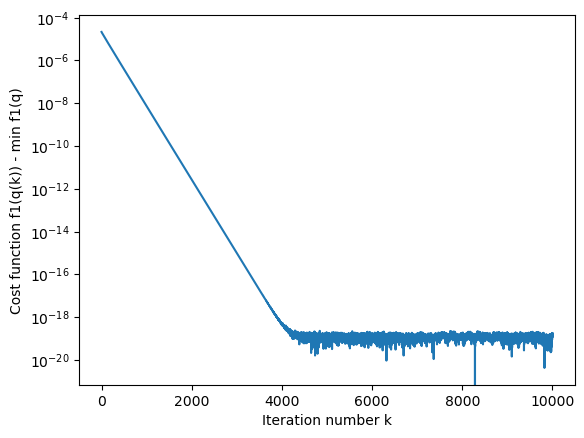

Calculating ellipsoid fit rmse...



100%|██████████| 55289/55289 [01:35<00:00, 579.04it/s]


Ellipsoid fit rmse is 2.508978422367507 nm.
Ellipsoid fit: COP2 membrane axes is [39.68566839 31.15116624 30.38161274] nm
Ellipsoid fit: COP2 membrane Surface Area is 14250.970494796193 nm
Ellipsoid fit: COP2 membrane Volume is 157328.51470238745 nm
Sphericity index of best-fitting ellipsoid is 0.9072031424543752 for COP2 membrane.
Sphericity of best-fitting ellipsoid is 0.9889582975957442 for COP2 membrane.

{'Image_Name': 'L13_LOW_7_2_HIGH_1_memb_26_2-COP2.mrc', 'Image_Tag': 'COP2', 'info': {'sphere_center': array([301.57848876, 723.40602941, 386.91353609]), 'sphere_radius': 31.703019668927304, 'sphere_rmse': 2.7224787281477023, 'sphere_radius_nm': 31.703019668927304, 'ellipsoid_center': array([301.76231264, 723.58923555, 386.67477752]), 'ellipsoid_axes': array([39.68566839, 31.15116624, 30.38161274]), 'ellipsoid_rotmat': array([[-0.28746641, -0.17844405,  0.94102114],
       [-0.95337976,  0.14749405, -0.26327275],
       [ 0.09181557,  0.97283258,  0.21252453]]), 'ellipsoid_residua

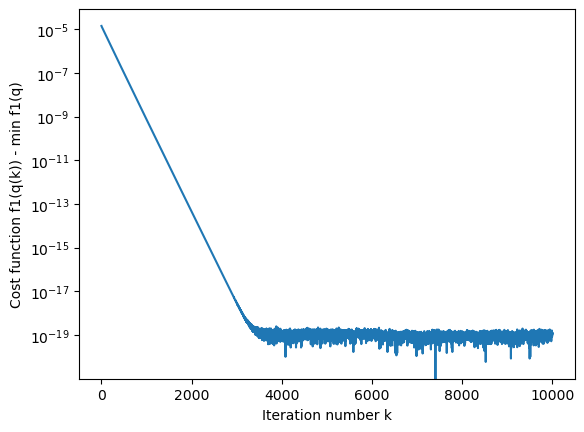

Calculating ellipsoid fit rmse...



 52%|█████▏    | 43939/83873 [01:13<01:12, 550.05it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████| 112595/112595 [03:11<00:00, 588.55it/s]


Ellipsoid fit rmse is 3.2243376724882853 nm.
Ellipsoid fit: COP2 membrane axes is [47.96791715 27.89771532 29.60164225] nm
Ellipsoid fit: COP2 membrane Surface Area is 15237.253597241459 nm
Ellipsoid fit: COP2 membrane Volume is 165929.61829744224 nm
Sphericity index of best-fitting ellipsoid is 0.8183835098566222 for COP2 membrane.
Sphericity of best-fitting ellipsoid is 0.9583556440932738 for COP2 membrane.

{'Image_Name': 'High_mag_L12_P1_2_memb_4_1-COP2.mrc', 'Image_Tag': 'COP2', 'info': {'sphere_center': array([577.1857057 , 327.71646301, 179.26072892]), 'sphere_radius': 34.22376008439795, 'sphere_rmse': 6.004361035677547, 'sphere_radius_nm': 34.22376008439795, 'ellipsoid_center': array([577.25347724, 326.02339825, 180.05941929]), 'ellipsoid_axes': array([47.96791715, 27.89771532, 29.60164225]), 'ellipsoid_rotmat': array([[-0.06282312, -0.97391406,  0.21804739],
       [-0.99489348,  0.07840601,  0.06355683],
       [ 0.07899511,  0.21294109,  0.97386645]]), 'ellipsoid_residual': 

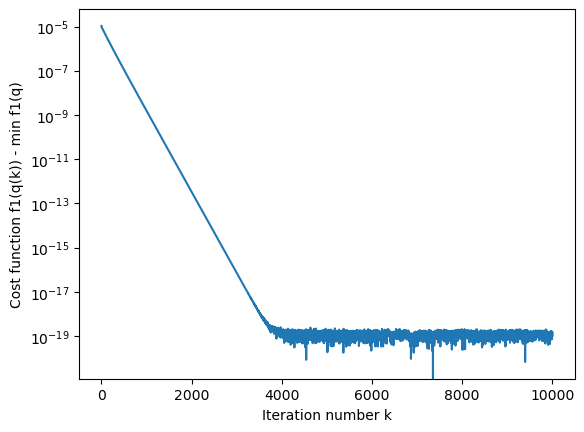

Calculating ellipsoid fit rmse...



100%|██████████| 82094/82094 [02:20<00:00, 582.38it/s]


Ellipsoid fit rmse is 2.503883705424554 nm.
Ellipsoid fit: COP2 membrane axes is [30.28317606 32.51051171 42.32224767] nm
Ellipsoid fit: COP2 membrane Surface Area is 15344.23746153776 nm
Ellipsoid fit: COP2 membrane Volume is 174535.01209159617 nm
Sphericity index of best-fitting ellipsoid is 0.8735144716939547 for COP2 membrane.
Sphericity of best-fitting ellipsoid is 0.9842993249285991 for COP2 membrane.

{'Image_Name': 'L17_LOW_1_2_HIGH_1_memb_8_2-COP2.mrc', 'Image_Tag': 'COP2', 'info': {'sphere_center': array([671.91793357, 478.10812955, 211.40342442]), 'sphere_radius': 33.38573173891938, 'sphere_rmse': 3.3273379968742107, 'sphere_radius_nm': 33.38573173891938, 'ellipsoid_center': array([671.75553015, 477.83036122, 208.89532337]), 'ellipsoid_axes': array([30.28317606, 32.51051171, 42.32224767]), 'ellipsoid_rotmat': array([[ 0.92909733, -0.34717728,  0.12746012],
       [-0.36227686, -0.92367174,  0.12484391],
       [-0.07438834,  0.162168  ,  0.98395524]]), 'ellipsoid_residual': 

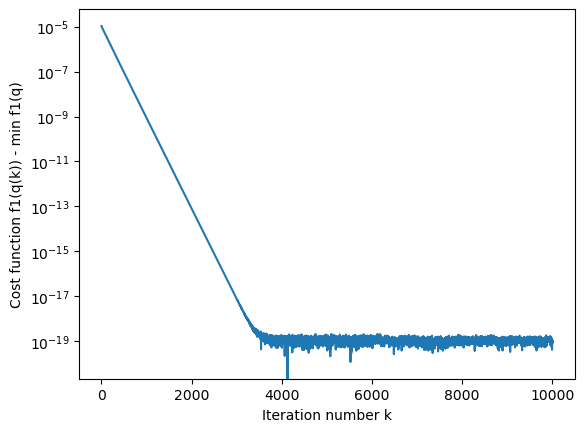

Calculating ellipsoid fit rmse...



100%|██████████| 157020/157020 [04:36<00:00, 566.90it/s]


Ellipsoid fit rmse is 2.9592886140469363 nm.
Ellipsoid fit: COP1 membrane axes is [55.3830731  43.51960041 47.81062045] nm
Ellipsoid fit: COP1 membrane Surface Area is 29990.092581964764 nm
Ellipsoid fit: COP1 membrane Volume is 482697.3764369158 nm
Sphericity index of best-fitting ellipsoid is 0.8943128193132239 for COP1 membrane.
Sphericity of best-fitting ellipsoid is 0.9922541948001656 for COP1 membrane.

{'Image_Name': 'L31_LOW_1_2_HIGH_1_memb_58_1-COP1.mrc', 'Image_Tag': 'COP1', 'info': {'sphere_center': array([497.92442226, 558.10159467, 341.93236798]), 'sphere_radius': 48.587981149581935, 'sphere_rmse': 4.372483911805268, 'sphere_radius_nm': 48.587981149581935, 'ellipsoid_center': array([498.17072333, 558.41025368, 341.98007738]), 'ellipsoid_axes': array([55.3830731 , 43.51960041, 47.81062045]), 'ellipsoid_rotmat': array([[ 0.41062262,  0.65490617,  0.6344186 ],
       [ 0.70540909, -0.66903584,  0.23407064],
       [-0.57774309, -0.35140995,  0.73669802]]), 'ellipsoid_residual

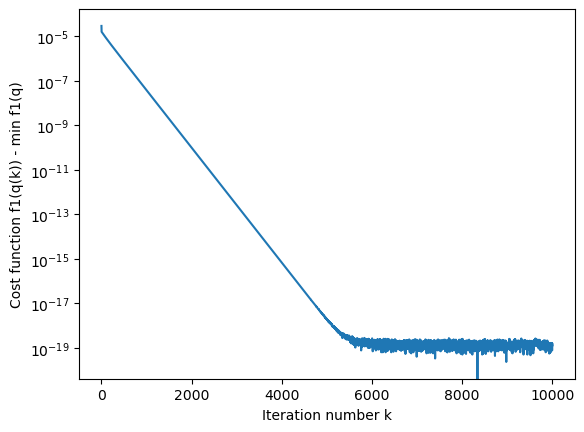

Calculating ellipsoid fit rmse...



100%|██████████| 61712/61712 [01:47<00:00, 572.82it/s]


Ellipsoid fit rmse is 3.2037745133274105 nm.
Ellipsoid fit: COP2 membrane axes is [51.46363111 28.45244951 26.54736333] nm
Ellipsoid fit: COP2 membrane Surface Area is 15341.172047743992 nm
Ellipsoid fit: COP2 membrane Volume is 162828.37537450742 nm
Sphericity index of best-fitting ellipsoid is 0.7836838557297964 for COP2 membrane.
Sphericity of best-fitting ellipsoid is 0.9399663586196985 for COP2 membrane.


In [ ]:
%%time 
# time check

# initialise overall dict
d_overall = {}

# Loop through image files and apply load segmentation function
for image_path in image_folder.glob('*.mrc'):  # Adjust extension if needed
    #load image
    image_name = image_path.name
    print(image_name)
    print('')
    name_without_ext = image_name.rsplit('.', 1)[0]
    tag = name_without_ext.rsplit('-', 1)[-1]
    print(tag)
    print('')
    
    points = load_segmentation_tif(image_name, tag, verbose=True)
    
    #Plot
    pv.set_jupyter_backend('static')
    p0 = pv.Plotter(notebook=True, window_size=(1000,1000))
    p0.enable_eye_dome_lighting()
    
    if tag == "COP2":
        colour = 'light_green'
    elif tag == "COP1":
        colour = 'pink'
    else:
        colour = 'blue'
    
    for i, (key, p) in enumerate(points.items()):
        p0.add_mesh(p, color = colour, label=key)
    p0.add_legend()
    # p0.camera_position = cpos['points']
    # _ = p0.show()
    # Save screenshot instead of showing plot
    output_file = output_dir / f"{image_name}_input.png"
    p0.screenshot(str(output_file), window_size=(1000, 1000))
    p0.close()  # Optional: close the plotter to free memory
    
    print(f"Saved plot to: {output_file.resolve()}")
    print('')

    # Sphere and ellipsoid fits
    # Dictionary for results
    d_fit = {}
    d_fit['Image_Name'] = image_name
    d_fit['Image_Tag'] = tag
    
    # Results for the tag of that image
    print(f'Fitting of refined {tag} points.')
    p_tmp = points[tag]
    dt = {} # temporary dict

    # Sphere fit
    dt["sphere_center"], dt["sphere_radius"], dt["sphere_rmse"] = ls_sphere_3(p_tmp) # least squares fit
    dt["sphere_radius_nm"] = dt["sphere_radius"]*pix_size
    print("Sphere fit: {} membrane radius is {} nm".format(tag, dt["sphere_radius_nm"]))
    print("Sphere fit error is {} nm".format(dt["sphere_rmse"]*pix_size))
    print('')
    
    # Ellipsoid fit

    # subsample to make things faster 
    n_points = p_tmp.shape[0]
    if n_points > ellipsoid_fit_samplesize: #defined during inputs
        points_sorted = p_tmp[ np.argsort(p_tmp[:,2]), : ] # sort points by z value
        sample_step = int(n_points // ellipsoid_fit_samplesize) #divide and round down
        points_sample = p_tmp[0::sample_step].copy() # samples points according to the above sample step. 
    else:
        points_sample = p_tmp #if our object is smaller than our sample size just use it all :) 

    
    print('Ellipsoid fitting')
    ell_res = fit_ellipsoid_iter(points_sample, n_iter = n_iter_ellipsoid_fit, plot_CF=True, return_CF=True) 
    #n_iter_ellipsoid_fit is number of iterations to fit elipsoid - defined at input.
    #fit_ellipsoid_iter is a function which plots the outcome of ellipsoid fitting. It calls fit_ellipsoid_DR_SVD to actually do the fitting.
    
    #ell_res is output of fit_ellipsoid_iter which is center, radii, rotation matrix of ellipsoid and the residual cost function.
    #below unpacks this into individual dictionary enteries inside dt
    dt["ellipsoid_center"], dt["ellipsoid_axes"], dt["ellipsoid_rotmat"], dt["ellipsoid_residual"], dt["ellipsoid_CF"] = ell_res

     
    # Check convergence of ellipsoid fit, re-run if necessary
    if check_convergence_ellipsoid_fit(dt["ellipsoid_CF"], n_iter_ellipsoid_fit):
        dt["ellipsoid_fit_converged"] = True
        dt["ellipsoid_fit_n_iter"] = n_iter_ellipsoid_fit
    else :
        print('Ellipsoid fit did not converge in first run, re-try with {} iterations.'.format(n_iter_ell_run2))
        ell_res = fit_ellipsoid_iter(points_sample, n_iter = n_iter_ell_run2, plot_CF=True, return_CF=True)
        dt["ellipsoid_center"], dt["ellipsoid_axes"], dt["ellipsoid_rotmat"], dt["ellipsoid_residual"], dt["ellipsoid_CF"] = ell_res
        
        if check_convergence_ellipsoid_fit(dt["ellipsoid_CF"], n_iter_ellipsoid_fit):
            dt["ellipsoid_fit_converged"] = True
            dt["ellipsoid_fit_n_iter"] = n_iter_ell_run2
        else:
            print("Ellipsoid still not converged in run 2.")
            dt["ellipsoid_fit_converged"] = False
            dt["ellipsoid_fit_n_iter"] = n_iter_ell_run2

    #Ellipsoid fits!, lets calculate other stuff
    
    if dt["ellipsoid_fit_converged"]:
        # If ellipsoid fit converged, also calculate rmse and other parameters  

        #RMSE. Find min distance between our data and ellipsoid (points)
        print('Calculating ellipsoid fit rmse...')
        print('')
        dt["ellipsoid_rmse"] = ellipsoid_fit_rmse(image_name, p_tmp, dt["ellipsoid_axes"], dt["ellipsoid_center"], 
                                                  dt["ellipsoid_rotmat"], return_full=False)    
        print('Ellipsoid fit rmse is {} nm.'.format(dt["ellipsoid_rmse"]*pix_size))
        dt["ellipsoid_axes_nm"] = dt["ellipsoid_axes"]*pix_size

        dt["Surface_Area"], dt["Ellipsoid_Volume"] = ellipsoid_SA_Vol(dt["ellipsoid_axes"])

        dt["Surface_Area_nm"] = dt["Surface_Area"]*pix_size
        dt["Ellipsoid_Volume_nm"] = dt["Ellipsoid_Volume"]*pix_size

        print("Ellipsoid fit: {} membrane axes is {} nm".format(tag, dt["ellipsoid_axes_nm"]))
        print("Ellipsoid fit: {} membrane Surface Area is {} nm".format(tag, dt["Surface_Area_nm"]))
        print("Ellipsoid fit: {} membrane Volume is {} nm".format(tag, dt["Ellipsoid_Volume_nm"]))

        # Sphericity (two measures, sphericity index and "classical" sphericity)                
        dt["sphericity_index"] = sphericity_index_ellipsoid(dt["ellipsoid_axes"])
        print("Sphericity index of best-fitting ellipsoid is {} for {} membrane.".format(dt["sphericity_index"], tag))
        
        dt["sphericity_classical"] = sphericity_of_ellipsoid(dt["ellipsoid_axes"], dt["Surface_Area"], dt["Ellipsoid_Volume"], verbose=False)
        print("Sphericity of best-fitting ellipsoid is {} for {} membrane.".format(dt["sphericity_classical"], tag))


    # Save results into dictionary
    d_fit['info'] = dt

    # Plot
    surf_ell = generate_ellipsoid_even(d_fit['info']['ellipsoid_axes'], 
                                       d_fit['info']['ellipsoid_center'], 
                                       d_fit['info']['ellipsoid_rotmat'], 
                                       n_points=1000, 
                                       return_mesh=True, return_angles=False)
    
    surf_sphere = generate_sphere_even(d_fit['info']['sphere_radius'], 
                                       d_fit['info']['sphere_center'], 
                                       n_points=1000, 
                                       return_mesh=True)

    if dt["ellipsoid_fit_converged"]:

        p0 = pv.Plotter(notebook=True, window_size=(1000,1000))
        p0.enable_eye_dome_lighting()
        p0.enable_depth_peeling()
        p0.add_mesh(points[tag], color=colour, label=tag, render_points_as_spheres=True, point_size=50)
        p0.add_mesh(surf_sphere, color='lightyellow', label='sphere fit')
        p0.add_mesh(surf_ell, style='wireframe', color='black', label='ellipsoid fit')
        p0.add_legend()
        
        # p0.camera_position = cpos['fits']
        # _ = p0.show()
        plot_path = output_dir / f"{image_name}_result.png"
        p0.screenshot(str(plot_path))
        p0.close()
        
    else:
        p0 = pv.Plotter(notebook=True, window_size=(1000,1000))
        p0.enable_eye_dome_lighting()
        p0.enable_depth_peeling()
        p0.add_mesh(points[tag], color=colour, label=tag, render_points_as_spheres=True, point_size=50)
        p0.add_mesh(surf_sphere, color='lightyellow', label='sphere fit')
        p0.add_legend()
        
        # p0.camera_position = cpos['fits']
        # _ = p0.show()
        plot_path = output_dir / f"{image_name}_result.png"
        p0.screenshot(str(plot_path))
        p0.close()
    
    # print out the dict
    print('')
    print(d_fit)
    print('') # added this to break a line between print-outs
    
    #save to overall dict
    d_overall[image_name] = d_fit

    np.save('results.npy', d_overall)

## Save results or compare to previously saved results